# I. Importing the required libraries

In [311]:

## Python
import os
import random
import sys
#from sklearn.modelselection import traintest_split

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)
from sklearn.model_selection import StratifiedShuffleSplit


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [312]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# II. Reading the data

In [313]:
dir_list = os.listdir('RawData/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [314]:

data_df = pd.DataFrame(columns=['path', 'source', 'Actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('RawData/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'RawData/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [315]:
print (len(data_df))
data_df.head()

1440


,path,source,Actor,gender,intensity,statement,repetition,emotion
0,RawData/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,RawData/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1
2,RawData/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1
3,RawData/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1
4,RawData/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2


# III. Plotting the audio file's waveform and its spectrogram

In [316]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

RawData/Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [317]:
len(samples), sample_rate

(77989, 22050)

In [318]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [319]:
sample_rate/ len(samples)

0.28273218017925605

Text(0.5,0,'Seconds')

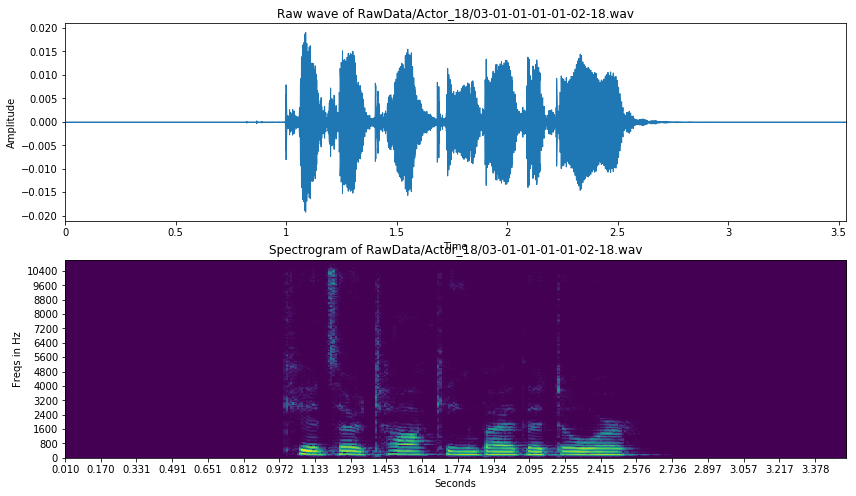

In [320]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [321]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [322]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-1.9141038e-07, -4.1607140e-07,  2.0688096e-06, ...,
         5.6699279e-05,  2.1195672e-05,  3.1794041e-06], dtype=float32),
 array([20992, 58880]))

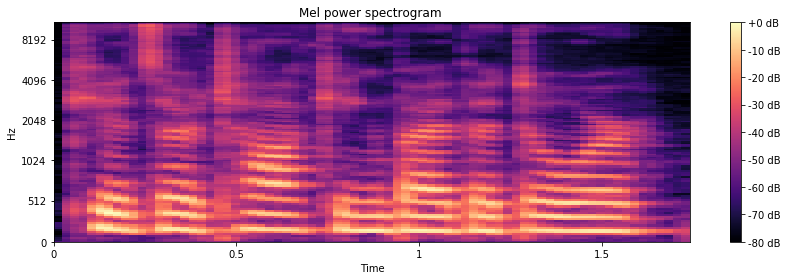

In [323]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB).Using the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

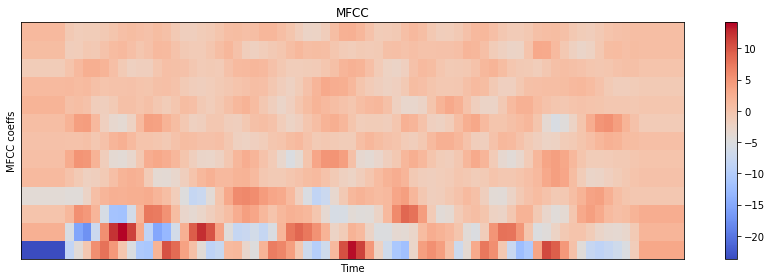

In [324]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# pad on the first and second deltas 
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [325]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [326]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [327]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [328]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [329]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [330]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [331]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [332]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,Actor,gender,intensity,statement,repetition,emotion,label
0,RawData/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_none
1,RawData/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1,male_none
2,RawData/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1,male_none
3,RawData/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1,male_none
4,RawData/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive


In [333]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_none', 'female_none',
       'female_positive', 'male_positive'],
      dtype='object')


In [334]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

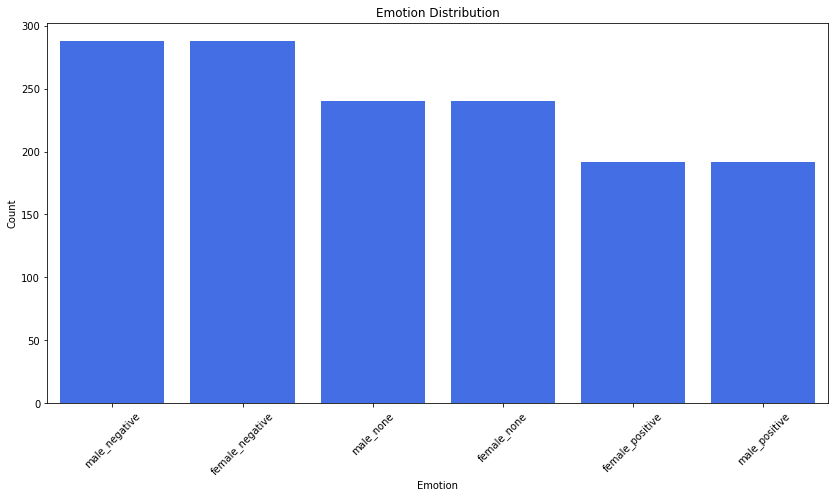

In [335]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [336]:
# Female Data Set

 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
data2_df = data2_df[data2_df.label != "male_happy"]
data2_df = data2_df[data2_df.label != "male_angry"]
data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.Actor == 22]
tmp2 = data2_df[data2_df.Actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.Actor != 22]
data2_df = data2_df[data2_df.Actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,Actor,gender,intensity,statement,repetition,emotion,label
0,RawData/Actor_02/03-01-02-01-01-01-02.wav,1,2,female,0,0,0,2,female_positive
1,RawData/Actor_02/03-01-02-01-01-02-02.wav,1,2,female,0,0,1,2,female_positive
2,RawData/Actor_02/03-01-02-01-02-01-02.wav,1,2,female,0,1,0,2,female_positive
3,RawData/Actor_02/03-01-02-01-02-02-02.wav,1,2,female,0,1,1,2,female_positive
4,RawData/Actor_02/03-01-02-02-01-01-02.wav,1,2,female,1,0,0,2,female_positive


In [337]:
# Male Data Set

 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.Actor == 21]
tmp2 = data2_df[data2_df.Actor == 22]
tmp3 = data2_df[data2_df.Actor == 23]
tmp4 = data2_df[data2_df.Actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.Actor != 21]
data2_df = data2_df[data2_df.Actor != 22]
data2_df = data2_df[data2_df.Actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.Actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,Actor,gender,intensity,statement,repetition,emotion,label
0,RawData/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive
1,RawData/Actor_01/03-01-02-01-01-02-01.wav,1,1,male,0,0,1,2,male_positive
2,RawData/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_positive
3,RawData/Actor_01/03-01-02-01-02-02-01.wav,1,1,male,0,1,1,2,male_positive
4,RawData/Actor_01/03-01-02-02-01-01-01.wav,1,1,male,1,0,0,2,male_positive


In [338]:
print (len(data3_df))
data3_df.head()

80


,path,source,Actor,gender,intensity,statement,repetition,emotion,label
0,RawData/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,0,2,male_positive
1,RawData/Actor_21/03-01-02-01-01-02-21.wav,1,21,male,0,0,1,2,male_positive
2,RawData/Actor_21/03-01-02-01-02-01-21.wav,1,21,male,0,1,0,2,male_positive
3,RawData/Actor_21/03-01-02-01-02-02-21.wav,1,21,male,0,1,1,2,male_positive
4,RawData/Actor_21/03-01-02-02-01-01-21.wav,1,21,male,1,0,0,2,male_positive


# VI. Getting the features of audio files using librosa

In [339]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:23<00:00, 17.27it/s]


In [340]:
data.head()

,feature
0,"[-70.2677641610773, -70.2677641610773, -70.267..."
1,"[-67.55739512198222, -67.55739512198222, -67.5..."
2,"[-69.67328949566406, -69.69331084873151, -69.6..."
3,"[-69.05139995492158, -69.05139995492158, -69.0..."
4,"[-73.8413701111492, -73.8413701111492, -73.841..."


In [341]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [342]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-70.267764,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764
1,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,...,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311
3,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-65.446950,-68.552088,-69.051400,-69.051400,-69.051400,-68.688614,-69.051400,NaN,NaN,NaN
4,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370


In [343]:
newdf = pd.concat([df3,labels], axis=1)

In [344]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [345]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,...,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-68.552088,-69.051400,-69.051400,-69.051400,-68.688614,-69.051400,NaN,NaN,NaN,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
5,-69.243253,-69.243253,-69.243253,-69.243253,-68.901972,-67.982999,-68.089201,-67.897329,-65.258010,-67.170980,...,-57.185978,-61.188731,-67.108389,-67.508122,-66.245553,-68.733048,-69.243253,-69.243253,-69.243253,male_positive
6,-73.254968,-73.254968,-73.254968,-73.254968,-68.774422,-69.380388,-73.254968,-73.254968,-73.254968,-73.254968,...,-50.884085,-55.666730,-54.600013,-53.439110,-56.300120,-57.458272,-58.767075,-59.836503,-58.409867,male_positive
7,-70.746514,-70.746514,-70.025286,-69.131263,-70.746514,-70.746514,-70.746514,-70.746514,-70.746514,-70.746514,...,-70.746514,-70.746514,-70.079249,-69.590462,-69.202740,-70.159467,-70.445363,-68.199043,-67.414208,male_positive
8,-63.311078,-63.072484,-63.412433,-63.796762,-63.581991,-58.921211,-57.955046,-61.224968,-63.782931,-63.796762,...,-63.740612,-62.410257,-62.489080,-62.494456,-62.632636,-62.824277,NaN,NaN,NaN,male_positive
9,-60.369038,-60.083715,-60.978925,-60.952456,-60.982486,-60.983948,-60.981255,-60.981255,-60.981255,-60.249618,...,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,NaN,NaN,NaN,male_positive


In [346]:
rnewdf.isnull().sum().sum()

2284

In [347]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,...,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-68.552088,-69.051400,-69.051400,-69.051400,-68.688614,-69.051400,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


# VII. Data Augmentation

In [348]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




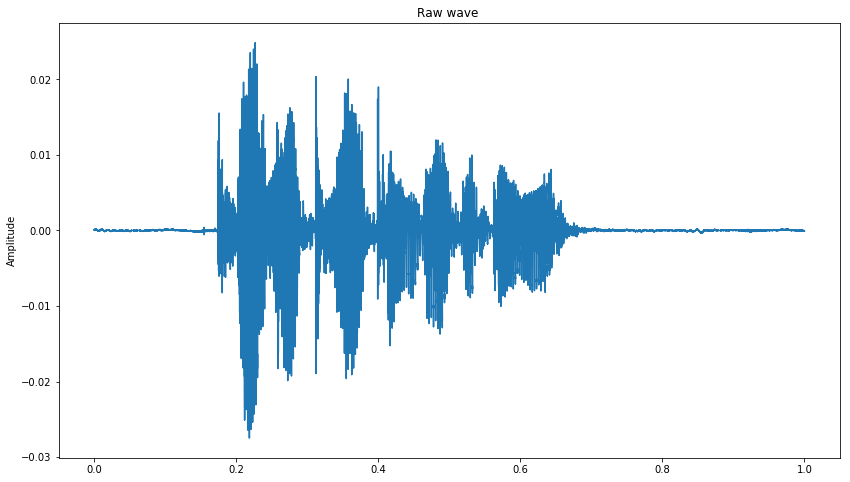

In [349]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

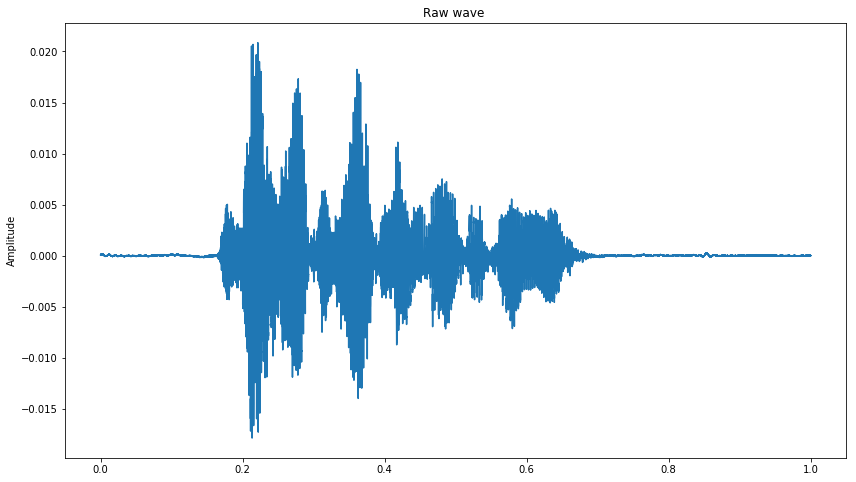

In [350]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [351]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:23<00:00, 16.86it/s]


In [352]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:46<00:00,  3.77it/s]


In [353]:
len(syn_data1), len(syn_data2) 

(400, 400)

In [354]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [355]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [356]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-64.213483,-61.937237,-61.477758,-61.513567,-60.686948,-63.229234,-63.146441,-64.517342,-64.434318,-64.334763,...,-63.814489,-62.300891,-61.244076,-61.856816,-61.328240,-62.493825,-63.855060,-63.646890,-65.340740,male_positive
1,-66.204172,-66.161347,-65.727864,-66.054405,-66.041011,-65.600832,-63.671252,-64.321638,-65.984464,-66.630112,...,-66.885296,-67.148902,-66.510023,-66.771823,-67.171230,-66.970879,-67.206054,-67.335614,-67.004137,male_positive
2,-64.514803,-61.694338,-61.188991,-63.225734,-64.870281,-64.677121,-62.564832,-63.942840,-60.645695,-59.777207,...,-63.798697,-61.863967,-59.465859,-60.571555,-61.540912,-62.301606,-63.329241,-60.810072,-61.870004,male_positive
3,-53.396740,-53.332650,-53.243111,-53.226214,-54.868343,-56.248931,-56.588196,-55.170186,-55.416033,-54.976698,...,-55.153040,-55.789133,-54.983514,-53.427558,-53.458240,-54.811820,0.000000,0.000000,0.000000,male_positive
4,-54.044262,-54.972124,-57.322020,-61.836282,-59.453408,-56.253845,-55.141475,-55.923807,-55.189543,-55.346419,...,-59.238343,-59.080796,-58.700736,-58.116191,-55.985752,-55.034725,-53.456519,-53.762497,-57.921256,male_positive


In [357]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [358]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-72.485447,-72.485447,-72.485447,-72.485447,-72.485447,-72.485447,-72.485447,-72.485447,-72.485447,-72.485447,...,-72.485447,-71.822701,-71.265048,-72.118287,-72.485447,-72.111814,-71.886188,-72.485447,-72.485447,male_positive
1,-71.238617,-71.172496,-70.998695,-71.238617,-71.238617,-70.070382,-68.640338,-70.774157,-71.238617,-71.238617,...,-71.238617,-71.238617,-71.238617,-71.238617,-71.238617,-71.238617,-71.238617,-71.238617,-71.223853,male_positive
2,-70.949715,-71.343943,-71.474302,-71.474302,-71.474302,-71.474302,-71.474302,-71.474302,-71.344984,-70.828008,...,-71.474302,-71.474302,-71.474302,-71.474302,-71.265249,-71.286935,-71.474302,-71.474302,-71.474302,male_positive
3,-69.510107,-69.510107,-69.510107,-69.510107,-69.510107,-69.510107,-69.510107,-69.510107,-69.510107,-69.510107,...,-68.753804,-69.510107,-69.510107,-69.510107,-69.510107,-69.510107,0.000000,0.000000,0.000000,male_positive
4,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-73.554863,-74.106953,...,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,-74.106953,male_positive


In [359]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,...,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-68.552088,-69.051400,-69.051400,-69.051400,-68.688614,-69.051400,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


In [360]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [361]:
y_train.value_counts()

male_negative    576
male_positive    384
Name: label, dtype: int64

In [362]:
y_test.value_counts()

male_negative    144
male_positive     96
Name: label, dtype: int64

In [363]:
X_train.isna().sum().sum()

0

In [364]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [365]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [366]:
X_train.shape

(960, 259)

# VIII. Changing dimension for CNN model

In [367]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [368]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [369]:
# New model
#target_class=5
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [370]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [371]:
# Plotting Model Summary

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 259, 256)          2304      
_________________________________________________________________
activation_37 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_9 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_38 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 32, 256)           0         
__________

In [372]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [412]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

mcp_save = ModelCheckpoint('model/aug_noiseNshift_6class6_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Train on 960 samples, validate on 240 samples
Epoch 1/700
960/960 [==============================] - ETA: 1:07 - loss: 0.3336 - acc: 0.9375 - fscore: 0.93 - ETA: 1:07 - loss: 0.3270 - acc: 0.9375 - fscore: 0.93 - ETA: 1:03 - loss: 0.3340 - acc: 0.9375 - fscore: 0.93 - ETA: 1:03 - loss: 0.3399 - acc: 0.9219 - fscore: 0.92 - ETA: 1:02 - loss: 0.3391 - acc: 0.9250 - fscore: 0.92 - ETA: 1:02 - loss: 0.3558 - acc: 0.9062 - fscore: 0.90 - ETA: 1:01 - loss: 0.3544 - acc: 0.9107 - fscore: 0.91 - ETA: 1:00 - loss: 0.3440 - acc: 0.9141 - fscore: 0.91 - ETA: 58s - loss: 0.3431 - acc: 0.9167 - fscore: 0.9167 - ETA: 57s - loss: 0.3552 - acc: 0.9000 - fscore: 0.900 - ETA: 56s - loss: 0.3573 - acc: 0.8920 - fscore: 0.892 - ETA: 55s - loss: 0.3683 - acc: 0.8802 - fscore: 0.880 - ETA: 53s - loss: 0.3742 - acc: 0.8798 - fscore: 0.879 - ETA: 52s - loss: 0.3741 - acc: 0.8839 - fscore: 0.883 - ETA: 51s - loss: 0.3698 - acc: 0.8833 - fscore: 0.883 - ETA: 49s - loss: 0.3646 - acc: 0.8906 - fscore: 0.890 - ET

960/960 [==============================] - ETA: 1:02 - loss: 0.4241 - acc: 0.7500 - fscore: 0.75 - ETA: 59s - loss: 0.4133 - acc: 0.7812 - fscore: 0.7812 - ETA: 1:00 - loss: 0.3676 - acc: 0.8333 - fscore: 0.83 - ETA: 58s - loss: 0.3624 - acc: 0.8438 - fscore: 0.8437 - ETA: 57s - loss: 0.3480 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.3346 - acc: 0.8750 - fscore: 0.875 - ETA: 56s - loss: 0.3376 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3347 - acc: 0.8750 - fscore: 0.875 - ETA: 53s - loss: 0.3372 - acc: 0.8819 - fscore: 0.881 - ETA: 52s - loss: 0.3327 - acc: 0.8938 - fscore: 0.893 - ETA: 50s - loss: 0.3322 - acc: 0.8864 - fscore: 0.886 - ETA: 49s - loss: 0.3428 - acc: 0.8698 - fscore: 0.869 - ETA: 48s - loss: 0.3389 - acc: 0.8798 - fscore: 0.879 - ETA: 47s - loss: 0.3424 - acc: 0.8750 - fscore: 0.875 - ETA: 46s - loss: 0.3451 - acc: 0.8792 - fscore: 0.879 - ETA: 45s - loss: 0.3508 - acc: 0.8750 - fscore: 0.875 - ETA: 44s - loss: 0.3511 - acc: 0.8750 - fscore: 0.875 - ETA

960/960 [==============================] - ETA: 52s - loss: 0.3177 - acc: 0.8750 - fscore: 0.875 - ETA: 56s - loss: 0.3253 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.3441 - acc: 0.8542 - fscore: 0.854 - ETA: 56s - loss: 0.3408 - acc: 0.8438 - fscore: 0.843 - ETA: 55s - loss: 0.3254 - acc: 0.8625 - fscore: 0.862 - ETA: 54s - loss: 0.3652 - acc: 0.8229 - fscore: 0.822 - ETA: 53s - loss: 0.3657 - acc: 0.8304 - fscore: 0.830 - ETA: 53s - loss: 0.3656 - acc: 0.8281 - fscore: 0.828 - ETA: 52s - loss: 0.3625 - acc: 0.8333 - fscore: 0.833 - ETA: 50s - loss: 0.3742 - acc: 0.8250 - fscore: 0.825 - ETA: 49s - loss: 0.3669 - acc: 0.8352 - fscore: 0.835 - ETA: 48s - loss: 0.3719 - acc: 0.8333 - fscore: 0.833 - ETA: 47s - loss: 0.3681 - acc: 0.8365 - fscore: 0.836 - ETA: 46s - loss: 0.3691 - acc: 0.8438 - fscore: 0.843 - ETA: 45s - loss: 0.3785 - acc: 0.8375 - fscore: 0.837 - ETA: 44s - loss: 0.3775 - acc: 0.8398 - fscore: 0.839 - ETA: 43s - loss: 0.3787 - acc: 0.8382 - fscore: 0.838 - ETA: 

960/960 [==============================] - ETA: 1:05 - loss: 0.4757 - acc: 0.8125 - fscore: 0.81 - ETA: 59s - loss: 0.3768 - acc: 0.8750 - fscore: 0.8750 - ETA: 57s - loss: 0.3466 - acc: 0.8958 - fscore: 0.895 - ETA: 55s - loss: 0.3502 - acc: 0.8906 - fscore: 0.890 - ETA: 54s - loss: 0.3441 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3506 - acc: 0.8750 - fscore: 0.875 - ETA: 53s - loss: 0.3518 - acc: 0.8661 - fscore: 0.866 - ETA: 52s - loss: 0.3574 - acc: 0.8594 - fscore: 0.859 - ETA: 51s - loss: 0.3650 - acc: 0.8611 - fscore: 0.861 - ETA: 50s - loss: 0.3530 - acc: 0.8750 - fscore: 0.875 - ETA: 48s - loss: 0.3539 - acc: 0.8750 - fscore: 0.875 - ETA: 48s - loss: 0.3518 - acc: 0.8698 - fscore: 0.869 - ETA: 47s - loss: 0.3473 - acc: 0.8702 - fscore: 0.870 - ETA: 46s - loss: 0.3401 - acc: 0.8795 - fscore: 0.879 - ETA: 45s - loss: 0.3556 - acc: 0.8750 - fscore: 0.875 - ETA: 44s - loss: 0.3732 - acc: 0.8594 - fscore: 0.859 - ETA: 43s - loss: 0.3655 - acc: 0.8676 - fscore: 0.867 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.4787 - acc: 0.7500 - fscore: 0.75 - ETA: 57s - loss: 0.3854 - acc: 0.8438 - fscore: 0.8437 - ETA: 54s - loss: 0.3792 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3794 - acc: 0.8594 - fscore: 0.859 - ETA: 54s - loss: 0.3562 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3710 - acc: 0.8646 - fscore: 0.864 - ETA: 53s - loss: 0.3968 - acc: 0.8482 - fscore: 0.848 - ETA: 52s - loss: 0.3778 - acc: 0.8672 - fscore: 0.867 - ETA: 51s - loss: 0.3688 - acc: 0.8750 - fscore: 0.875 - ETA: 49s - loss: 0.3897 - acc: 0.8688 - fscore: 0.868 - ETA: 49s - loss: 0.4010 - acc: 0.8466 - fscore: 0.846 - ETA: 48s - loss: 0.4062 - acc: 0.8385 - fscore: 0.838 - ETA: 47s - loss: 0.4048 - acc: 0.8365 - fscore: 0.836 - ETA: 46s - loss: 0.3983 - acc: 0.8438 - fscore: 0.843 - ETA: 45s - loss: 0.3889 - acc: 0.8500 - fscore: 0.850 - ETA: 44s - loss: 0.3873 - acc: 0.8516 - fscore: 0.851 - ETA: 43s - loss: 0.3901 - acc: 0.8419 - fscore: 0.841 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.3611 - acc: 0.8750 - fscore: 0.87 - ETA: 59s - loss: 0.3609 - acc: 0.8750 - fscore: 0.8750 - ETA: 58s - loss: 0.3766 - acc: 0.8542 - fscore: 0.854 - ETA: 57s - loss: 0.3929 - acc: 0.8594 - fscore: 0.859 - ETA: 56s - loss: 0.3578 - acc: 0.8875 - fscore: 0.887 - ETA: 55s - loss: 0.3457 - acc: 0.8958 - fscore: 0.895 - ETA: 54s - loss: 0.3394 - acc: 0.9018 - fscore: 0.901 - ETA: 52s - loss: 0.3346 - acc: 0.8984 - fscore: 0.898 - ETA: 51s - loss: 0.3335 - acc: 0.8819 - fscore: 0.881 - ETA: 51s - loss: 0.3280 - acc: 0.8875 - fscore: 0.887 - ETA: 50s - loss: 0.3295 - acc: 0.8864 - fscore: 0.886 - ETA: 48s - loss: 0.3250 - acc: 0.8854 - fscore: 0.885 - ETA: 47s - loss: 0.3213 - acc: 0.8846 - fscore: 0.884 - ETA: 46s - loss: 0.3398 - acc: 0.8795 - fscore: 0.879 - ETA: 45s - loss: 0.3532 - acc: 0.8708 - fscore: 0.870 - ETA: 44s - loss: 0.3530 - acc: 0.8711 - fscore: 0.871 - ETA: 43s - loss: 0.3493 - acc: 0.8750 - fscore: 0.875 - ETA:

960/960 [==============================] - ETA: 52s - loss: 0.3629 - acc: 0.8750 - fscore: 0.875 - ETA: 55s - loss: 0.3716 - acc: 0.8750 - fscore: 0.875 - ETA: 55s - loss: 0.3300 - acc: 0.9167 - fscore: 0.916 - ETA: 56s - loss: 0.3565 - acc: 0.8906 - fscore: 0.890 - ETA: 55s - loss: 0.3454 - acc: 0.9125 - fscore: 0.912 - ETA: 54s - loss: 0.3339 - acc: 0.9167 - fscore: 0.916 - ETA: 53s - loss: 0.3403 - acc: 0.9107 - fscore: 0.910 - ETA: 52s - loss: 0.3294 - acc: 0.9141 - fscore: 0.914 - ETA: 51s - loss: 0.3146 - acc: 0.9236 - fscore: 0.923 - ETA: 50s - loss: 0.3154 - acc: 0.9187 - fscore: 0.918 - ETA: 49s - loss: 0.3217 - acc: 0.9148 - fscore: 0.914 - ETA: 48s - loss: 0.3221 - acc: 0.9167 - fscore: 0.916 - ETA: 47s - loss: 0.3251 - acc: 0.9135 - fscore: 0.913 - ETA: 46s - loss: 0.3259 - acc: 0.9107 - fscore: 0.910 - ETA: 45s - loss: 0.3293 - acc: 0.9083 - fscore: 0.908 - ETA: 44s - loss: 0.3314 - acc: 0.9062 - fscore: 0.906 - ETA: 43s - loss: 0.3319 - acc: 0.9044 - fscore: 0.904 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.2597 - acc: 0.9375 - fscore: 0.937 - ETA: 58s - loss: 0.3277 - acc: 0.8750 - fscore: 0.875 - ETA: 58s - loss: 0.3559 - acc: 0.8542 - fscore: 0.854 - ETA: 58s - loss: 0.3392 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.3414 - acc: 0.8875 - fscore: 0.887 - ETA: 56s - loss: 0.3384 - acc: 0.8958 - fscore: 0.895 - ETA: 55s - loss: 0.3264 - acc: 0.9107 - fscore: 0.910 - ETA: 54s - loss: 0.3133 - acc: 0.9219 - fscore: 0.921 - ETA: 53s - loss: 0.3119 - acc: 0.9097 - fscore: 0.909 - ETA: 51s - loss: 0.3305 - acc: 0.8938 - fscore: 0.893 - ETA: 50s - loss: 0.3535 - acc: 0.8807 - fscore: 0.880 - ETA: 49s - loss: 0.3652 - acc: 0.8698 - fscore: 0.869 - ETA: 48s - loss: 0.3626 - acc: 0.8702 - fscore: 0.870 - ETA: 47s - loss: 0.3521 - acc: 0.8795 - fscore: 0.879 - ETA: 46s - loss: 0.3478 - acc: 0.8833 - fscore: 0.883 - ETA: 44s - loss: 0.3463 - acc: 0.8789 - fscore: 0.878 - ETA: 43s - loss: 0.3422 - acc: 0.8824 - fscore: 0.882 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.3216 - acc: 0.8750 - fscore: 0.875 - ETA: 59s - loss: 0.3741 - acc: 0.8125 - fscore: 0.812 - ETA: 58s - loss: 0.3301 - acc: 0.8542 - fscore: 0.854 - ETA: 58s - loss: 0.3460 - acc: 0.8594 - fscore: 0.859 - ETA: 57s - loss: 0.3922 - acc: 0.8250 - fscore: 0.825 - ETA: 55s - loss: 0.3923 - acc: 0.8333 - fscore: 0.833 - ETA: 53s - loss: 0.3623 - acc: 0.8571 - fscore: 0.857 - ETA: 53s - loss: 0.3454 - acc: 0.8750 - fscore: 0.875 - ETA: 52s - loss: 0.3456 - acc: 0.8819 - fscore: 0.881 - ETA: 50s - loss: 0.3428 - acc: 0.8875 - fscore: 0.887 - ETA: 50s - loss: 0.3425 - acc: 0.8920 - fscore: 0.892 - ETA: 49s - loss: 0.3580 - acc: 0.8854 - fscore: 0.885 - ETA: 48s - loss: 0.3568 - acc: 0.8846 - fscore: 0.884 - ETA: 47s - loss: 0.3638 - acc: 0.8839 - fscore: 0.883 - ETA: 45s - loss: 0.3590 - acc: 0.8792 - fscore: 0.879 - ETA: 44s - loss: 0.3564 - acc: 0.8789 - fscore: 0.878 - ETA: 43s - loss: 0.3608 - acc: 0.8713 - fscore: 0.871 - ETA: 

960/960 [==============================] - ETA: 1:06 - loss: 0.2532 - acc: 0.8750 - fscore: 0.87 - ETA: 1:06 - loss: 0.2725 - acc: 0.8750 - fscore: 0.87 - ETA: 1:01 - loss: 0.2872 - acc: 0.8750 - fscore: 0.87 - ETA: 1:00 - loss: 0.2967 - acc: 0.8750 - fscore: 0.87 - ETA: 59s - loss: 0.3423 - acc: 0.8250 - fscore: 0.8250 - ETA: 56s - loss: 0.3621 - acc: 0.8125 - fscore: 0.812 - ETA: 54s - loss: 0.3730 - acc: 0.8036 - fscore: 0.803 - ETA: 54s - loss: 0.3659 - acc: 0.8203 - fscore: 0.820 - ETA: 53s - loss: 0.3621 - acc: 0.8264 - fscore: 0.826 - ETA: 52s - loss: 0.3531 - acc: 0.8375 - fscore: 0.837 - ETA: 50s - loss: 0.3544 - acc: 0.8352 - fscore: 0.835 - ETA: 49s - loss: 0.3509 - acc: 0.8438 - fscore: 0.843 - ETA: 48s - loss: 0.3498 - acc: 0.8413 - fscore: 0.841 - ETA: 47s - loss: 0.3518 - acc: 0.8438 - fscore: 0.843 - ETA: 46s - loss: 0.3516 - acc: 0.8542 - fscore: 0.854 - ETA: 45s - loss: 0.3422 - acc: 0.8633 - fscore: 0.863 - ETA: 44s - loss: 0.3361 - acc: 0.8713 - fscore: 0.871 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.2794 - acc: 0.9375 - fscore: 0.937 - ETA: 1:00 - loss: 0.3240 - acc: 0.8750 - fscore: 0.87 - ETA: 59s - loss: 0.2829 - acc: 0.9167 - fscore: 0.9167 - ETA: 58s - loss: 0.2864 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2902 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.2882 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.3006 - acc: 0.9286 - fscore: 0.928 - ETA: 53s - loss: 0.3017 - acc: 0.9297 - fscore: 0.929 - ETA: 53s - loss: 0.3098 - acc: 0.9167 - fscore: 0.916 - ETA: 51s - loss: 0.3244 - acc: 0.9000 - fscore: 0.900 - ETA: 50s - loss: 0.3310 - acc: 0.8864 - fscore: 0.886 - ETA: 49s - loss: 0.3259 - acc: 0.8958 - fscore: 0.895 - ETA: 48s - loss: 0.3234 - acc: 0.8942 - fscore: 0.894 - ETA: 47s - loss: 0.3157 - acc: 0.9018 - fscore: 0.901 - ETA: 46s - loss: 0.3169 - acc: 0.9000 - fscore: 0.900 - ETA: 45s - loss: 0.3222 - acc: 0.8945 - fscore: 0.894 - ETA: 44s - loss: 0.3229 - acc: 0.8897 - fscore: 0.889 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.3564 - acc: 0.8125 - fscore: 0.81 - ETA: 57s - loss: 0.3115 - acc: 0.8750 - fscore: 0.8750 - ETA: 55s - loss: 0.3684 - acc: 0.8333 - fscore: 0.833 - ETA: 56s - loss: 0.3604 - acc: 0.8438 - fscore: 0.843 - ETA: 56s - loss: 0.3435 - acc: 0.8750 - fscore: 0.875 - ETA: 55s - loss: 0.3463 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3415 - acc: 0.8839 - fscore: 0.883 - ETA: 53s - loss: 0.3476 - acc: 0.8828 - fscore: 0.882 - ETA: 52s - loss: 0.3428 - acc: 0.8819 - fscore: 0.881 - ETA: 51s - loss: 0.3462 - acc: 0.8688 - fscore: 0.868 - ETA: 49s - loss: 0.3502 - acc: 0.8636 - fscore: 0.863 - ETA: 49s - loss: 0.3622 - acc: 0.8542 - fscore: 0.854 - ETA: 48s - loss: 0.3613 - acc: 0.8606 - fscore: 0.860 - ETA: 46s - loss: 0.3667 - acc: 0.8527 - fscore: 0.852 - ETA: 45s - loss: 0.3569 - acc: 0.8583 - fscore: 0.858 - ETA: 44s - loss: 0.3518 - acc: 0.8633 - fscore: 0.863 - ETA: 43s - loss: 0.3466 - acc: 0.8676 - fscore: 0.867 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.2432 - acc: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.2782 - acc: 0.9062 - fscore: 0.9062 - ETA: 54s - loss: 0.2777 - acc: 0.8958 - fscore: 0.895 - ETA: 54s - loss: 0.2746 - acc: 0.8906 - fscore: 0.890 - ETA: 54s - loss: 0.2617 - acc: 0.9125 - fscore: 0.912 - ETA: 52s - loss: 0.2691 - acc: 0.9167 - fscore: 0.916 - ETA: 51s - loss: 0.2679 - acc: 0.9196 - fscore: 0.919 - ETA: 50s - loss: 0.2744 - acc: 0.9141 - fscore: 0.914 - ETA: 50s - loss: 0.2817 - acc: 0.9028 - fscore: 0.902 - ETA: 49s - loss: 0.2895 - acc: 0.9000 - fscore: 0.900 - ETA: 48s - loss: 0.2984 - acc: 0.8977 - fscore: 0.897 - ETA: 47s - loss: 0.3049 - acc: 0.8906 - fscore: 0.890 - ETA: 46s - loss: 0.3056 - acc: 0.8942 - fscore: 0.894 - ETA: 45s - loss: 0.3067 - acc: 0.8973 - fscore: 0.897 - ETA: 44s - loss: 0.3148 - acc: 0.8917 - fscore: 0.891 - ETA: 43s - loss: 0.3163 - acc: 0.8867 - fscore: 0.886 - ETA: 42s - loss: 0.3210 - acc: 0.8860 - fscore: 0.886 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.2989 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.3009 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.3103 - acc: 0.8958 - fscore: 0.895 - ETA: 56s - loss: 0.3015 - acc: 0.9062 - fscore: 0.906 - ETA: 56s - loss: 0.2777 - acc: 0.9250 - fscore: 0.925 - ETA: 55s - loss: 0.2935 - acc: 0.8958 - fscore: 0.895 - ETA: 54s - loss: 0.2787 - acc: 0.9107 - fscore: 0.910 - ETA: 52s - loss: 0.2698 - acc: 0.9219 - fscore: 0.921 - ETA: 51s - loss: 0.2830 - acc: 0.9028 - fscore: 0.902 - ETA: 49s - loss: 0.2901 - acc: 0.8938 - fscore: 0.893 - ETA: 49s - loss: 0.2992 - acc: 0.8977 - fscore: 0.897 - ETA: 47s - loss: 0.3002 - acc: 0.8958 - fscore: 0.895 - ETA: 47s - loss: 0.3069 - acc: 0.8942 - fscore: 0.894 - ETA: 46s - loss: 0.3022 - acc: 0.9018 - fscore: 0.901 - ETA: 44s - loss: 0.2952 - acc: 0.9083 - fscore: 0.908 - ETA: 44s - loss: 0.2945 - acc: 0.9141 - fscore: 0.914 - ETA: 43s - loss: 0.3011 - acc: 0.9081 - fscore: 0.908 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.2159 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.2199 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.2502 - acc: 0.9583 - fscore: 0.958 - ETA: 54s - loss: 0.2645 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2659 - acc: 0.9500 - fscore: 0.950 - ETA: 54s - loss: 0.2610 - acc: 0.9583 - fscore: 0.958 - ETA: 53s - loss: 0.2689 - acc: 0.9375 - fscore: 0.937 - ETA: 52s - loss: 0.2612 - acc: 0.9375 - fscore: 0.937 - ETA: 52s - loss: 0.2651 - acc: 0.9375 - fscore: 0.937 - ETA: 51s - loss: 0.2658 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2558 - acc: 0.9432 - fscore: 0.943 - ETA: 49s - loss: 0.2557 - acc: 0.9479 - fscore: 0.947 - ETA: 48s - loss: 0.2676 - acc: 0.9375 - fscore: 0.937 - ETA: 47s - loss: 0.2726 - acc: 0.9375 - fscore: 0.937 - ETA: 46s - loss: 0.2750 - acc: 0.9375 - fscore: 0.937 - ETA: 44s - loss: 0.2822 - acc: 0.9336 - fscore: 0.933 - ETA: 43s - loss: 0.2851 - acc: 0.9301 - fscore: 0.930 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.1926 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.2407 - acc: 0.9688 - fscore: 0.968 - ETA: 55s - loss: 0.2744 - acc: 0.9167 - fscore: 0.916 - ETA: 55s - loss: 0.2992 - acc: 0.8594 - fscore: 0.859 - ETA: 53s - loss: 0.3156 - acc: 0.8500 - fscore: 0.850 - ETA: 52s - loss: 0.3454 - acc: 0.8438 - fscore: 0.843 - ETA: 51s - loss: 0.3317 - acc: 0.8571 - fscore: 0.857 - ETA: 51s - loss: 0.3192 - acc: 0.8672 - fscore: 0.867 - ETA: 50s - loss: 0.3149 - acc: 0.8750 - fscore: 0.875 - ETA: 49s - loss: 0.3193 - acc: 0.8812 - fscore: 0.881 - ETA: 49s - loss: 0.3210 - acc: 0.8864 - fscore: 0.886 - ETA: 48s - loss: 0.3243 - acc: 0.8854 - fscore: 0.885 - ETA: 47s - loss: 0.3273 - acc: 0.8702 - fscore: 0.870 - ETA: 45s - loss: 0.3269 - acc: 0.8661 - fscore: 0.866 - ETA: 44s - loss: 0.3196 - acc: 0.8750 - fscore: 0.875 - ETA: 43s - loss: 0.3195 - acc: 0.8711 - fscore: 0.871 - ETA: 42s - loss: 0.3186 - acc: 0.8750 - fscore: 0.875 - ETA: 

960/960 [==============================] - ETA: 1:12 - loss: 0.1898 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.2414 - acc: 0.9375 - fscore: 0.93 - ETA: 1:04 - loss: 0.2645 - acc: 0.9375 - fscore: 0.93 - ETA: 1:04 - loss: 0.2478 - acc: 0.9531 - fscore: 0.95 - ETA: 1:02 - loss: 0.2325 - acc: 0.9625 - fscore: 0.96 - ETA: 1:00 - loss: 0.2565 - acc: 0.9375 - fscore: 0.93 - ETA: 58s - loss: 0.2657 - acc: 0.9375 - fscore: 0.9375 - ETA: 57s - loss: 0.2678 - acc: 0.9297 - fscore: 0.929 - ETA: 55s - loss: 0.2692 - acc: 0.9167 - fscore: 0.916 - ETA: 54s - loss: 0.2760 - acc: 0.9125 - fscore: 0.912 - ETA: 53s - loss: 0.2773 - acc: 0.9148 - fscore: 0.914 - ETA: 51s - loss: 0.2742 - acc: 0.9219 - fscore: 0.921 - ETA: 50s - loss: 0.2791 - acc: 0.9183 - fscore: 0.918 - ETA: 49s - loss: 0.2801 - acc: 0.9196 - fscore: 0.919 - ETA: 48s - loss: 0.2868 - acc: 0.9167 - fscore: 0.916 - ETA: 46s - loss: 0.2942 - acc: 0.9102 - fscore: 0.910 - ETA: 45s - loss: 0.3069 - acc: 0.9007 - fscore: 0.900 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.2393 - acc: 0.9375 - fscore: 0.93 - ETA: 59s - loss: 0.2581 - acc: 0.9375 - fscore: 0.9375 - ETA: 57s - loss: 0.2896 - acc: 0.9167 - fscore: 0.916 - ETA: 54s - loss: 0.3055 - acc: 0.8906 - fscore: 0.890 - ETA: 54s - loss: 0.3132 - acc: 0.9000 - fscore: 0.900 - ETA: 53s - loss: 0.3163 - acc: 0.8854 - fscore: 0.885 - ETA: 53s - loss: 0.3114 - acc: 0.8839 - fscore: 0.883 - ETA: 52s - loss: 0.3116 - acc: 0.8828 - fscore: 0.882 - ETA: 51s - loss: 0.3101 - acc: 0.8819 - fscore: 0.881 - ETA: 49s - loss: 0.3163 - acc: 0.8688 - fscore: 0.868 - ETA: 49s - loss: 0.3076 - acc: 0.8807 - fscore: 0.880 - ETA: 48s - loss: 0.3102 - acc: 0.8750 - fscore: 0.875 - ETA: 47s - loss: 0.3203 - acc: 0.8606 - fscore: 0.860 - ETA: 46s - loss: 0.3215 - acc: 0.8661 - fscore: 0.866 - ETA: 45s - loss: 0.3127 - acc: 0.8708 - fscore: 0.870 - ETA: 44s - loss: 0.3232 - acc: 0.8633 - fscore: 0.863 - ETA: 43s - loss: 0.3195 - acc: 0.8676 - fscore: 0.867 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.2269 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.2771 - acc: 0.9688 - fscore: 0.968 - ETA: 57s - loss: 0.2804 - acc: 0.9583 - fscore: 0.958 - ETA: 56s - loss: 0.2514 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.2627 - acc: 0.9500 - fscore: 0.950 - ETA: 53s - loss: 0.2667 - acc: 0.9375 - fscore: 0.937 - ETA: 53s - loss: 0.2558 - acc: 0.9375 - fscore: 0.937 - ETA: 51s - loss: 0.2625 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2607 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2723 - acc: 0.9250 - fscore: 0.925 - ETA: 49s - loss: 0.2692 - acc: 0.9318 - fscore: 0.931 - ETA: 48s - loss: 0.2731 - acc: 0.9323 - fscore: 0.932 - ETA: 47s - loss: 0.2708 - acc: 0.9279 - fscore: 0.927 - ETA: 46s - loss: 0.2736 - acc: 0.9241 - fscore: 0.924 - ETA: 45s - loss: 0.2757 - acc: 0.9208 - fscore: 0.920 - ETA: 44s - loss: 0.2755 - acc: 0.9258 - fscore: 0.925 - ETA: 43s - loss: 0.2799 - acc: 0.9191 - fscore: 0.919 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.3429 - acc: 0.8750 - fscore: 0.875 - ETA: 1:00 - loss: 0.4436 - acc: 0.8125 - fscore: 0.81 - ETA: 58s - loss: 0.3515 - acc: 0.8750 - fscore: 0.8750 - ETA: 58s - loss: 0.3283 - acc: 0.9062 - fscore: 0.906 - ETA: 57s - loss: 0.3397 - acc: 0.8625 - fscore: 0.862 - ETA: 55s - loss: 0.3182 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3110 - acc: 0.8839 - fscore: 0.883 - ETA: 53s - loss: 0.3010 - acc: 0.8984 - fscore: 0.898 - ETA: 53s - loss: 0.2899 - acc: 0.9097 - fscore: 0.909 - ETA: 52s - loss: 0.2956 - acc: 0.9062 - fscore: 0.906 - ETA: 51s - loss: 0.2904 - acc: 0.9148 - fscore: 0.914 - ETA: 50s - loss: 0.2819 - acc: 0.9219 - fscore: 0.921 - ETA: 49s - loss: 0.2830 - acc: 0.9183 - fscore: 0.918 - ETA: 48s - loss: 0.2867 - acc: 0.9152 - fscore: 0.915 - ETA: 47s - loss: 0.2887 - acc: 0.9167 - fscore: 0.916 - ETA: 46s - loss: 0.2960 - acc: 0.9102 - fscore: 0.910 - ETA: 45s - loss: 0.2927 - acc: 0.9118 - fscore: 0.911 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.1395 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.2310 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.2304 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.2262 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2379 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2445 - acc: 0.9271 - fscore: 0.927 - ETA: 54s - loss: 0.2888 - acc: 0.9018 - fscore: 0.901 - ETA: 54s - loss: 0.2865 - acc: 0.9062 - fscore: 0.906 - ETA: 53s - loss: 0.2760 - acc: 0.9097 - fscore: 0.909 - ETA: 51s - loss: 0.2633 - acc: 0.9187 - fscore: 0.918 - ETA: 50s - loss: 0.2615 - acc: 0.9205 - fscore: 0.920 - ETA: 49s - loss: 0.2590 - acc: 0.9219 - fscore: 0.921 - ETA: 48s - loss: 0.2688 - acc: 0.9183 - fscore: 0.918 - ETA: 47s - loss: 0.2754 - acc: 0.9062 - fscore: 0.906 - ETA: 46s - loss: 0.2699 - acc: 0.9125 - fscore: 0.912 - ETA: 45s - loss: 0.2690 - acc: 0.9141 - fscore: 0.914 - ETA: 44s - loss: 0.2745 - acc: 0.9118 - fscore: 0.911 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.2797 - acc: 0.8750 - fscore: 0.875 - ETA: 56s - loss: 0.3193 - acc: 0.8750 - fscore: 0.875 - ETA: 56s - loss: 0.3027 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3027 - acc: 0.8906 - fscore: 0.890 - ETA: 53s - loss: 0.3054 - acc: 0.8875 - fscore: 0.887 - ETA: 52s - loss: 0.2924 - acc: 0.8958 - fscore: 0.895 - ETA: 51s - loss: 0.2929 - acc: 0.9018 - fscore: 0.901 - ETA: 51s - loss: 0.2895 - acc: 0.9062 - fscore: 0.906 - ETA: 50s - loss: 0.2948 - acc: 0.8958 - fscore: 0.895 - ETA: 48s - loss: 0.2890 - acc: 0.9000 - fscore: 0.900 - ETA: 47s - loss: 0.2920 - acc: 0.9034 - fscore: 0.903 - ETA: 47s - loss: 0.2905 - acc: 0.9062 - fscore: 0.906 - ETA: 46s - loss: 0.2958 - acc: 0.9038 - fscore: 0.903 - ETA: 45s - loss: 0.2986 - acc: 0.9062 - fscore: 0.906 - ETA: 44s - loss: 0.3067 - acc: 0.9000 - fscore: 0.900 - ETA: 43s - loss: 0.3008 - acc: 0.9062 - fscore: 0.906 - ETA: 42s - loss: 0.3028 - acc: 0.9044 - fscore: 0.904 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.2474 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.2205 - acc: 0.9375 - fscore: 0.937 - ETA: 58s - loss: 0.2637 - acc: 0.8750 - fscore: 0.875 - ETA: 58s - loss: 0.2610 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.2504 - acc: 0.9000 - fscore: 0.900 - ETA: 56s - loss: 0.2440 - acc: 0.9167 - fscore: 0.916 - ETA: 55s - loss: 0.2426 - acc: 0.9286 - fscore: 0.928 - ETA: 53s - loss: 0.2487 - acc: 0.9219 - fscore: 0.921 - ETA: 52s - loss: 0.2569 - acc: 0.9167 - fscore: 0.916 - ETA: 51s - loss: 0.2523 - acc: 0.9125 - fscore: 0.912 - ETA: 50s - loss: 0.2613 - acc: 0.9034 - fscore: 0.903 - ETA: 49s - loss: 0.2591 - acc: 0.9010 - fscore: 0.901 - ETA: 48s - loss: 0.2474 - acc: 0.9087 - fscore: 0.908 - ETA: 47s - loss: 0.2490 - acc: 0.9062 - fscore: 0.906 - ETA: 46s - loss: 0.2456 - acc: 0.9125 - fscore: 0.912 - ETA: 45s - loss: 0.2401 - acc: 0.9180 - fscore: 0.918 - ETA: 44s - loss: 0.2430 - acc: 0.9118 - fscore: 0.911 - ETA: 

960/960 [==============================] - ETA: 1:12 - loss: 0.2518 - acc: 0.9375 - fscore: 0.93 - ETA: 1:11 - loss: 0.2704 - acc: 0.9062 - fscore: 0.90 - ETA: 1:11 - loss: 0.2785 - acc: 0.8958 - fscore: 0.89 - ETA: 1:08 - loss: 0.3094 - acc: 0.8750 - fscore: 0.87 - ETA: 1:05 - loss: 0.3090 - acc: 0.8750 - fscore: 0.87 - ETA: 1:03 - loss: 0.3016 - acc: 0.8854 - fscore: 0.88 - ETA: 1:02 - loss: 0.2851 - acc: 0.9018 - fscore: 0.90 - ETA: 1:00 - loss: 0.2742 - acc: 0.9062 - fscore: 0.90 - ETA: 58s - loss: 0.2746 - acc: 0.9028 - fscore: 0.9028 - ETA: 57s - loss: 0.2645 - acc: 0.9125 - fscore: 0.912 - ETA: 55s - loss: 0.2597 - acc: 0.9148 - fscore: 0.914 - ETA: 54s - loss: 0.2722 - acc: 0.9010 - fscore: 0.901 - ETA: 53s - loss: 0.2779 - acc: 0.8942 - fscore: 0.894 - ETA: 51s - loss: 0.2868 - acc: 0.8884 - fscore: 0.888 - ETA: 50s - loss: 0.2861 - acc: 0.8958 - fscore: 0.895 - ETA: 49s - loss: 0.2874 - acc: 0.8906 - fscore: 0.890 - ETA: 48s - loss: 0.2846 - acc: 0.8934 - fscore: 0.893 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.2446 - acc: 0.9375 - fscore: 0.93 - ETA: 1:01 - loss: 0.2012 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.2522 - acc: 0.8958 - fscore: 0.89 - ETA: 58s - loss: 0.2455 - acc: 0.9062 - fscore: 0.9062 - ETA: 57s - loss: 0.2622 - acc: 0.9000 - fscore: 0.900 - ETA: 56s - loss: 0.2537 - acc: 0.9062 - fscore: 0.906 - ETA: 54s - loss: 0.2474 - acc: 0.9196 - fscore: 0.919 - ETA: 53s - loss: 0.2398 - acc: 0.9297 - fscore: 0.929 - ETA: 52s - loss: 0.2377 - acc: 0.9306 - fscore: 0.930 - ETA: 50s - loss: 0.2509 - acc: 0.9313 - fscore: 0.931 - ETA: 49s - loss: 0.2497 - acc: 0.9261 - fscore: 0.926 - ETA: 48s - loss: 0.2477 - acc: 0.9271 - fscore: 0.927 - ETA: 47s - loss: 0.2452 - acc: 0.9279 - fscore: 0.927 - ETA: 45s - loss: 0.2480 - acc: 0.9286 - fscore: 0.928 - ETA: 44s - loss: 0.2474 - acc: 0.9292 - fscore: 0.929 - ETA: 43s - loss: 0.2479 - acc: 0.9219 - fscore: 0.921 - ETA: 42s - loss: 0.2575 - acc: 0.9118 - fscore: 0.911 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.1710 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.2326 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.3070 - acc: 0.8750 - fscore: 0.875 - ETA: 56s - loss: 0.2935 - acc: 0.8906 - fscore: 0.890 - ETA: 55s - loss: 0.3032 - acc: 0.8875 - fscore: 0.887 - ETA: 54s - loss: 0.3133 - acc: 0.8854 - fscore: 0.885 - ETA: 52s - loss: 0.3107 - acc: 0.8839 - fscore: 0.883 - ETA: 51s - loss: 0.3047 - acc: 0.8828 - fscore: 0.882 - ETA: 50s - loss: 0.2966 - acc: 0.8889 - fscore: 0.888 - ETA: 49s - loss: 0.2977 - acc: 0.8875 - fscore: 0.887 - ETA: 48s - loss: 0.2985 - acc: 0.8864 - fscore: 0.886 - ETA: 47s - loss: 0.2927 - acc: 0.8906 - fscore: 0.890 - ETA: 46s - loss: 0.2947 - acc: 0.8942 - fscore: 0.894 - ETA: 45s - loss: 0.2942 - acc: 0.8973 - fscore: 0.897 - ETA: 44s - loss: 0.2948 - acc: 0.8917 - fscore: 0.891 - ETA: 43s - loss: 0.2865 - acc: 0.8945 - fscore: 0.894 - ETA: 43s - loss: 0.2825 - acc: 0.8971 - fscore: 0.897 - ETA: 

960/960 [==============================] - ETA: 1:11 - loss: 0.2695 - acc: 0.8750 - fscore: 0.87 - ETA: 1:09 - loss: 0.2514 - acc: 0.9062 - fscore: 0.90 - ETA: 1:05 - loss: 0.2484 - acc: 0.9167 - fscore: 0.91 - ETA: 1:02 - loss: 0.2372 - acc: 0.9375 - fscore: 0.93 - ETA: 1:01 - loss: 0.2718 - acc: 0.9250 - fscore: 0.92 - ETA: 59s - loss: 0.2939 - acc: 0.9062 - fscore: 0.9062 - ETA: 58s - loss: 0.2915 - acc: 0.9107 - fscore: 0.910 - ETA: 56s - loss: 0.2791 - acc: 0.9219 - fscore: 0.921 - ETA: 55s - loss: 0.2759 - acc: 0.9236 - fscore: 0.923 - ETA: 54s - loss: 0.2841 - acc: 0.9125 - fscore: 0.912 - ETA: 52s - loss: 0.2839 - acc: 0.9148 - fscore: 0.914 - ETA: 51s - loss: 0.2904 - acc: 0.9062 - fscore: 0.906 - ETA: 49s - loss: 0.2880 - acc: 0.9038 - fscore: 0.903 - ETA: 49s - loss: 0.2920 - acc: 0.9018 - fscore: 0.901 - ETA: 47s - loss: 0.2955 - acc: 0.8958 - fscore: 0.895 - ETA: 47s - loss: 0.2947 - acc: 0.8984 - fscore: 0.898 - ETA: 46s - loss: 0.2899 - acc: 0.9044 - fscore: 0.904 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.3307 - acc: 0.8750 - fscore: 0.87 - ETA: 1:00 - loss: 0.2984 - acc: 0.8750 - fscore: 0.87 - ETA: 58s - loss: 0.2795 - acc: 0.9167 - fscore: 0.9167 - ETA: 56s - loss: 0.2788 - acc: 0.9219 - fscore: 0.921 - ETA: 55s - loss: 0.2725 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2734 - acc: 0.9375 - fscore: 0.937 - ETA: 53s - loss: 0.2632 - acc: 0.9464 - fscore: 0.946 - ETA: 53s - loss: 0.2565 - acc: 0.9531 - fscore: 0.953 - ETA: 51s - loss: 0.2616 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2611 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2558 - acc: 0.9318 - fscore: 0.931 - ETA: 48s - loss: 0.2444 - acc: 0.9375 - fscore: 0.937 - ETA: 47s - loss: 0.2423 - acc: 0.9423 - fscore: 0.942 - ETA: 46s - loss: 0.2456 - acc: 0.9375 - fscore: 0.937 - ETA: 45s - loss: 0.2417 - acc: 0.9417 - fscore: 0.941 - ETA: 44s - loss: 0.2400 - acc: 0.9414 - fscore: 0.941 - ETA: 43s - loss: 0.2447 - acc: 0.9338 - fscore: 0.933 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.1905 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.2959 - acc: 0.8750 - fscore: 0.87 - ETA: 57s - loss: 0.3165 - acc: 0.8750 - fscore: 0.8750 - ETA: 57s - loss: 0.3203 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.3169 - acc: 0.8875 - fscore: 0.887 - ETA: 56s - loss: 0.2922 - acc: 0.8958 - fscore: 0.895 - ETA: 56s - loss: 0.2878 - acc: 0.9018 - fscore: 0.901 - ETA: 54s - loss: 0.2771 - acc: 0.9062 - fscore: 0.906 - ETA: 54s - loss: 0.2605 - acc: 0.9167 - fscore: 0.916 - ETA: 53s - loss: 0.2509 - acc: 0.9187 - fscore: 0.918 - ETA: 51s - loss: 0.2426 - acc: 0.9261 - fscore: 0.926 - ETA: 50s - loss: 0.2411 - acc: 0.9219 - fscore: 0.921 - ETA: 49s - loss: 0.2388 - acc: 0.9231 - fscore: 0.923 - ETA: 48s - loss: 0.2410 - acc: 0.9196 - fscore: 0.919 - ETA: 47s - loss: 0.2500 - acc: 0.9125 - fscore: 0.912 - ETA: 46s - loss: 0.2489 - acc: 0.9141 - fscore: 0.914 - ETA: 45s - loss: 0.2490 - acc: 0.9154 - fscore: 0.915 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.2069 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.2900 - acc: 0.9375 - fscore: 0.937 - ETA: 59s - loss: 0.3041 - acc: 0.8958 - fscore: 0.895 - ETA: 58s - loss: 0.2999 - acc: 0.9062 - fscore: 0.906 - ETA: 57s - loss: 0.2921 - acc: 0.9125 - fscore: 0.912 - ETA: 58s - loss: 0.2704 - acc: 0.9167 - fscore: 0.916 - ETA: 56s - loss: 0.2659 - acc: 0.9107 - fscore: 0.910 - ETA: 55s - loss: 0.2553 - acc: 0.9219 - fscore: 0.921 - ETA: 54s - loss: 0.2679 - acc: 0.9167 - fscore: 0.916 - ETA: 53s - loss: 0.2744 - acc: 0.9125 - fscore: 0.912 - ETA: 52s - loss: 0.2677 - acc: 0.9205 - fscore: 0.920 - ETA: 52s - loss: 0.2638 - acc: 0.9271 - fscore: 0.927 - ETA: 50s - loss: 0.2683 - acc: 0.9231 - fscore: 0.923 - ETA: 50s - loss: 0.2634 - acc: 0.9241 - fscore: 0.924 - ETA: 49s - loss: 0.2692 - acc: 0.9208 - fscore: 0.920 - ETA: 48s - loss: 0.2686 - acc: 0.9258 - fscore: 0.925 - ETA: 47s - loss: 0.2662 - acc: 0.9228 - fscore: 0.922 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.2690 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.3139 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.2630 - acc: 0.9167 - fscore: 0.916 - ETA: 58s - loss: 0.2460 - acc: 0.9375 - fscore: 0.937 - ETA: 58s - loss: 0.2522 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.2559 - acc: 0.9271 - fscore: 0.927 - ETA: 56s - loss: 0.2504 - acc: 0.9196 - fscore: 0.919 - ETA: 55s - loss: 0.2453 - acc: 0.9219 - fscore: 0.921 - ETA: 54s - loss: 0.2428 - acc: 0.9236 - fscore: 0.923 - ETA: 52s - loss: 0.2532 - acc: 0.9187 - fscore: 0.918 - ETA: 51s - loss: 0.2498 - acc: 0.9148 - fscore: 0.914 - ETA: 50s - loss: 0.2671 - acc: 0.9010 - fscore: 0.901 - ETA: 49s - loss: 0.2638 - acc: 0.9038 - fscore: 0.903 - ETA: 48s - loss: 0.2724 - acc: 0.8929 - fscore: 0.892 - ETA: 46s - loss: 0.2700 - acc: 0.8958 - fscore: 0.895 - ETA: 45s - loss: 0.2695 - acc: 0.8906 - fscore: 0.890 - ETA: 44s - loss: 0.2618 - acc: 0.8971 - fscore: 0.897 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.2394 - acc: 0.8750 - fscore: 0.87 - ETA: 1:00 - loss: 0.2257 - acc: 0.9062 - fscore: 0.90 - ETA: 1:00 - loss: 0.2168 - acc: 0.9375 - fscore: 0.93 - ETA: 58s - loss: 0.1957 - acc: 0.9531 - fscore: 0.9531 - ETA: 58s - loss: 0.1989 - acc: 0.9625 - fscore: 0.962 - ETA: 57s - loss: 0.2163 - acc: 0.9479 - fscore: 0.947 - ETA: 56s - loss: 0.2241 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.2244 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2357 - acc: 0.9306 - fscore: 0.930 - ETA: 53s - loss: 0.2533 - acc: 0.9125 - fscore: 0.912 - ETA: 52s - loss: 0.2464 - acc: 0.9148 - fscore: 0.914 - ETA: 51s - loss: 0.2566 - acc: 0.9219 - fscore: 0.921 - ETA: 49s - loss: 0.2518 - acc: 0.9231 - fscore: 0.923 - ETA: 48s - loss: 0.2617 - acc: 0.9152 - fscore: 0.915 - ETA: 47s - loss: 0.2549 - acc: 0.9208 - fscore: 0.920 - ETA: 46s - loss: 0.2530 - acc: 0.9180 - fscore: 0.918 - ETA: 45s - loss: 0.2527 - acc: 0.9228 - fscore: 0.922 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.3281 - acc: 0.8750 - fscore: 0.87 - ETA: 57s - loss: 0.3078 - acc: 0.8125 - fscore: 0.8125 - ETA: 56s - loss: 0.2937 - acc: 0.8542 - fscore: 0.854 - ETA: 55s - loss: 0.2981 - acc: 0.8594 - fscore: 0.859 - ETA: 55s - loss: 0.2980 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.2848 - acc: 0.8854 - fscore: 0.885 - ETA: 53s - loss: 0.2718 - acc: 0.8929 - fscore: 0.892 - ETA: 52s - loss: 0.2551 - acc: 0.9062 - fscore: 0.906 - ETA: 51s - loss: 0.2483 - acc: 0.9097 - fscore: 0.909 - ETA: 50s - loss: 0.2552 - acc: 0.9125 - fscore: 0.912 - ETA: 48s - loss: 0.2662 - acc: 0.9034 - fscore: 0.903 - ETA: 48s - loss: 0.2650 - acc: 0.9062 - fscore: 0.906 - ETA: 47s - loss: 0.2664 - acc: 0.9038 - fscore: 0.903 - ETA: 47s - loss: 0.2593 - acc: 0.9107 - fscore: 0.910 - ETA: 46s - loss: 0.2564 - acc: 0.9125 - fscore: 0.912 - ETA: 45s - loss: 0.2550 - acc: 0.9180 - fscore: 0.918 - ETA: 44s - loss: 0.2606 - acc: 0.9118 - fscore: 0.911 - ETA:

960/960 [==============================] - ETA: 1:02 - loss: 0.2753 - acc: 0.9375 - fscore: 0.93 - ETA: 59s - loss: 0.2370 - acc: 0.9375 - fscore: 0.9375 - ETA: 57s - loss: 0.2272 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2729 - acc: 0.9062 - fscore: 0.906 - ETA: 55s - loss: 0.2745 - acc: 0.9125 - fscore: 0.912 - ETA: 54s - loss: 0.2485 - acc: 0.9271 - fscore: 0.927 - ETA: 53s - loss: 0.2400 - acc: 0.9375 - fscore: 0.937 - ETA: 52s - loss: 0.2340 - acc: 0.9453 - fscore: 0.945 - ETA: 51s - loss: 0.2440 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2370 - acc: 0.9437 - fscore: 0.943 - ETA: 50s - loss: 0.2364 - acc: 0.9432 - fscore: 0.943 - ETA: 48s - loss: 0.2316 - acc: 0.9479 - fscore: 0.947 - ETA: 47s - loss: 0.2281 - acc: 0.9519 - fscore: 0.951 - ETA: 46s - loss: 0.2277 - acc: 0.9509 - fscore: 0.950 - ETA: 45s - loss: 0.2315 - acc: 0.9500 - fscore: 0.950 - ETA: 45s - loss: 0.2363 - acc: 0.9453 - fscore: 0.945 - ETA: 44s - loss: 0.2335 - acc: 0.9485 - fscore: 0.948 - ETA:

960/960 [==============================] - ETA: 1:04 - loss: 0.2376 - acc: 0.9375 - fscore: 0.93 - ETA: 1:01 - loss: 0.2144 - acc: 0.9688 - fscore: 0.96 - ETA: 1:02 - loss: 0.2313 - acc: 0.9583 - fscore: 0.95 - ETA: 1:01 - loss: 0.2212 - acc: 0.9688 - fscore: 0.96 - ETA: 58s - loss: 0.2324 - acc: 0.9500 - fscore: 0.9500 - ETA: 57s - loss: 0.2207 - acc: 0.9583 - fscore: 0.958 - ETA: 56s - loss: 0.2133 - acc: 0.9643 - fscore: 0.964 - ETA: 54s - loss: 0.2112 - acc: 0.9609 - fscore: 0.960 - ETA: 53s - loss: 0.2140 - acc: 0.9583 - fscore: 0.958 - ETA: 52s - loss: 0.2149 - acc: 0.9563 - fscore: 0.956 - ETA: 51s - loss: 0.2078 - acc: 0.9602 - fscore: 0.960 - ETA: 50s - loss: 0.2108 - acc: 0.9531 - fscore: 0.953 - ETA: 49s - loss: 0.2150 - acc: 0.9519 - fscore: 0.951 - ETA: 47s - loss: 0.2181 - acc: 0.9509 - fscore: 0.950 - ETA: 46s - loss: 0.2199 - acc: 0.9500 - fscore: 0.950 - ETA: 45s - loss: 0.2152 - acc: 0.9531 - fscore: 0.953 - ETA: 44s - loss: 0.2324 - acc: 0.9449 - fscore: 0.944 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.2241 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2543 - acc: 0.9062 - fscore: 0.906 - ETA: 56s - loss: 0.2923 - acc: 0.8542 - fscore: 0.854 - ETA: 55s - loss: 0.2766 - acc: 0.8750 - fscore: 0.875 - ETA: 55s - loss: 0.2701 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.2469 - acc: 0.8958 - fscore: 0.895 - ETA: 53s - loss: 0.2379 - acc: 0.9107 - fscore: 0.910 - ETA: 51s - loss: 0.2587 - acc: 0.8906 - fscore: 0.890 - ETA: 50s - loss: 0.2503 - acc: 0.8958 - fscore: 0.895 - ETA: 49s - loss: 0.2469 - acc: 0.9000 - fscore: 0.900 - ETA: 48s - loss: 0.2340 - acc: 0.9091 - fscore: 0.909 - ETA: 47s - loss: 0.2316 - acc: 0.9062 - fscore: 0.906 - ETA: 46s - loss: 0.2390 - acc: 0.9038 - fscore: 0.903 - ETA: 45s - loss: 0.2382 - acc: 0.9107 - fscore: 0.910 - ETA: 45s - loss: 0.2388 - acc: 0.9083 - fscore: 0.908 - ETA: 44s - loss: 0.2370 - acc: 0.9102 - fscore: 0.910 - ETA: 43s - loss: 0.2296 - acc: 0.9154 - fscore: 0.915 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.1304 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.1715 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.1981 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.2032 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2066 - acc: 0.9250 - fscore: 0.925 - ETA: 53s - loss: 0.2202 - acc: 0.9167 - fscore: 0.916 - ETA: 52s - loss: 0.2101 - acc: 0.9286 - fscore: 0.928 - ETA: 51s - loss: 0.2024 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.1999 - acc: 0.9375 - fscore: 0.937 - ETA: 49s - loss: 0.2016 - acc: 0.9375 - fscore: 0.937 - ETA: 49s - loss: 0.2077 - acc: 0.9375 - fscore: 0.937 - ETA: 48s - loss: 0.2135 - acc: 0.9323 - fscore: 0.932 - ETA: 47s - loss: 0.2312 - acc: 0.9279 - fscore: 0.927 - ETA: 46s - loss: 0.2339 - acc: 0.9286 - fscore: 0.928 - ETA: 45s - loss: 0.2342 - acc: 0.9250 - fscore: 0.925 - ETA: 44s - loss: 0.2299 - acc: 0.9297 - fscore: 0.929 - ETA: 43s - loss: 0.2284 - acc: 0.9338 - fscore: 0.933 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.2453 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.3967 - acc: 0.8438 - fscore: 0.843 - ETA: 55s - loss: 0.3340 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.3091 - acc: 0.9062 - fscore: 0.906 - ETA: 53s - loss: 0.2838 - acc: 0.9000 - fscore: 0.900 - ETA: 52s - loss: 0.2658 - acc: 0.9062 - fscore: 0.906 - ETA: 52s - loss: 0.2771 - acc: 0.9107 - fscore: 0.910 - ETA: 51s - loss: 0.2635 - acc: 0.9219 - fscore: 0.921 - ETA: 51s - loss: 0.2568 - acc: 0.9167 - fscore: 0.916 - ETA: 50s - loss: 0.2464 - acc: 0.9250 - fscore: 0.925 - ETA: 49s - loss: 0.2420 - acc: 0.9318 - fscore: 0.931 - ETA: 48s - loss: 0.2426 - acc: 0.9271 - fscore: 0.927 - ETA: 47s - loss: 0.2457 - acc: 0.9279 - fscore: 0.927 - ETA: 46s - loss: 0.2521 - acc: 0.9196 - fscore: 0.919 - ETA: 45s - loss: 0.2466 - acc: 0.9250 - fscore: 0.925 - ETA: 44s - loss: 0.2497 - acc: 0.9219 - fscore: 0.921 - ETA: 43s - loss: 0.2458 - acc: 0.9265 - fscore: 0.926 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.2361 - acc: 0.9375 - fscore: 0.93 - ETA: 59s - loss: 0.2199 - acc: 0.9375 - fscore: 0.9375 - ETA: 56s - loss: 0.2493 - acc: 0.9167 - fscore: 0.916 - ETA: 56s - loss: 0.2396 - acc: 0.9219 - fscore: 0.921 - ETA: 55s - loss: 0.2223 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2109 - acc: 0.9375 - fscore: 0.937 - ETA: 53s - loss: 0.1968 - acc: 0.9464 - fscore: 0.946 - ETA: 52s - loss: 0.2133 - acc: 0.9297 - fscore: 0.929 - ETA: 51s - loss: 0.2058 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2023 - acc: 0.9437 - fscore: 0.943 - ETA: 49s - loss: 0.1982 - acc: 0.9489 - fscore: 0.948 - ETA: 48s - loss: 0.1961 - acc: 0.9479 - fscore: 0.947 - ETA: 47s - loss: 0.1935 - acc: 0.9471 - fscore: 0.947 - ETA: 46s - loss: 0.1856 - acc: 0.9509 - fscore: 0.950 - ETA: 45s - loss: 0.1878 - acc: 0.9500 - fscore: 0.950 - ETA: 45s - loss: 0.1900 - acc: 0.9531 - fscore: 0.953 - ETA: 43s - loss: 0.1884 - acc: 0.9522 - fscore: 0.952 - ETA:

960/960 [==============================] - ETA: 55s - loss: 0.2762 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.3816 - acc: 0.8438 - fscore: 0.843 - ETA: 58s - loss: 0.3220 - acc: 0.8958 - fscore: 0.895 - ETA: 57s - loss: 0.2807 - acc: 0.9219 - fscore: 0.921 - ETA: 56s - loss: 0.2459 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.2303 - acc: 0.9479 - fscore: 0.947 - ETA: 54s - loss: 0.2368 - acc: 0.9375 - fscore: 0.937 - ETA: 52s - loss: 0.2443 - acc: 0.9375 - fscore: 0.937 - ETA: 52s - loss: 0.2509 - acc: 0.9236 - fscore: 0.923 - ETA: 51s - loss: 0.2475 - acc: 0.9187 - fscore: 0.918 - ETA: 50s - loss: 0.2479 - acc: 0.9205 - fscore: 0.920 - ETA: 49s - loss: 0.2417 - acc: 0.9271 - fscore: 0.927 - ETA: 48s - loss: 0.2385 - acc: 0.9231 - fscore: 0.923 - ETA: 46s - loss: 0.2351 - acc: 0.9241 - fscore: 0.924 - ETA: 46s - loss: 0.2324 - acc: 0.9250 - fscore: 0.925 - ETA: 45s - loss: 0.2332 - acc: 0.9219 - fscore: 0.921 - ETA: 44s - loss: 0.2329 - acc: 0.9228 - fscore: 0.922 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.3765 - acc: 0.8125 - fscore: 0.81 - ETA: 58s - loss: 0.3203 - acc: 0.8438 - fscore: 0.8437 - ETA: 56s - loss: 0.2714 - acc: 0.8750 - fscore: 0.875 - ETA: 55s - loss: 0.2813 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.2625 - acc: 0.8875 - fscore: 0.887 - ETA: 53s - loss: 0.2475 - acc: 0.9062 - fscore: 0.906 - ETA: 53s - loss: 0.2441 - acc: 0.9107 - fscore: 0.910 - ETA: 52s - loss: 0.2488 - acc: 0.9062 - fscore: 0.906 - ETA: 52s - loss: 0.2406 - acc: 0.9097 - fscore: 0.909 - ETA: 51s - loss: 0.2362 - acc: 0.9125 - fscore: 0.912 - ETA: 49s - loss: 0.2341 - acc: 0.9148 - fscore: 0.914 - ETA: 49s - loss: 0.2307 - acc: 0.9219 - fscore: 0.921 - ETA: 48s - loss: 0.2259 - acc: 0.9231 - fscore: 0.923 - ETA: 47s - loss: 0.2287 - acc: 0.9196 - fscore: 0.919 - ETA: 46s - loss: 0.2234 - acc: 0.9250 - fscore: 0.925 - ETA: 45s - loss: 0.2203 - acc: 0.9297 - fscore: 0.929 - ETA: 43s - loss: 0.2266 - acc: 0.9265 - fscore: 0.926 - ETA:

960/960 [==============================] - ETA: 54s - loss: 0.2517 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.2910 - acc: 0.9062 - fscore: 0.906 - ETA: 55s - loss: 0.2431 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2227 - acc: 0.9531 - fscore: 0.953 - ETA: 54s - loss: 0.2020 - acc: 0.9625 - fscore: 0.962 - ETA: 53s - loss: 0.2282 - acc: 0.9479 - fscore: 0.947 - ETA: 53s - loss: 0.2105 - acc: 0.9554 - fscore: 0.955 - ETA: 51s - loss: 0.2036 - acc: 0.9531 - fscore: 0.953 - ETA: 50s - loss: 0.2009 - acc: 0.9583 - fscore: 0.958 - ETA: 49s - loss: 0.2358 - acc: 0.9313 - fscore: 0.931 - ETA: 48s - loss: 0.2346 - acc: 0.9375 - fscore: 0.937 - ETA: 47s - loss: 0.2380 - acc: 0.9375 - fscore: 0.937 - ETA: 46s - loss: 0.2458 - acc: 0.9327 - fscore: 0.932 - ETA: 45s - loss: 0.2466 - acc: 0.9286 - fscore: 0.928 - ETA: 45s - loss: 0.2508 - acc: 0.9250 - fscore: 0.925 - ETA: 44s - loss: 0.2527 - acc: 0.9219 - fscore: 0.921 - ETA: 43s - loss: 0.2506 - acc: 0.9228 - fscore: 0.922 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.1503 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.1269 - acc: 1.0000 - fscore: 1.0000 - ETA: 59s - loss: 0.1274 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.1445 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.1623 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.1648 - acc: 0.9896 - fscore: 0.989 - ETA: 54s - loss: 0.1828 - acc: 0.9732 - fscore: 0.973 - ETA: 53s - loss: 0.1922 - acc: 0.9609 - fscore: 0.960 - ETA: 52s - loss: 0.2057 - acc: 0.9514 - fscore: 0.951 - ETA: 51s - loss: 0.1966 - acc: 0.9563 - fscore: 0.956 - ETA: 50s - loss: 0.1908 - acc: 0.9602 - fscore: 0.960 - ETA: 48s - loss: 0.1927 - acc: 0.9635 - fscore: 0.963 - ETA: 47s - loss: 0.1927 - acc: 0.9615 - fscore: 0.961 - ETA: 47s - loss: 0.2029 - acc: 0.9509 - fscore: 0.950 - ETA: 46s - loss: 0.2056 - acc: 0.9500 - fscore: 0.950 - ETA: 44s - loss: 0.2118 - acc: 0.9492 - fscore: 0.949 - ETA: 43s - loss: 0.2141 - acc: 0.9449 - fscore: 0.944 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.2252 - acc: 0.8750 - fscore: 0.875 - ETA: 57s - loss: 0.2682 - acc: 0.8750 - fscore: 0.875 - ETA: 59s - loss: 0.2271 - acc: 0.8958 - fscore: 0.895 - ETA: 58s - loss: 0.2038 - acc: 0.9062 - fscore: 0.906 - ETA: 57s - loss: 0.2098 - acc: 0.9250 - fscore: 0.925 - ETA: 55s - loss: 0.2241 - acc: 0.9167 - fscore: 0.916 - ETA: 54s - loss: 0.2152 - acc: 0.9286 - fscore: 0.928 - ETA: 53s - loss: 0.2244 - acc: 0.9219 - fscore: 0.921 - ETA: 52s - loss: 0.2146 - acc: 0.9306 - fscore: 0.930 - ETA: 51s - loss: 0.2064 - acc: 0.9375 - fscore: 0.937 - ETA: 50s - loss: 0.2032 - acc: 0.9375 - fscore: 0.937 - ETA: 49s - loss: 0.1996 - acc: 0.9427 - fscore: 0.942 - ETA: 48s - loss: 0.2026 - acc: 0.9423 - fscore: 0.942 - ETA: 47s - loss: 0.1940 - acc: 0.9464 - fscore: 0.946 - ETA: 46s - loss: 0.1926 - acc: 0.9458 - fscore: 0.945 - ETA: 45s - loss: 0.1868 - acc: 0.9492 - fscore: 0.949 - ETA: 44s - loss: 0.1869 - acc: 0.9485 - fscore: 0.948 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.1816 - acc: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.1860 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.1892 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.1794 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.1742 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.1742 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.1734 - acc: 0.9821 - fscore: 0.982 - ETA: 53s - loss: 0.1677 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.1743 - acc: 0.9722 - fscore: 0.972 - ETA: 50s - loss: 0.1810 - acc: 0.9688 - fscore: 0.968 - ETA: 49s - loss: 0.1758 - acc: 0.9716 - fscore: 0.971 - ETA: 48s - loss: 0.1813 - acc: 0.9688 - fscore: 0.968 - ETA: 47s - loss: 0.1868 - acc: 0.9663 - fscore: 0.966 - ETA: 46s - loss: 0.1905 - acc: 0.9688 - fscore: 0.968 - ETA: 45s - loss: 0.1931 - acc: 0.9667 - fscore: 0.966 - ETA: 44s - loss: 0.1978 - acc: 0.9609 - fscore: 0.960 - ETA: 43s - loss: 0.1985 - acc: 0.9632 - fscore: 0.963 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.1607 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.1460 - acc: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.1606 - acc: 0.9792 - fscore: 0.97 - ETA: 58s - loss: 0.1602 - acc: 0.9844 - fscore: 0.9844 - ETA: 57s - loss: 0.1773 - acc: 0.9750 - fscore: 0.975 - ETA: 56s - loss: 0.1866 - acc: 0.9688 - fscore: 0.968 - ETA: 55s - loss: 0.1931 - acc: 0.9554 - fscore: 0.955 - ETA: 54s - loss: 0.2160 - acc: 0.9453 - fscore: 0.945 - ETA: 53s - loss: 0.2115 - acc: 0.9444 - fscore: 0.944 - ETA: 51s - loss: 0.2095 - acc: 0.9500 - fscore: 0.950 - ETA: 50s - loss: 0.2034 - acc: 0.9489 - fscore: 0.948 - ETA: 49s - loss: 0.1969 - acc: 0.9531 - fscore: 0.953 - ETA: 49s - loss: 0.1967 - acc: 0.9567 - fscore: 0.956 - ETA: 47s - loss: 0.2029 - acc: 0.9509 - fscore: 0.950 - ETA: 46s - loss: 0.1997 - acc: 0.9500 - fscore: 0.950 - ETA: 45s - loss: 0.1994 - acc: 0.9492 - fscore: 0.949 - ETA: 44s - loss: 0.2023 - acc: 0.9449 - fscore: 0.944 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.3025 - acc: 0.8750 - fscore: 0.87 - ETA: 58s - loss: 0.2615 - acc: 0.9375 - fscore: 0.9375 - ETA: 57s - loss: 0.2234 - acc: 0.9583 - fscore: 0.958 - ETA: 57s - loss: 0.2116 - acc: 0.9531 - fscore: 0.953 - ETA: 57s - loss: 0.1955 - acc: 0.9625 - fscore: 0.962 - ETA: 56s - loss: 0.1920 - acc: 0.9479 - fscore: 0.947 - ETA: 55s - loss: 0.1866 - acc: 0.9554 - fscore: 0.955 - ETA: 54s - loss: 0.1883 - acc: 0.9531 - fscore: 0.953 - ETA: 53s - loss: 0.1920 - acc: 0.9514 - fscore: 0.951 - ETA: 52s - loss: 0.1959 - acc: 0.9437 - fscore: 0.943 - ETA: 51s - loss: 0.2037 - acc: 0.9432 - fscore: 0.943 - ETA: 50s - loss: 0.2181 - acc: 0.9375 - fscore: 0.937 - ETA: 48s - loss: 0.2135 - acc: 0.9423 - fscore: 0.942 - ETA: 47s - loss: 0.2126 - acc: 0.9420 - fscore: 0.942 - ETA: 46s - loss: 0.2272 - acc: 0.9292 - fscore: 0.929 - ETA: 45s - loss: 0.2219 - acc: 0.9336 - fscore: 0.933 - ETA: 44s - loss: 0.2371 - acc: 0.9301 - fscore: 0.930 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.1615 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.1968 - acc: 0.9688 - fscore: 0.968 - ETA: 58s - loss: 0.1753 - acc: 0.9792 - fscore: 0.979 - ETA: 57s - loss: 0.2137 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.1905 - acc: 0.9500 - fscore: 0.950 - ETA: 54s - loss: 0.2085 - acc: 0.9271 - fscore: 0.927 - ETA: 54s - loss: 0.1991 - acc: 0.9286 - fscore: 0.928 - ETA: 53s - loss: 0.2090 - acc: 0.9219 - fscore: 0.921 - ETA: 52s - loss: 0.2033 - acc: 0.9306 - fscore: 0.930 - ETA: 50s - loss: 0.2078 - acc: 0.9313 - fscore: 0.931 - ETA: 49s - loss: 0.2195 - acc: 0.9318 - fscore: 0.931 - ETA: 48s - loss: 0.2173 - acc: 0.9323 - fscore: 0.932 - ETA: 47s - loss: 0.2205 - acc: 0.9231 - fscore: 0.923 - ETA: 46s - loss: 0.2142 - acc: 0.9286 - fscore: 0.928 - ETA: 45s - loss: 0.2103 - acc: 0.9333 - fscore: 0.933 - ETA: 44s - loss: 0.2067 - acc: 0.9336 - fscore: 0.933 - ETA: 43s - loss: 0.2174 - acc: 0.9265 - fscore: 0.926 - ETA: 

960/960 [==============================] - ETA: 1:01 - loss: 0.1566 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.2215 - acc: 0.9688 - fscore: 0.9687 - ETA: 59s - loss: 0.2242 - acc: 0.9583 - fscore: 0.958 - ETA: 58s - loss: 0.2424 - acc: 0.9062 - fscore: 0.906 - ETA: 56s - loss: 0.2346 - acc: 0.9125 - fscore: 0.912 - ETA: 55s - loss: 0.2549 - acc: 0.8958 - fscore: 0.895 - ETA: 54s - loss: 0.2465 - acc: 0.9018 - fscore: 0.901 - ETA: 53s - loss: 0.2414 - acc: 0.9062 - fscore: 0.906 - ETA: 51s - loss: 0.2387 - acc: 0.9097 - fscore: 0.909 - ETA: 50s - loss: 0.2308 - acc: 0.9187 - fscore: 0.918 - ETA: 49s - loss: 0.2259 - acc: 0.9205 - fscore: 0.920 - ETA: 48s - loss: 0.2149 - acc: 0.9271 - fscore: 0.927 - ETA: 47s - loss: 0.2193 - acc: 0.9231 - fscore: 0.923 - ETA: 46s - loss: 0.2245 - acc: 0.9196 - fscore: 0.919 - ETA: 45s - loss: 0.2226 - acc: 0.9250 - fscore: 0.925 - ETA: 44s - loss: 0.2163 - acc: 0.9297 - fscore: 0.929 - ETA: 43s - loss: 0.2150 - acc: 0.9265 - fscore: 0.926 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.2306 - acc: 0.9375 - fscore: 0.937 - ETA: 1:00 - loss: 0.1678 - acc: 0.9688 - fscore: 0.96 - ETA: 58s - loss: 0.1433 - acc: 0.9792 - fscore: 0.9792 - ETA: 58s - loss: 0.1690 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.1947 - acc: 0.9500 - fscore: 0.950 - ETA: 55s - loss: 0.2118 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.1977 - acc: 0.9464 - fscore: 0.946 - ETA: 53s - loss: 0.2037 - acc: 0.9375 - fscore: 0.937 - ETA: 53s - loss: 0.1973 - acc: 0.9444 - fscore: 0.944 - ETA: 52s - loss: 0.1961 - acc: 0.9437 - fscore: 0.943 - ETA: 51s - loss: 0.2024 - acc: 0.9318 - fscore: 0.931 - ETA: 50s - loss: 0.1949 - acc: 0.9375 - fscore: 0.937 - ETA: 49s - loss: 0.2031 - acc: 0.9327 - fscore: 0.932 - ETA: 48s - loss: 0.2100 - acc: 0.9241 - fscore: 0.924 - ETA: 47s - loss: 0.2052 - acc: 0.9292 - fscore: 0.929 - ETA: 46s - loss: 0.2056 - acc: 0.9336 - fscore: 0.933 - ETA: 45s - loss: 0.2068 - acc: 0.9375 - fscore: 0.937 - ETA:

960/960 [==============================] - ETA: 1:02 - loss: 0.0872 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.1171 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.1577 - acc: 0.9375 - fscore: 0.9375 - ETA: 57s - loss: 0.1640 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2249 - acc: 0.9000 - fscore: 0.900 - ETA: 54s - loss: 0.2263 - acc: 0.8958 - fscore: 0.895 - ETA: 52s - loss: 0.2099 - acc: 0.9107 - fscore: 0.910 - ETA: 52s - loss: 0.2181 - acc: 0.9062 - fscore: 0.906 - ETA: 50s - loss: 0.2067 - acc: 0.9167 - fscore: 0.916 - ETA: 49s - loss: 0.2082 - acc: 0.9187 - fscore: 0.918 - ETA: 48s - loss: 0.2044 - acc: 0.9205 - fscore: 0.920 - ETA: 47s - loss: 0.1997 - acc: 0.9271 - fscore: 0.927 - ETA: 46s - loss: 0.1969 - acc: 0.9327 - fscore: 0.932 - ETA: 45s - loss: 0.1977 - acc: 0.9330 - fscore: 0.933 - ETA: 44s - loss: 0.1913 - acc: 0.9375 - fscore: 0.937 - ETA: 43s - loss: 0.1877 - acc: 0.9414 - fscore: 0.941 - ETA: 43s - loss: 0.1929 - acc: 0.9375 - fscore: 0.937 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.2920 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2533 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2485 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.2081 - acc: 0.9531 - fscore: 0.953 - ETA: 54s - loss: 0.2059 - acc: 0.9500 - fscore: 0.950 - ETA: 53s - loss: 0.2029 - acc: 0.9479 - fscore: 0.947 - ETA: 51s - loss: 0.2352 - acc: 0.9196 - fscore: 0.919 - ETA: 50s - loss: 0.2254 - acc: 0.9297 - fscore: 0.929 - ETA: 49s - loss: 0.2225 - acc: 0.9306 - fscore: 0.930 - ETA: 48s - loss: 0.2172 - acc: 0.9375 - fscore: 0.937 - ETA: 47s - loss: 0.2340 - acc: 0.9261 - fscore: 0.926 - ETA: 46s - loss: 0.2248 - acc: 0.9323 - fscore: 0.932 - ETA: 45s - loss: 0.2163 - acc: 0.9375 - fscore: 0.937 - ETA: 44s - loss: 0.2145 - acc: 0.9375 - fscore: 0.937 - ETA: 44s - loss: 0.2111 - acc: 0.9375 - fscore: 0.937 - ETA: 43s - loss: 0.2147 - acc: 0.9336 - fscore: 0.933 - ETA: 42s - loss: 0.2157 - acc: 0.9338 - fscore: 0.933 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.1952 - acc: 0.8750 - fscore: 0.87 - ETA: 1:02 - loss: 0.1843 - acc: 0.9062 - fscore: 0.90 - ETA: 58s - loss: 0.2246 - acc: 0.8750 - fscore: 0.8750 - ETA: 58s - loss: 0.2176 - acc: 0.8906 - fscore: 0.890 - ETA: 55s - loss: 0.1947 - acc: 0.9125 - fscore: 0.912 - ETA: 55s - loss: 0.2023 - acc: 0.9167 - fscore: 0.916 - ETA: 54s - loss: 0.1952 - acc: 0.9286 - fscore: 0.928 - ETA: 52s - loss: 0.1964 - acc: 0.9375 - fscore: 0.937 - ETA: 51s - loss: 0.1910 - acc: 0.9444 - fscore: 0.944 - ETA: 50s - loss: 0.1941 - acc: 0.9437 - fscore: 0.943 - ETA: 48s - loss: 0.1997 - acc: 0.9432 - fscore: 0.943 - ETA: 47s - loss: 0.1990 - acc: 0.9479 - fscore: 0.947 - ETA: 46s - loss: 0.1941 - acc: 0.9519 - fscore: 0.951 - ETA: 45s - loss: 0.1871 - acc: 0.9554 - fscore: 0.955 - ETA: 44s - loss: 0.1818 - acc: 0.9583 - fscore: 0.958 - ETA: 44s - loss: 0.1789 - acc: 0.9609 - fscore: 0.960 - ETA: 43s - loss: 0.1743 - acc: 0.9632 - fscore: 0.963 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.1391 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.3295 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.2728 - acc: 0.9583 - fscore: 0.958 - ETA: 56s - loss: 0.2521 - acc: 0.9531 - fscore: 0.953 - ETA: 54s - loss: 0.2370 - acc: 0.9375 - fscore: 0.937 - ETA: 53s - loss: 0.2183 - acc: 0.9479 - fscore: 0.947 - ETA: 52s - loss: 0.2128 - acc: 0.9464 - fscore: 0.946 - ETA: 52s - loss: 0.1939 - acc: 0.9531 - fscore: 0.953 - ETA: 51s - loss: 0.1943 - acc: 0.9583 - fscore: 0.958 - ETA: 50s - loss: 0.1850 - acc: 0.9625 - fscore: 0.962 - ETA: 49s - loss: 0.1771 - acc: 0.9659 - fscore: 0.965 - ETA: 48s - loss: 0.1816 - acc: 0.9635 - fscore: 0.963 - ETA: 47s - loss: 0.1961 - acc: 0.9519 - fscore: 0.951 - ETA: 46s - loss: 0.1943 - acc: 0.9554 - fscore: 0.955 - ETA: 45s - loss: 0.1935 - acc: 0.9542 - fscore: 0.954 - ETA: 44s - loss: 0.1922 - acc: 0.9570 - fscore: 0.957 - ETA: 43s - loss: 0.1878 - acc: 0.9596 - fscore: 0.959 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.2562 - acc: 0.9375 - fscore: 0.937 - ETA: 1:00 - loss: 0.2570 - acc: 0.9062 - fscore: 0.90 - ETA: 56s - loss: 0.2230 - acc: 0.9375 - fscore: 0.9375 - ETA: 53s - loss: 0.2028 - acc: 0.9531 - fscore: 0.953 - ETA: 53s - loss: 0.2307 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.2129 - acc: 0.9479 - fscore: 0.947 - ETA: 52s - loss: 0.2045 - acc: 0.9554 - fscore: 0.955 - ETA: 52s - loss: 0.1946 - acc: 0.9609 - fscore: 0.960 - ETA: 51s - loss: 0.1881 - acc: 0.9653 - fscore: 0.965 - ETA: 50s - loss: 0.1862 - acc: 0.9688 - fscore: 0.968 - ETA: 49s - loss: 0.1836 - acc: 0.9659 - fscore: 0.965 - ETA: 49s - loss: 0.1814 - acc: 0.9688 - fscore: 0.968 - ETA: 48s - loss: 0.1750 - acc: 0.9712 - fscore: 0.971 - ETA: 47s - loss: 0.1687 - acc: 0.9732 - fscore: 0.973 - ETA: 45s - loss: 0.1678 - acc: 0.9708 - fscore: 0.970 - ETA: 44s - loss: 0.1654 - acc: 0.9727 - fscore: 0.972 - ETA: 43s - loss: 0.1677 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.1959 - acc: 0.8750 - fscore: 0.87 - ETA: 1:00 - loss: 0.1631 - acc: 0.9375 - fscore: 0.93 - ETA: 57s - loss: 0.1446 - acc: 0.9375 - fscore: 0.9375 - ETA: 56s - loss: 0.1528 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.1355 - acc: 0.9500 - fscore: 0.950 - ETA: 53s - loss: 0.1291 - acc: 0.9583 - fscore: 0.958 - ETA: 52s - loss: 0.1659 - acc: 0.9464 - fscore: 0.946 - ETA: 51s - loss: 0.1626 - acc: 0.9453 - fscore: 0.945 - ETA: 51s - loss: 0.1591 - acc: 0.9514 - fscore: 0.951 - ETA: 50s - loss: 0.1574 - acc: 0.9563 - fscore: 0.956 - ETA: 49s - loss: 0.1571 - acc: 0.9545 - fscore: 0.954 - ETA: 48s - loss: 0.1660 - acc: 0.9531 - fscore: 0.953 - ETA: 47s - loss: 0.1623 - acc: 0.9519 - fscore: 0.951 - ETA: 46s - loss: 0.1640 - acc: 0.9554 - fscore: 0.955 - ETA: 46s - loss: 0.1660 - acc: 0.9542 - fscore: 0.954 - ETA: 44s - loss: 0.1637 - acc: 0.9570 - fscore: 0.957 - ETA: 43s - loss: 0.1591 - acc: 0.9596 - fscore: 0.959 - ETA:

960/960 [==============================] - ETA: 1:13 - loss: 0.1808 - acc: 0.9375 - fscore: 0.93 - ETA: 1:09 - loss: 0.1338 - acc: 0.9688 - fscore: 0.96 - ETA: 1:07 - loss: 0.1700 - acc: 0.9583 - fscore: 0.95 - ETA: 1:07 - loss: 0.1628 - acc: 0.9531 - fscore: 0.95 - ETA: 1:05 - loss: 0.1759 - acc: 0.9500 - fscore: 0.95 - ETA: 1:04 - loss: 0.1709 - acc: 0.9479 - fscore: 0.94 - ETA: 1:02 - loss: 0.1612 - acc: 0.9554 - fscore: 0.95 - ETA: 1:02 - loss: 0.1591 - acc: 0.9609 - fscore: 0.96 - ETA: 1:00 - loss: 0.1525 - acc: 0.9653 - fscore: 0.96 - ETA: 59s - loss: 0.1504 - acc: 0.9625 - fscore: 0.9625 - ETA: 58s - loss: 0.1512 - acc: 0.9602 - fscore: 0.960 - ETA: 56s - loss: 0.1448 - acc: 0.9635 - fscore: 0.963 - ETA: 56s - loss: 0.1441 - acc: 0.9663 - fscore: 0.966 - ETA: 55s - loss: 0.1440 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.1459 - acc: 0.9667 - fscore: 0.966 - ETA: 52s - loss: 0.1510 - acc: 0.9609 - fscore: 0.960 - ETA: 51s - loss: 0.1496 - acc: 0.9596 - fscore: 0.959 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.0987 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0906 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.1190 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.1123 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.1275 - acc: 0.9875 - fscore: 0.98 - ETA: 1:03 - loss: 0.1296 - acc: 0.9896 - fscore: 0.98 - ETA: 1:03 - loss: 0.1400 - acc: 0.9732 - fscore: 0.97 - ETA: 1:01 - loss: 0.1346 - acc: 0.9766 - fscore: 0.97 - ETA: 1:00 - loss: 0.1375 - acc: 0.9792 - fscore: 0.97 - ETA: 58s - loss: 0.1421 - acc: 0.9750 - fscore: 0.9750 - ETA: 57s - loss: 0.1424 - acc: 0.9716 - fscore: 0.971 - ETA: 57s - loss: 0.1376 - acc: 0.9740 - fscore: 0.974 - ETA: 56s - loss: 0.1422 - acc: 0.9712 - fscore: 0.971 - ETA: 54s - loss: 0.1413 - acc: 0.9732 - fscore: 0.973 - ETA: 53s - loss: 0.1410 - acc: 0.9750 - fscore: 0.975 - ETA: 52s - loss: 0.1434 - acc: 0.9727 - fscore: 0.972 - ETA: 51s - loss: 0.1493 - acc: 0.9669 - fscore: 0.966 - ETA:

960/960 [==============================] - ETA: 1:10 - loss: 0.2581 - acc: 0.8750 - fscore: 0.87 - ETA: 1:09 - loss: 0.2383 - acc: 0.9062 - fscore: 0.90 - ETA: 1:07 - loss: 0.2021 - acc: 0.9375 - fscore: 0.93 - ETA: 1:06 - loss: 0.1824 - acc: 0.9531 - fscore: 0.95 - ETA: 1:05 - loss: 0.1686 - acc: 0.9625 - fscore: 0.96 - ETA: 1:04 - loss: 0.1569 - acc: 0.9688 - fscore: 0.96 - ETA: 1:03 - loss: 0.1550 - acc: 0.9732 - fscore: 0.97 - ETA: 1:01 - loss: 0.1515 - acc: 0.9766 - fscore: 0.97 - ETA: 1:00 - loss: 0.1472 - acc: 0.9792 - fscore: 0.97 - ETA: 59s - loss: 0.1447 - acc: 0.9750 - fscore: 0.9750 - ETA: 58s - loss: 0.1385 - acc: 0.9773 - fscore: 0.977 - ETA: 57s - loss: 0.1387 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.1418 - acc: 0.9808 - fscore: 0.980 - ETA: 55s - loss: 0.1407 - acc: 0.9777 - fscore: 0.977 - ETA: 54s - loss: 0.1453 - acc: 0.9750 - fscore: 0.975 - ETA: 52s - loss: 0.1485 - acc: 0.9688 - fscore: 0.968 - ETA: 51s - loss: 0.1450 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:15 - loss: 0.1880 - acc: 0.9375 - fscore: 0.93 - ETA: 1:16 - loss: 0.1760 - acc: 0.9688 - fscore: 0.96 - ETA: 1:11 - loss: 0.1652 - acc: 0.9792 - fscore: 0.97 - ETA: 1:10 - loss: 0.1674 - acc: 0.9844 - fscore: 0.98 - ETA: 1:09 - loss: 0.1540 - acc: 0.9875 - fscore: 0.98 - ETA: 1:09 - loss: 0.1438 - acc: 0.9896 - fscore: 0.98 - ETA: 1:07 - loss: 0.1434 - acc: 0.9821 - fscore: 0.98 - ETA: 1:06 - loss: 0.1477 - acc: 0.9844 - fscore: 0.98 - ETA: 1:04 - loss: 0.1423 - acc: 0.9861 - fscore: 0.98 - ETA: 1:03 - loss: 0.1371 - acc: 0.9875 - fscore: 0.98 - ETA: 1:01 - loss: 0.1460 - acc: 0.9886 - fscore: 0.98 - ETA: 1:00 - loss: 0.1447 - acc: 0.9844 - fscore: 0.98 - ETA: 59s - loss: 0.1478 - acc: 0.9808 - fscore: 0.9808 - ETA: 57s - loss: 0.1451 - acc: 0.9821 - fscore: 0.982 - ETA: 56s - loss: 0.1501 - acc: 0.9750 - fscore: 0.975 - ETA: 55s - loss: 0.1470 - acc: 0.9766 - fscore: 0.976 - ETA: 53s - loss: 0.1478 - acc: 0.9743 - fscore: 0.974 - ETA:

960/960 [==============================] - ETA: 1:11 - loss: 0.1500 - acc: 1.0000 - fscore: 1.00 - ETA: 1:09 - loss: 0.1398 - acc: 1.0000 - fscore: 1.00 - ETA: 1:10 - loss: 0.1438 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.1367 - acc: 1.0000 - fscore: 1.00 - ETA: 1:07 - loss: 0.1410 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.1428 - acc: 0.9896 - fscore: 0.98 - ETA: 1:03 - loss: 0.1441 - acc: 0.9911 - fscore: 0.99 - ETA: 1:02 - loss: 0.1397 - acc: 0.9844 - fscore: 0.98 - ETA: 1:00 - loss: 0.1405 - acc: 0.9861 - fscore: 0.98 - ETA: 59s - loss: 0.1429 - acc: 0.9875 - fscore: 0.9875 - ETA: 58s - loss: 0.1403 - acc: 0.9830 - fscore: 0.983 - ETA: 57s - loss: 0.1495 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.1508 - acc: 0.9760 - fscore: 0.976 - ETA: 54s - loss: 0.1471 - acc: 0.9777 - fscore: 0.977 - ETA: 53s - loss: 0.1442 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.1479 - acc: 0.9766 - fscore: 0.976 - ETA: 51s - loss: 0.1448 - acc: 0.9779 - fscore: 0.977 - ETA:

960/960 [==============================] - ETA: 1:10 - loss: 0.0788 - acc: 1.0000 - fscore: 1.00 - ETA: 1:10 - loss: 0.1304 - acc: 0.9375 - fscore: 0.93 - ETA: 1:10 - loss: 0.1457 - acc: 0.9375 - fscore: 0.93 - ETA: 1:08 - loss: 0.1409 - acc: 0.9531 - fscore: 0.95 - ETA: 1:07 - loss: 0.1440 - acc: 0.9625 - fscore: 0.96 - ETA: 1:06 - loss: 0.1408 - acc: 0.9583 - fscore: 0.95 - ETA: 1:04 - loss: 0.1467 - acc: 0.9554 - fscore: 0.95 - ETA: 1:03 - loss: 0.1531 - acc: 0.9531 - fscore: 0.95 - ETA: 1:02 - loss: 0.1562 - acc: 0.9514 - fscore: 0.95 - ETA: 1:01 - loss: 0.1657 - acc: 0.9437 - fscore: 0.94 - ETA: 1:00 - loss: 0.1602 - acc: 0.9489 - fscore: 0.94 - ETA: 58s - loss: 0.1539 - acc: 0.9531 - fscore: 0.9531 - ETA: 57s - loss: 0.1576 - acc: 0.9519 - fscore: 0.951 - ETA: 56s - loss: 0.1593 - acc: 0.9509 - fscore: 0.950 - ETA: 55s - loss: 0.1588 - acc: 0.9500 - fscore: 0.950 - ETA: 53s - loss: 0.1557 - acc: 0.9531 - fscore: 0.953 - ETA: 52s - loss: 0.1580 - acc: 0.9485 - fscore: 0.948 - ETA:

960/960 [==============================] - ETA: 1:16 - loss: 0.1044 - acc: 1.0000 - fscore: 1.00 - ETA: 1:16 - loss: 0.1566 - acc: 0.9688 - fscore: 0.96 - ETA: 1:16 - loss: 0.1365 - acc: 0.9792 - fscore: 0.97 - ETA: 1:14 - loss: 0.1362 - acc: 0.9688 - fscore: 0.96 - ETA: 1:11 - loss: 0.1375 - acc: 0.9750 - fscore: 0.97 - ETA: 1:09 - loss: 0.1356 - acc: 0.9688 - fscore: 0.96 - ETA: 1:07 - loss: 0.1276 - acc: 0.9732 - fscore: 0.97 - ETA: 1:05 - loss: 0.1252 - acc: 0.9766 - fscore: 0.97 - ETA: 1:03 - loss: 0.1303 - acc: 0.9722 - fscore: 0.97 - ETA: 1:02 - loss: 0.1265 - acc: 0.9750 - fscore: 0.97 - ETA: 1:00 - loss: 0.1280 - acc: 0.9773 - fscore: 0.97 - ETA: 58s - loss: 0.1291 - acc: 0.9792 - fscore: 0.9792 - ETA: 57s - loss: 0.1349 - acc: 0.9760 - fscore: 0.976 - ETA: 55s - loss: 0.1404 - acc: 0.9732 - fscore: 0.973 - ETA: 54s - loss: 0.1425 - acc: 0.9750 - fscore: 0.975 - ETA: 53s - loss: 0.1502 - acc: 0.9648 - fscore: 0.964 - ETA: 52s - loss: 0.1548 - acc: 0.9596 - fscore: 0.959 - ETA:

960/960 [==============================] - ETA: 1:05 - loss: 0.1151 - acc: 0.9375 - fscore: 0.93 - ETA: 1:09 - loss: 0.1330 - acc: 0.9688 - fscore: 0.96 - ETA: 1:06 - loss: 0.1316 - acc: 0.9792 - fscore: 0.97 - ETA: 1:06 - loss: 0.1344 - acc: 0.9844 - fscore: 0.98 - ETA: 1:05 - loss: 0.1322 - acc: 0.9875 - fscore: 0.98 - ETA: 1:04 - loss: 0.1351 - acc: 0.9792 - fscore: 0.97 - ETA: 1:02 - loss: 0.1335 - acc: 0.9821 - fscore: 0.98 - ETA: 1:00 - loss: 0.1321 - acc: 0.9844 - fscore: 0.98 - ETA: 59s - loss: 0.1287 - acc: 0.9861 - fscore: 0.9861 - ETA: 58s - loss: 0.1322 - acc: 0.9812 - fscore: 0.981 - ETA: 57s - loss: 0.1369 - acc: 0.9773 - fscore: 0.977 - ETA: 57s - loss: 0.1450 - acc: 0.9740 - fscore: 0.974 - ETA: 56s - loss: 0.1424 - acc: 0.9760 - fscore: 0.976 - ETA: 54s - loss: 0.1407 - acc: 0.9732 - fscore: 0.973 - ETA: 53s - loss: 0.1489 - acc: 0.9667 - fscore: 0.966 - ETA: 52s - loss: 0.1487 - acc: 0.9688 - fscore: 0.968 - ETA: 51s - loss: 0.1512 - acc: 0.9669 - fscore: 0.966 - ETA:

960/960 [==============================] - ETA: 1:08 - loss: 0.2418 - acc: 0.9375 - fscore: 0.93 - ETA: 1:10 - loss: 0.1936 - acc: 0.9688 - fscore: 0.96 - ETA: 1:08 - loss: 0.1777 - acc: 0.9792 - fscore: 0.97 - ETA: 1:06 - loss: 0.1559 - acc: 0.9844 - fscore: 0.98 - ETA: 1:06 - loss: 0.1463 - acc: 0.9875 - fscore: 0.98 - ETA: 1:05 - loss: 0.1591 - acc: 0.9792 - fscore: 0.97 - ETA: 1:03 - loss: 0.1556 - acc: 0.9821 - fscore: 0.98 - ETA: 1:03 - loss: 0.1763 - acc: 0.9609 - fscore: 0.96 - ETA: 1:01 - loss: 0.1647 - acc: 0.9653 - fscore: 0.96 - ETA: 1:00 - loss: 0.1678 - acc: 0.9625 - fscore: 0.96 - ETA: 59s - loss: 0.1729 - acc: 0.9602 - fscore: 0.9602 - ETA: 58s - loss: 0.1780 - acc: 0.9583 - fscore: 0.958 - ETA: 56s - loss: 0.1730 - acc: 0.9615 - fscore: 0.961 - ETA: 55s - loss: 0.1654 - acc: 0.9643 - fscore: 0.964 - ETA: 54s - loss: 0.1637 - acc: 0.9625 - fscore: 0.962 - ETA: 52s - loss: 0.1584 - acc: 0.9648 - fscore: 0.964 - ETA: 51s - loss: 0.1575 - acc: 0.9596 - fscore: 0.959 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0868 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.1339 - acc: 0.9688 - fscore: 0.96 - ETA: 1:05 - loss: 0.1312 - acc: 0.9583 - fscore: 0.95 - ETA: 1:05 - loss: 0.1294 - acc: 0.9531 - fscore: 0.95 - ETA: 1:04 - loss: 0.1306 - acc: 0.9625 - fscore: 0.96 - ETA: 1:02 - loss: 0.1473 - acc: 0.9688 - fscore: 0.96 - ETA: 1:01 - loss: 0.1626 - acc: 0.9643 - fscore: 0.96 - ETA: 1:00 - loss: 0.1745 - acc: 0.9609 - fscore: 0.96 - ETA: 59s - loss: 0.1650 - acc: 0.9653 - fscore: 0.9653 - ETA: 57s - loss: 0.1718 - acc: 0.9625 - fscore: 0.962 - ETA: 56s - loss: 0.1722 - acc: 0.9659 - fscore: 0.965 - ETA: 55s - loss: 0.1749 - acc: 0.9635 - fscore: 0.963 - ETA: 54s - loss: 0.1721 - acc: 0.9663 - fscore: 0.966 - ETA: 53s - loss: 0.1659 - acc: 0.9688 - fscore: 0.968 - ETA: 52s - loss: 0.1666 - acc: 0.9667 - fscore: 0.966 - ETA: 51s - loss: 0.1635 - acc: 0.9688 - fscore: 0.968 - ETA: 50s - loss: 0.1641 - acc: 0.9632 - fscore: 0.963 - ETA:

960/960 [==============================] - ETA: 1:11 - loss: 0.1516 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.1375 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.1332 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.1392 - acc: 0.9844 - fscore: 0.98 - ETA: 1:04 - loss: 0.1313 - acc: 0.9875 - fscore: 0.98 - ETA: 1:03 - loss: 0.1368 - acc: 0.9792 - fscore: 0.97 - ETA: 1:02 - loss: 0.1313 - acc: 0.9821 - fscore: 0.98 - ETA: 1:00 - loss: 0.1304 - acc: 0.9766 - fscore: 0.97 - ETA: 58s - loss: 0.1393 - acc: 0.9653 - fscore: 0.9653 - ETA: 58s - loss: 0.1396 - acc: 0.9625 - fscore: 0.962 - ETA: 57s - loss: 0.1493 - acc: 0.9602 - fscore: 0.960 - ETA: 56s - loss: 0.1477 - acc: 0.9635 - fscore: 0.963 - ETA: 55s - loss: 0.1521 - acc: 0.9615 - fscore: 0.961 - ETA: 54s - loss: 0.1631 - acc: 0.9554 - fscore: 0.955 - ETA: 52s - loss: 0.1584 - acc: 0.9583 - fscore: 0.958 - ETA: 51s - loss: 0.1560 - acc: 0.9609 - fscore: 0.960 - ETA: 50s - loss: 0.1558 - acc: 0.9632 - fscore: 0.963 - ETA:

960/960 [==============================] - ETA: 1:11 - loss: 0.1634 - acc: 0.8750 - fscore: 0.87 - ETA: 1:11 - loss: 0.1145 - acc: 0.9375 - fscore: 0.93 - ETA: 1:10 - loss: 0.1372 - acc: 0.9583 - fscore: 0.95 - ETA: 1:08 - loss: 0.1390 - acc: 0.9688 - fscore: 0.96 - ETA: 1:06 - loss: 0.1626 - acc: 0.9625 - fscore: 0.96 - ETA: 1:05 - loss: 0.1974 - acc: 0.9375 - fscore: 0.93 - ETA: 1:04 - loss: 0.1870 - acc: 0.9464 - fscore: 0.94 - ETA: 1:03 - loss: 0.1888 - acc: 0.9453 - fscore: 0.94 - ETA: 1:01 - loss: 0.1806 - acc: 0.9514 - fscore: 0.95 - ETA: 1:00 - loss: 0.1745 - acc: 0.9563 - fscore: 0.95 - ETA: 58s - loss: 0.1765 - acc: 0.9489 - fscore: 0.9489 - ETA: 57s - loss: 0.1740 - acc: 0.9479 - fscore: 0.947 - ETA: 56s - loss: 0.1773 - acc: 0.9423 - fscore: 0.942 - ETA: 54s - loss: 0.1750 - acc: 0.9464 - fscore: 0.946 - ETA: 53s - loss: 0.1779 - acc: 0.9458 - fscore: 0.945 - ETA: 52s - loss: 0.1743 - acc: 0.9492 - fscore: 0.949 - ETA: 50s - loss: 0.1781 - acc: 0.9449 - fscore: 0.944 - ETA:

960/960 [==============================] - ETA: 1:13 - loss: 0.0612 - acc: 1.0000 - fscore: 1.00 - ETA: 1:09 - loss: 0.0715 - acc: 1.0000 - fscore: 1.00 - ETA: 1:09 - loss: 0.0738 - acc: 1.0000 - fscore: 1.00 - ETA: 1:07 - loss: 0.1007 - acc: 0.9844 - fscore: 0.98 - ETA: 1:05 - loss: 0.1164 - acc: 0.9750 - fscore: 0.97 - ETA: 1:02 - loss: 0.1187 - acc: 0.9792 - fscore: 0.97 - ETA: 1:01 - loss: 0.1170 - acc: 0.9821 - fscore: 0.98 - ETA: 1:00 - loss: 0.1122 - acc: 0.9844 - fscore: 0.98 - ETA: 59s - loss: 0.1124 - acc: 0.9861 - fscore: 0.9861 - ETA: 58s - loss: 0.1124 - acc: 0.9875 - fscore: 0.987 - ETA: 57s - loss: 0.1090 - acc: 0.9886 - fscore: 0.988 - ETA: 56s - loss: 0.1140 - acc: 0.9896 - fscore: 0.989 - ETA: 55s - loss: 0.1196 - acc: 0.9856 - fscore: 0.985 - ETA: 53s - loss: 0.1251 - acc: 0.9821 - fscore: 0.982 - ETA: 52s - loss: 0.1290 - acc: 0.9792 - fscore: 0.979 - ETA: 51s - loss: 0.1257 - acc: 0.9805 - fscore: 0.980 - ETA: 50s - loss: 0.1214 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 1:10 - loss: 0.0919 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.0768 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0988 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0960 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0873 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.1042 - acc: 0.9896 - fscore: 0.98 - ETA: 1:02 - loss: 0.1073 - acc: 0.9821 - fscore: 0.98 - ETA: 1:01 - loss: 0.1302 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.1452 - acc: 0.9653 - fscore: 0.96 - ETA: 59s - loss: 0.1418 - acc: 0.9625 - fscore: 0.9625 - ETA: 57s - loss: 0.1359 - acc: 0.9659 - fscore: 0.965 - ETA: 56s - loss: 0.1297 - acc: 0.9688 - fscore: 0.968 - ETA: 55s - loss: 0.1410 - acc: 0.9663 - fscore: 0.966 - ETA: 54s - loss: 0.1411 - acc: 0.9643 - fscore: 0.964 - ETA: 52s - loss: 0.1375 - acc: 0.9667 - fscore: 0.966 - ETA: 51s - loss: 0.1414 - acc: 0.9648 - fscore: 0.964 - ETA: 50s - loss: 0.1450 - acc: 0.9596 - fscore: 0.959 - ETA:

960/960 [==============================] - ETA: 1:07 - loss: 0.2477 - acc: 0.8750 - fscore: 0.87 - ETA: 1:09 - loss: 0.2783 - acc: 0.8750 - fscore: 0.87 - ETA: 1:09 - loss: 0.2168 - acc: 0.9167 - fscore: 0.91 - ETA: 1:07 - loss: 0.1919 - acc: 0.9375 - fscore: 0.93 - ETA: 1:05 - loss: 0.1691 - acc: 0.9500 - fscore: 0.95 - ETA: 1:03 - loss: 0.1585 - acc: 0.9583 - fscore: 0.95 - ETA: 1:02 - loss: 0.1501 - acc: 0.9643 - fscore: 0.96 - ETA: 1:01 - loss: 0.1376 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.1279 - acc: 0.9722 - fscore: 0.97 - ETA: 59s - loss: 0.1231 - acc: 0.9750 - fscore: 0.9750 - ETA: 58s - loss: 0.1210 - acc: 0.9773 - fscore: 0.977 - ETA: 57s - loss: 0.1144 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.1156 - acc: 0.9760 - fscore: 0.976 - ETA: 54s - loss: 0.1158 - acc: 0.9777 - fscore: 0.977 - ETA: 53s - loss: 0.1161 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.1151 - acc: 0.9805 - fscore: 0.980 - ETA: 50s - loss: 0.1154 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 1:09 - loss: 0.0856 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.0870 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.0930 - acc: 1.0000 - fscore: 1.00 - ETA: 1:07 - loss: 0.1107 - acc: 0.9844 - fscore: 0.98 - ETA: 1:06 - loss: 0.1107 - acc: 0.9750 - fscore: 0.97 - ETA: 1:04 - loss: 0.1042 - acc: 0.9792 - fscore: 0.97 - ETA: 1:02 - loss: 0.1407 - acc: 0.9643 - fscore: 0.96 - ETA: 1:01 - loss: 0.1350 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.1401 - acc: 0.9653 - fscore: 0.96 - ETA: 59s - loss: 0.1326 - acc: 0.9688 - fscore: 0.9687 - ETA: 58s - loss: 0.1258 - acc: 0.9716 - fscore: 0.971 - ETA: 57s - loss: 0.1237 - acc: 0.9740 - fscore: 0.974 - ETA: 55s - loss: 0.1175 - acc: 0.9760 - fscore: 0.976 - ETA: 54s - loss: 0.1201 - acc: 0.9732 - fscore: 0.973 - ETA: 53s - loss: 0.1197 - acc: 0.9750 - fscore: 0.975 - ETA: 52s - loss: 0.1173 - acc: 0.9766 - fscore: 0.976 - ETA: 51s - loss: 0.1191 - acc: 0.9779 - fscore: 0.977 - ETA:

960/960 [==============================] - ETA: 1:12 - loss: 0.1564 - acc: 0.9375 - fscore: 0.93 - ETA: 1:10 - loss: 0.1107 - acc: 0.9688 - fscore: 0.96 - ETA: 1:09 - loss: 0.1555 - acc: 0.9375 - fscore: 0.93 - ETA: 1:07 - loss: 0.1495 - acc: 0.9531 - fscore: 0.95 - ETA: 1:06 - loss: 0.1347 - acc: 0.9625 - fscore: 0.96 - ETA: 1:04 - loss: 0.1310 - acc: 0.9688 - fscore: 0.96 - ETA: 1:02 - loss: 0.1448 - acc: 0.9643 - fscore: 0.96 - ETA: 1:01 - loss: 0.1357 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.1396 - acc: 0.9653 - fscore: 0.96 - ETA: 59s - loss: 0.1517 - acc: 0.9563 - fscore: 0.9562 - ETA: 59s - loss: 0.1457 - acc: 0.9602 - fscore: 0.960 - ETA: 57s - loss: 0.1492 - acc: 0.9583 - fscore: 0.958 - ETA: 56s - loss: 0.1508 - acc: 0.9567 - fscore: 0.956 - ETA: 55s - loss: 0.1469 - acc: 0.9598 - fscore: 0.959 - ETA: 54s - loss: 0.1436 - acc: 0.9625 - fscore: 0.962 - ETA: 52s - loss: 0.1387 - acc: 0.9648 - fscore: 0.964 - ETA: 51s - loss: 0.1397 - acc: 0.9632 - fscore: 0.963 - ETA:

960/960 [==============================] - ETA: 1:15 - loss: 0.0970 - acc: 1.0000 - fscore: 1.00 - ETA: 1:10 - loss: 0.1149 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.1162 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.1110 - acc: 1.0000 - fscore: 1.00 - ETA: 1:07 - loss: 0.1190 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.1267 - acc: 0.9896 - fscore: 0.98 - ETA: 1:05 - loss: 0.1305 - acc: 0.9821 - fscore: 0.98 - ETA: 1:03 - loss: 0.1212 - acc: 0.9844 - fscore: 0.98 - ETA: 1:02 - loss: 0.1305 - acc: 0.9792 - fscore: 0.97 - ETA: 1:01 - loss: 0.1284 - acc: 0.9812 - fscore: 0.98 - ETA: 1:00 - loss: 0.1266 - acc: 0.9830 - fscore: 0.98 - ETA: 58s - loss: 0.1217 - acc: 0.9844 - fscore: 0.9844 - ETA: 57s - loss: 0.1277 - acc: 0.9808 - fscore: 0.980 - ETA: 55s - loss: 0.1241 - acc: 0.9821 - fscore: 0.982 - ETA: 54s - loss: 0.1218 - acc: 0.9833 - fscore: 0.983 - ETA: 53s - loss: 0.1248 - acc: 0.9805 - fscore: 0.980 - ETA: 51s - loss: 0.1258 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 1:06 - loss: 0.0879 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.1100 - acc: 0.9688 - fscore: 0.96 - ETA: 1:06 - loss: 0.1037 - acc: 0.9792 - fscore: 0.97 - ETA: 1:05 - loss: 0.1157 - acc: 0.9688 - fscore: 0.96 - ETA: 1:04 - loss: 0.1122 - acc: 0.9750 - fscore: 0.97 - ETA: 1:03 - loss: 0.1022 - acc: 0.9792 - fscore: 0.97 - ETA: 1:02 - loss: 0.1123 - acc: 0.9643 - fscore: 0.96 - ETA: 1:01 - loss: 0.1100 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.1110 - acc: 0.9722 - fscore: 0.97 - ETA: 59s - loss: 0.1110 - acc: 0.9750 - fscore: 0.9750 - ETA: 58s - loss: 0.1132 - acc: 0.9716 - fscore: 0.971 - ETA: 56s - loss: 0.1110 - acc: 0.9740 - fscore: 0.974 - ETA: 55s - loss: 0.1127 - acc: 0.9712 - fscore: 0.971 - ETA: 54s - loss: 0.1125 - acc: 0.9732 - fscore: 0.973 - ETA: 53s - loss: 0.1109 - acc: 0.9750 - fscore: 0.975 - ETA: 52s - loss: 0.1283 - acc: 0.9609 - fscore: 0.960 - ETA: 50s - loss: 0.1258 - acc: 0.9632 - fscore: 0.963 - ETA:

960/960 [==============================] - ETA: 1:09 - loss: 0.1575 - acc: 0.9375 - fscore: 0.93 - ETA: 1:07 - loss: 0.1157 - acc: 0.9688 - fscore: 0.96 - ETA: 1:05 - loss: 0.1190 - acc: 0.9583 - fscore: 0.95 - ETA: 1:04 - loss: 0.1361 - acc: 0.9375 - fscore: 0.93 - ETA: 1:04 - loss: 0.1359 - acc: 0.9375 - fscore: 0.93 - ETA: 1:03 - loss: 0.1325 - acc: 0.9375 - fscore: 0.93 - ETA: 1:01 - loss: 0.1316 - acc: 0.9375 - fscore: 0.93 - ETA: 1:00 - loss: 0.1280 - acc: 0.9453 - fscore: 0.94 - ETA: 58s - loss: 0.1255 - acc: 0.9514 - fscore: 0.9514 - ETA: 57s - loss: 0.1354 - acc: 0.9500 - fscore: 0.950 - ETA: 56s - loss: 0.1344 - acc: 0.9545 - fscore: 0.954 - ETA: 55s - loss: 0.1293 - acc: 0.9583 - fscore: 0.958 - ETA: 54s - loss: 0.1230 - acc: 0.9615 - fscore: 0.961 - ETA: 52s - loss: 0.1207 - acc: 0.9643 - fscore: 0.964 - ETA: 51s - loss: 0.1166 - acc: 0.9667 - fscore: 0.966 - ETA: 50s - loss: 0.1237 - acc: 0.9648 - fscore: 0.964 - ETA: 49s - loss: 0.1210 - acc: 0.9669 - fscore: 0.966 - ETA:

960/960 [==============================] - ETA: 1:20 - loss: 0.0964 - acc: 1.0000 - fscore: 1.00 - ETA: 1:22 - loss: 0.0892 - acc: 1.0000 - fscore: 1.00 - ETA: 1:21 - loss: 0.1238 - acc: 0.9583 - fscore: 0.95 - ETA: 1:19 - loss: 0.1149 - acc: 0.9688 - fscore: 0.96 - ETA: 1:17 - loss: 0.1054 - acc: 0.9750 - fscore: 0.97 - ETA: 1:16 - loss: 0.1128 - acc: 0.9688 - fscore: 0.96 - ETA: 1:13 - loss: 0.1213 - acc: 0.9643 - fscore: 0.96 - ETA: 1:11 - loss: 0.1216 - acc: 0.9688 - fscore: 0.96 - ETA: 1:08 - loss: 0.1252 - acc: 0.9653 - fscore: 0.96 - ETA: 1:06 - loss: 0.1235 - acc: 0.9625 - fscore: 0.96 - ETA: 1:04 - loss: 0.1192 - acc: 0.9659 - fscore: 0.96 - ETA: 1:03 - loss: 0.1190 - acc: 0.9635 - fscore: 0.96 - ETA: 1:01 - loss: 0.1151 - acc: 0.9663 - fscore: 0.96 - ETA: 1:00 - loss: 0.1145 - acc: 0.9688 - fscore: 0.96 - ETA: 59s - loss: 0.1175 - acc: 0.9708 - fscore: 0.9708 - ETA: 57s - loss: 0.1146 - acc: 0.9727 - fscore: 0.972 - ETA: 55s - loss: 0.1147 - acc: 0.9743 - fscore: 0.974 - ETA:

960/960 [==============================] - ETA: 1:12 - loss: 0.1154 - acc: 1.0000 - fscore: 1.00 - ETA: 1:16 - loss: 0.1274 - acc: 1.0000 - fscore: 1.00 - ETA: 1:19 - loss: 0.1200 - acc: 1.0000 - fscore: 1.00 - ETA: 1:17 - loss: 0.1142 - acc: 1.0000 - fscore: 1.00 - ETA: 1:14 - loss: 0.1021 - acc: 1.0000 - fscore: 1.00 - ETA: 1:12 - loss: 0.1087 - acc: 0.9896 - fscore: 0.98 - ETA: 1:10 - loss: 0.1315 - acc: 0.9732 - fscore: 0.97 - ETA: 1:09 - loss: 0.1359 - acc: 0.9688 - fscore: 0.96 - ETA: 1:07 - loss: 0.1273 - acc: 0.9722 - fscore: 0.97 - ETA: 1:07 - loss: 0.1208 - acc: 0.9750 - fscore: 0.97 - ETA: 1:06 - loss: 0.1230 - acc: 0.9716 - fscore: 0.97 - ETA: 1:06 - loss: 0.1223 - acc: 0.9688 - fscore: 0.96 - ETA: 1:05 - loss: 0.1229 - acc: 0.9712 - fscore: 0.97 - ETA: 1:04 - loss: 0.1300 - acc: 0.9688 - fscore: 0.96 - ETA: 1:03 - loss: 0.1278 - acc: 0.9708 - fscore: 0.97 - ETA: 1:01 - loss: 0.1271 - acc: 0.9727 - fscore: 0.97 - ETA: 1:00 - loss: 0.1425 - acc: 0.9669 - fscore: 0.96 - ETA: 

960/960 [==============================] - ETA: 1:14 - loss: 0.0669 - acc: 1.0000 - fscore: 1.00 - ETA: 1:13 - loss: 0.0886 - acc: 1.0000 - fscore: 1.00 - ETA: 1:12 - loss: 0.1011 - acc: 0.9792 - fscore: 0.97 - ETA: 1:11 - loss: 0.0969 - acc: 0.9844 - fscore: 0.98 - ETA: 1:09 - loss: 0.1055 - acc: 0.9750 - fscore: 0.97 - ETA: 1:09 - loss: 0.1125 - acc: 0.9792 - fscore: 0.97 - ETA: 1:07 - loss: 0.1111 - acc: 0.9821 - fscore: 0.98 - ETA: 1:06 - loss: 0.1099 - acc: 0.9844 - fscore: 0.98 - ETA: 1:06 - loss: 0.1089 - acc: 0.9861 - fscore: 0.98 - ETA: 1:05 - loss: 0.1104 - acc: 0.9875 - fscore: 0.98 - ETA: 1:04 - loss: 0.1093 - acc: 0.9886 - fscore: 0.98 - ETA: 1:03 - loss: 0.1074 - acc: 0.9896 - fscore: 0.98 - ETA: 1:02 - loss: 0.1121 - acc: 0.9856 - fscore: 0.98 - ETA: 1:02 - loss: 0.1113 - acc: 0.9821 - fscore: 0.98 - ETA: 1:01 - loss: 0.1098 - acc: 0.9792 - fscore: 0.97 - ETA: 59s - loss: 0.1164 - acc: 0.9688 - fscore: 0.9687 - ETA: 58s - loss: 0.1124 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:09 - loss: 0.1939 - acc: 0.9375 - fscore: 0.93 - ETA: 1:07 - loss: 0.1283 - acc: 0.9688 - fscore: 0.96 - ETA: 1:05 - loss: 0.1562 - acc: 0.9375 - fscore: 0.93 - ETA: 1:04 - loss: 0.1550 - acc: 0.9375 - fscore: 0.93 - ETA: 1:03 - loss: 0.1548 - acc: 0.9375 - fscore: 0.93 - ETA: 1:03 - loss: 0.1385 - acc: 0.9479 - fscore: 0.94 - ETA: 1:01 - loss: 0.1272 - acc: 0.9554 - fscore: 0.95 - ETA: 1:00 - loss: 0.1277 - acc: 0.9531 - fscore: 0.95 - ETA: 59s - loss: 0.1181 - acc: 0.9583 - fscore: 0.9583 - ETA: 58s - loss: 0.1161 - acc: 0.9563 - fscore: 0.956 - ETA: 57s - loss: 0.1179 - acc: 0.9545 - fscore: 0.954 - ETA: 55s - loss: 0.1110 - acc: 0.9583 - fscore: 0.958 - ETA: 54s - loss: 0.1103 - acc: 0.9615 - fscore: 0.961 - ETA: 54s - loss: 0.1120 - acc: 0.9643 - fscore: 0.964 - ETA: 54s - loss: 0.1096 - acc: 0.9667 - fscore: 0.966 - ETA: 53s - loss: 0.1194 - acc: 0.9648 - fscore: 0.964 - ETA: 52s - loss: 0.1192 - acc: 0.9669 - fscore: 0.966 - ETA:

960/960 [==============================] - ETA: 1:14 - loss: 0.1032 - acc: 0.9375 - fscore: 0.93 - ETA: 1:11 - loss: 0.0998 - acc: 0.9688 - fscore: 0.96 - ETA: 1:09 - loss: 0.0884 - acc: 0.9792 - fscore: 0.97 - ETA: 1:08 - loss: 0.0913 - acc: 0.9688 - fscore: 0.96 - ETA: 1:06 - loss: 0.0929 - acc: 0.9625 - fscore: 0.96 - ETA: 1:04 - loss: 0.0940 - acc: 0.9688 - fscore: 0.96 - ETA: 1:03 - loss: 0.1251 - acc: 0.9554 - fscore: 0.95 - ETA: 1:02 - loss: 0.1189 - acc: 0.9609 - fscore: 0.96 - ETA: 1:00 - loss: 0.1224 - acc: 0.9583 - fscore: 0.95 - ETA: 59s - loss: 0.1179 - acc: 0.9625 - fscore: 0.9625 - ETA: 59s - loss: 0.1143 - acc: 0.9659 - fscore: 0.965 - ETA: 58s - loss: 0.1111 - acc: 0.9688 - fscore: 0.968 - ETA: 57s - loss: 0.1068 - acc: 0.9712 - fscore: 0.971 - ETA: 56s - loss: 0.1034 - acc: 0.9732 - fscore: 0.973 - ETA: 55s - loss: 0.1058 - acc: 0.9708 - fscore: 0.970 - ETA: 54s - loss: 0.1053 - acc: 0.9727 - fscore: 0.972 - ETA: 53s - loss: 0.1031 - acc: 0.9743 - fscore: 0.974 - ETA:

960/960 [==============================] - ETA: 1:15 - loss: 0.0581 - acc: 1.0000 - fscore: 1.00 - ETA: 1:12 - loss: 0.0547 - acc: 1.0000 - fscore: 1.00 - ETA: 1:11 - loss: 0.0983 - acc: 0.9792 - fscore: 0.97 - ETA: 1:10 - loss: 0.0881 - acc: 0.9844 - fscore: 0.98 - ETA: 1:08 - loss: 0.1044 - acc: 0.9750 - fscore: 0.97 - ETA: 1:08 - loss: 0.1159 - acc: 0.9688 - fscore: 0.96 - ETA: 1:06 - loss: 0.1190 - acc: 0.9643 - fscore: 0.96 - ETA: 1:05 - loss: 0.1270 - acc: 0.9531 - fscore: 0.95 - ETA: 1:04 - loss: 0.1264 - acc: 0.9583 - fscore: 0.95 - ETA: 1:02 - loss: 0.1200 - acc: 0.9625 - fscore: 0.96 - ETA: 1:01 - loss: 0.1196 - acc: 0.9659 - fscore: 0.96 - ETA: 1:00 - loss: 0.1168 - acc: 0.9688 - fscore: 0.96 - ETA: 59s - loss: 0.1123 - acc: 0.9712 - fscore: 0.9712 - ETA: 57s - loss: 0.1077 - acc: 0.9732 - fscore: 0.973 - ETA: 56s - loss: 0.1087 - acc: 0.9708 - fscore: 0.970 - ETA: 55s - loss: 0.1089 - acc: 0.9727 - fscore: 0.972 - ETA: 54s - loss: 0.1113 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:15 - loss: 0.0763 - acc: 1.0000 - fscore: 1.00 - ETA: 1:11 - loss: 0.0734 - acc: 1.0000 - fscore: 1.00 - ETA: 1:10 - loss: 0.0826 - acc: 1.0000 - fscore: 1.00 - ETA: 1:09 - loss: 0.0979 - acc: 0.9844 - fscore: 0.98 - ETA: 1:07 - loss: 0.1005 - acc: 0.9875 - fscore: 0.98 - ETA: 1:07 - loss: 0.1033 - acc: 0.9896 - fscore: 0.98 - ETA: 1:05 - loss: 0.1028 - acc: 0.9911 - fscore: 0.99 - ETA: 1:04 - loss: 0.1009 - acc: 0.9922 - fscore: 0.99 - ETA: 1:03 - loss: 0.0987 - acc: 0.9931 - fscore: 0.99 - ETA: 1:02 - loss: 0.1065 - acc: 0.9875 - fscore: 0.98 - ETA: 1:01 - loss: 0.1094 - acc: 0.9830 - fscore: 0.98 - ETA: 1:00 - loss: 0.1067 - acc: 0.9844 - fscore: 0.98 - ETA: 59s - loss: 0.1014 - acc: 0.9856 - fscore: 0.9856 - ETA: 57s - loss: 0.0986 - acc: 0.9866 - fscore: 0.986 - ETA: 56s - loss: 0.1010 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.0985 - acc: 0.9883 - fscore: 0.988 - ETA: 53s - loss: 0.1001 - acc: 0.9853 - fscore: 0.985 - ETA:

960/960 [==============================] - ETA: 1:14 - loss: 0.1072 - acc: 0.9375 - fscore: 0.93 - ETA: 1:15 - loss: 0.1559 - acc: 0.8750 - fscore: 0.87 - ETA: 1:12 - loss: 0.1381 - acc: 0.9167 - fscore: 0.91 - ETA: 1:11 - loss: 0.1841 - acc: 0.8906 - fscore: 0.89 - ETA: 1:10 - loss: 0.1692 - acc: 0.9125 - fscore: 0.91 - ETA: 1:09 - loss: 0.1547 - acc: 0.9271 - fscore: 0.92 - ETA: 1:08 - loss: 0.1491 - acc: 0.9375 - fscore: 0.93 - ETA: 1:06 - loss: 0.1376 - acc: 0.9453 - fscore: 0.94 - ETA: 1:04 - loss: 0.1326 - acc: 0.9514 - fscore: 0.95 - ETA: 1:03 - loss: 0.1243 - acc: 0.9563 - fscore: 0.95 - ETA: 1:02 - loss: 0.1265 - acc: 0.9545 - fscore: 0.95 - ETA: 1:00 - loss: 0.1195 - acc: 0.9583 - fscore: 0.95 - ETA: 59s - loss: 0.1141 - acc: 0.9615 - fscore: 0.9615 - ETA: 57s - loss: 0.1132 - acc: 0.9643 - fscore: 0.964 - ETA: 56s - loss: 0.1122 - acc: 0.9667 - fscore: 0.966 - ETA: 55s - loss: 0.1115 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.1092 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:08 - loss: 0.1157 - acc: 0.9375 - fscore: 0.93 - ETA: 1:06 - loss: 0.1066 - acc: 0.9688 - fscore: 0.96 - ETA: 1:06 - loss: 0.0835 - acc: 0.9792 - fscore: 0.97 - ETA: 1:06 - loss: 0.0804 - acc: 0.9844 - fscore: 0.98 - ETA: 1:04 - loss: 0.0888 - acc: 0.9750 - fscore: 0.97 - ETA: 1:04 - loss: 0.0839 - acc: 0.9792 - fscore: 0.97 - ETA: 1:03 - loss: 0.0973 - acc: 0.9732 - fscore: 0.97 - ETA: 1:02 - loss: 0.1007 - acc: 0.9688 - fscore: 0.96 - ETA: 1:01 - loss: 0.0983 - acc: 0.9722 - fscore: 0.97 - ETA: 1:00 - loss: 0.1135 - acc: 0.9688 - fscore: 0.96 - ETA: 59s - loss: 0.1160 - acc: 0.9716 - fscore: 0.9716 - ETA: 58s - loss: 0.1150 - acc: 0.9740 - fscore: 0.974 - ETA: 57s - loss: 0.1093 - acc: 0.9760 - fscore: 0.976 - ETA: 56s - loss: 0.1089 - acc: 0.9777 - fscore: 0.977 - ETA: 54s - loss: 0.1103 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.1068 - acc: 0.9805 - fscore: 0.980 - ETA: 52s - loss: 0.1081 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 1:08 - loss: 0.1605 - acc: 0.9375 - fscore: 0.93 - ETA: 1:07 - loss: 0.1367 - acc: 0.9688 - fscore: 0.96 - ETA: 1:07 - loss: 0.1180 - acc: 0.9792 - fscore: 0.97 - ETA: 1:08 - loss: 0.1065 - acc: 0.9844 - fscore: 0.98 - ETA: 1:08 - loss: 0.1034 - acc: 0.9875 - fscore: 0.98 - ETA: 1:08 - loss: 0.1222 - acc: 0.9792 - fscore: 0.97 - ETA: 1:06 - loss: 0.1262 - acc: 0.9732 - fscore: 0.97 - ETA: 1:05 - loss: 0.1436 - acc: 0.9609 - fscore: 0.96 - ETA: 1:04 - loss: 0.1456 - acc: 0.9583 - fscore: 0.95 - ETA: 1:02 - loss: 0.1548 - acc: 0.9500 - fscore: 0.95 - ETA: 1:01 - loss: 0.1467 - acc: 0.9545 - fscore: 0.95 - ETA: 1:00 - loss: 0.1439 - acc: 0.9583 - fscore: 0.95 - ETA: 58s - loss: 0.1408 - acc: 0.9615 - fscore: 0.9615 - ETA: 57s - loss: 0.1369 - acc: 0.9643 - fscore: 0.964 - ETA: 56s - loss: 0.1367 - acc: 0.9625 - fscore: 0.962 - ETA: 55s - loss: 0.1351 - acc: 0.9648 - fscore: 0.964 - ETA: 53s - loss: 0.1286 - acc: 0.9669 - fscore: 0.966 - ETA:

960/960 [==============================] - ETA: 1:17 - loss: 0.0408 - acc: 1.0000 - fscore: 1.00 - ETA: 1:13 - loss: 0.0756 - acc: 0.9688 - fscore: 0.96 - ETA: 1:14 - loss: 0.0803 - acc: 0.9792 - fscore: 0.97 - ETA: 1:12 - loss: 0.0800 - acc: 0.9844 - fscore: 0.98 - ETA: 1:11 - loss: 0.0768 - acc: 0.9875 - fscore: 0.98 - ETA: 1:08 - loss: 0.0757 - acc: 0.9896 - fscore: 0.98 - ETA: 1:06 - loss: 0.0752 - acc: 0.9911 - fscore: 0.99 - ETA: 1:05 - loss: 0.0797 - acc: 0.9922 - fscore: 0.99 - ETA: 1:03 - loss: 0.0927 - acc: 0.9861 - fscore: 0.98 - ETA: 1:02 - loss: 0.0973 - acc: 0.9812 - fscore: 0.98 - ETA: 1:01 - loss: 0.1032 - acc: 0.9830 - fscore: 0.98 - ETA: 1:00 - loss: 0.0990 - acc: 0.9844 - fscore: 0.98 - ETA: 58s - loss: 0.0961 - acc: 0.9856 - fscore: 0.9856 - ETA: 57s - loss: 0.1005 - acc: 0.9866 - fscore: 0.986 - ETA: 56s - loss: 0.0983 - acc: 0.9875 - fscore: 0.987 - ETA: 54s - loss: 0.0952 - acc: 0.9883 - fscore: 0.988 - ETA: 53s - loss: 0.0920 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.1998 - acc: 0.8750 - fscore: 0.87 - ETA: 58s - loss: 0.1948 - acc: 0.9375 - fscore: 0.9375 - ETA: 57s - loss: 0.1992 - acc: 0.9167 - fscore: 0.916 - ETA: 56s - loss: 0.1557 - acc: 0.9375 - fscore: 0.937 - ETA: 54s - loss: 0.1548 - acc: 0.9375 - fscore: 0.937 - ETA: 53s - loss: 0.1548 - acc: 0.9375 - fscore: 0.937 - ETA: 52s - loss: 0.1519 - acc: 0.9464 - fscore: 0.946 - ETA: 52s - loss: 0.1417 - acc: 0.9531 - fscore: 0.953 - ETA: 50s - loss: 0.1475 - acc: 0.9514 - fscore: 0.951 - ETA: 50s - loss: 0.1388 - acc: 0.9563 - fscore: 0.956 - ETA: 48s - loss: 0.1316 - acc: 0.9602 - fscore: 0.960 - ETA: 48s - loss: 0.1331 - acc: 0.9583 - fscore: 0.958 - ETA: 47s - loss: 0.1323 - acc: 0.9567 - fscore: 0.956 - ETA: 46s - loss: 0.1292 - acc: 0.9598 - fscore: 0.959 - ETA: 45s - loss: 0.1285 - acc: 0.9583 - fscore: 0.958 - ETA: 43s - loss: 0.1289 - acc: 0.9570 - fscore: 0.957 - ETA: 42s - loss: 0.1287 - acc: 0.9596 - fscore: 0.959 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0533 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0498 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0526 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0583 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0620 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0614 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0591 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0580 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0599 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0635 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0663 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0655 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0666 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0675 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0679 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0692 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0677 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0932 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0809 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.0762 - acc: 0.9844 - fscore: 0.984 - ETA: 56s - loss: 0.0834 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.1014 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0990 - acc: 0.9821 - fscore: 0.982 - ETA: 53s - loss: 0.0990 - acc: 0.9766 - fscore: 0.976 - ETA: 52s - loss: 0.0981 - acc: 0.9792 - fscore: 0.979 - ETA: 51s - loss: 0.1076 - acc: 0.9688 - fscore: 0.968 - ETA: 50s - loss: 0.1062 - acc: 0.9716 - fscore: 0.971 - ETA: 49s - loss: 0.1034 - acc: 0.9740 - fscore: 0.974 - ETA: 48s - loss: 0.1021 - acc: 0.9760 - fscore: 0.976 - ETA: 47s - loss: 0.1045 - acc: 0.9777 - fscore: 0.977 - ETA: 46s - loss: 0.1061 - acc: 0.9792 - fscore: 0.979 - ETA: 45s - loss: 0.1037 - acc: 0.9805 - fscore: 0.980 - ETA: 44s - loss: 0.1084 - acc: 0.9743 - fscore: 0.974 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.1700 - acc: 0.9375 - fscore: 0.937 - ETA: 58s - loss: 0.1006 - acc: 0.9688 - fscore: 0.968 - ETA: 57s - loss: 0.1059 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.0916 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0887 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.0825 - acc: 0.9896 - fscore: 0.989 - ETA: 54s - loss: 0.0927 - acc: 0.9821 - fscore: 0.982 - ETA: 53s - loss: 0.0901 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0872 - acc: 0.9861 - fscore: 0.986 - ETA: 51s - loss: 0.0898 - acc: 0.9812 - fscore: 0.981 - ETA: 50s - loss: 0.0933 - acc: 0.9773 - fscore: 0.977 - ETA: 49s - loss: 0.0949 - acc: 0.9740 - fscore: 0.974 - ETA: 48s - loss: 0.0938 - acc: 0.9760 - fscore: 0.976 - ETA: 47s - loss: 0.0929 - acc: 0.9777 - fscore: 0.977 - ETA: 46s - loss: 0.0919 - acc: 0.9792 - fscore: 0.979 - ETA: 45s - loss: 0.0999 - acc: 0.9688 - fscore: 0.968 - ETA: 44s - loss: 0.1023 - acc: 0.9669 - fscore: 0.966 - ETA: 

960/960 [==============================] - ETA: 2:39 - loss: 0.0654 - acc: 1.0000 - fscore: 1.00 - ETA: 1:49 - loss: 0.0847 - acc: 1.0000 - fscore: 1.00 - ETA: 1:30 - loss: 0.0873 - acc: 1.0000 - fscore: 1.00 - ETA: 1:20 - loss: 0.1005 - acc: 0.9844 - fscore: 0.98 - ETA: 1:13 - loss: 0.0975 - acc: 0.9875 - fscore: 0.98 - ETA: 1:09 - loss: 0.1206 - acc: 0.9792 - fscore: 0.97 - ETA: 1:05 - loss: 0.1318 - acc: 0.9732 - fscore: 0.97 - ETA: 1:03 - loss: 0.1401 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.1319 - acc: 0.9722 - fscore: 0.97 - ETA: 59s - loss: 0.1333 - acc: 0.9625 - fscore: 0.9625 - ETA: 58s - loss: 0.1340 - acc: 0.9602 - fscore: 0.960 - ETA: 56s - loss: 0.1278 - acc: 0.9635 - fscore: 0.963 - ETA: 55s - loss: 0.1270 - acc: 0.9615 - fscore: 0.961 - ETA: 54s - loss: 0.1231 - acc: 0.9643 - fscore: 0.964 - ETA: 52s - loss: 0.1192 - acc: 0.9667 - fscore: 0.966 - ETA: 51s - loss: 0.1155 - acc: 0.9688 - fscore: 0.968 - ETA: 50s - loss: 0.1122 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:05 - loss: 0.1583 - acc: 0.9375 - fscore: 0.93 - ETA: 1:01 - loss: 0.1057 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.0939 - acc: 0.9792 - fscore: 0.97 - ETA: 1:00 - loss: 0.0824 - acc: 0.9844 - fscore: 0.98 - ETA: 58s - loss: 0.0804 - acc: 0.9875 - fscore: 0.9875 - ETA: 56s - loss: 0.0880 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.1013 - acc: 0.9732 - fscore: 0.973 - ETA: 54s - loss: 0.0986 - acc: 0.9766 - fscore: 0.976 - ETA: 54s - loss: 0.0970 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0910 - acc: 0.9812 - fscore: 0.981 - ETA: 54s - loss: 0.0969 - acc: 0.9773 - fscore: 0.977 - ETA: 53s - loss: 0.0951 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.1062 - acc: 0.9712 - fscore: 0.971 - ETA: 51s - loss: 0.1064 - acc: 0.9732 - fscore: 0.973 - ETA: 50s - loss: 0.1092 - acc: 0.9667 - fscore: 0.966 - ETA: 49s - loss: 0.1065 - acc: 0.9688 - fscore: 0.968 - ETA: 47s - loss: 0.1034 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0856 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0908 - acc: 0.9688 - fscore: 0.9687 - ETA: 56s - loss: 0.0756 - acc: 0.9792 - fscore: 0.979 - ETA: 57s - loss: 0.0891 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0917 - acc: 0.9625 - fscore: 0.962 - ETA: 55s - loss: 0.1086 - acc: 0.9583 - fscore: 0.958 - ETA: 55s - loss: 0.1085 - acc: 0.9554 - fscore: 0.955 - ETA: 53s - loss: 0.1044 - acc: 0.9609 - fscore: 0.960 - ETA: 52s - loss: 0.1015 - acc: 0.9653 - fscore: 0.965 - ETA: 51s - loss: 0.0996 - acc: 0.9688 - fscore: 0.968 - ETA: 50s - loss: 0.0992 - acc: 0.9659 - fscore: 0.965 - ETA: 49s - loss: 0.0973 - acc: 0.9688 - fscore: 0.968 - ETA: 48s - loss: 0.0965 - acc: 0.9712 - fscore: 0.971 - ETA: 46s - loss: 0.0948 - acc: 0.9732 - fscore: 0.973 - ETA: 45s - loss: 0.0955 - acc: 0.9750 - fscore: 0.975 - ETA: 44s - loss: 0.0944 - acc: 0.9766 - fscore: 0.976 - ETA: 43s - loss: 0.0914 - acc: 0.9779 - fscore: 0.977 - ETA:

960/960 [==============================] - ETA: 1:05 - loss: 0.0224 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0417 - acc: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0980 - acc: 0.9792 - fscore: 0.9792 - ETA: 56s - loss: 0.1061 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.1034 - acc: 0.9750 - fscore: 0.975 - ETA: 54s - loss: 0.1075 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0985 - acc: 0.9821 - fscore: 0.982 - ETA: 52s - loss: 0.0924 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0947 - acc: 0.9792 - fscore: 0.979 - ETA: 50s - loss: 0.0919 - acc: 0.9812 - fscore: 0.981 - ETA: 49s - loss: 0.1029 - acc: 0.9716 - fscore: 0.971 - ETA: 48s - loss: 0.1002 - acc: 0.9740 - fscore: 0.974 - ETA: 47s - loss: 0.0969 - acc: 0.9760 - fscore: 0.976 - ETA: 46s - loss: 0.1008 - acc: 0.9732 - fscore: 0.973 - ETA: 45s - loss: 0.1049 - acc: 0.9708 - fscore: 0.970 - ETA: 44s - loss: 0.1047 - acc: 0.9727 - fscore: 0.972 - ETA: 43s - loss: 0.1015 - acc: 0.9743 - fscore: 0.974 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.1306 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.1347 - acc: 0.9375 - fscore: 0.93 - ETA: 59s - loss: 0.1094 - acc: 0.9583 - fscore: 0.9583 - ETA: 58s - loss: 0.1329 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.1187 - acc: 0.9500 - fscore: 0.950 - ETA: 56s - loss: 0.1175 - acc: 0.9583 - fscore: 0.958 - ETA: 55s - loss: 0.1086 - acc: 0.9643 - fscore: 0.964 - ETA: 54s - loss: 0.1088 - acc: 0.9688 - fscore: 0.968 - ETA: 53s - loss: 0.1062 - acc: 0.9722 - fscore: 0.972 - ETA: 52s - loss: 0.1011 - acc: 0.9750 - fscore: 0.975 - ETA: 52s - loss: 0.1004 - acc: 0.9716 - fscore: 0.971 - ETA: 51s - loss: 0.0978 - acc: 0.9740 - fscore: 0.974 - ETA: 50s - loss: 0.0995 - acc: 0.9712 - fscore: 0.971 - ETA: 49s - loss: 0.0971 - acc: 0.9732 - fscore: 0.973 - ETA: 48s - loss: 0.0956 - acc: 0.9750 - fscore: 0.975 - ETA: 47s - loss: 0.0971 - acc: 0.9766 - fscore: 0.976 - ETA: 46s - loss: 0.0951 - acc: 0.9779 - fscore: 0.977 - ETA:

960/960 [==============================] - ETA: 1:02 - loss: 0.0780 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.1275 - acc: 0.9688 - fscore: 0.9687 - ETA: 59s - loss: 0.1045 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.1022 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0981 - acc: 0.9875 - fscore: 0.987 - ETA: 54s - loss: 0.0938 - acc: 0.9896 - fscore: 0.989 - ETA: 54s - loss: 0.0886 - acc: 0.9911 - fscore: 0.991 - ETA: 53s - loss: 0.0920 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0877 - acc: 0.9931 - fscore: 0.993 - ETA: 50s - loss: 0.0882 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0863 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0872 - acc: 0.9948 - fscore: 0.994 - ETA: 47s - loss: 0.0830 - acc: 0.9952 - fscore: 0.995 - ETA: 46s - loss: 0.0814 - acc: 0.9955 - fscore: 0.995 - ETA: 45s - loss: 0.0806 - acc: 0.9958 - fscore: 0.995 - ETA: 44s - loss: 0.0797 - acc: 0.9961 - fscore: 0.996 - ETA: 43s - loss: 0.0781 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0951 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0994 - acc: 0.9688 - fscore: 0.9687 - ETA: 58s - loss: 0.0836 - acc: 0.9792 - fscore: 0.979 - ETA: 57s - loss: 0.0897 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0916 - acc: 0.9625 - fscore: 0.962 - ETA: 55s - loss: 0.0908 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0869 - acc: 0.9732 - fscore: 0.973 - ETA: 53s - loss: 0.0933 - acc: 0.9688 - fscore: 0.968 - ETA: 52s - loss: 0.0896 - acc: 0.9722 - fscore: 0.972 - ETA: 51s - loss: 0.0863 - acc: 0.9750 - fscore: 0.975 - ETA: 50s - loss: 0.0825 - acc: 0.9773 - fscore: 0.977 - ETA: 49s - loss: 0.0787 - acc: 0.9792 - fscore: 0.979 - ETA: 48s - loss: 0.0769 - acc: 0.9808 - fscore: 0.980 - ETA: 47s - loss: 0.0761 - acc: 0.9821 - fscore: 0.982 - ETA: 46s - loss: 0.0799 - acc: 0.9792 - fscore: 0.979 - ETA: 45s - loss: 0.0776 - acc: 0.9805 - fscore: 0.980 - ETA: 44s - loss: 0.0748 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.1131 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.1074 - acc: 0.9688 - fscore: 0.96 - ETA: 1:01 - loss: 0.0807 - acc: 0.9792 - fscore: 0.97 - ETA: 1:00 - loss: 0.0901 - acc: 0.9844 - fscore: 0.98 - ETA: 59s - loss: 0.0924 - acc: 0.9875 - fscore: 0.9875 - ETA: 59s - loss: 0.0911 - acc: 0.9896 - fscore: 0.989 - ETA: 57s - loss: 0.0919 - acc: 0.9911 - fscore: 0.991 - ETA: 55s - loss: 0.0857 - acc: 0.9922 - fscore: 0.992 - ETA: 53s - loss: 0.0839 - acc: 0.9931 - fscore: 0.993 - ETA: 52s - loss: 0.0825 - acc: 0.9938 - fscore: 0.993 - ETA: 51s - loss: 0.0785 - acc: 0.9943 - fscore: 0.994 - ETA: 50s - loss: 0.0776 - acc: 0.9896 - fscore: 0.989 - ETA: 48s - loss: 0.0763 - acc: 0.9904 - fscore: 0.990 - ETA: 47s - loss: 0.0737 - acc: 0.9911 - fscore: 0.991 - ETA: 46s - loss: 0.0819 - acc: 0.9875 - fscore: 0.987 - ETA: 45s - loss: 0.0853 - acc: 0.9883 - fscore: 0.988 - ETA: 44s - loss: 0.0830 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0957 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0794 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0852 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0724 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0676 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0657 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0680 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0801 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0761 - acc: 0.9861 - fscore: 0.986 - ETA: 50s - loss: 0.0744 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0732 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0729 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0715 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0715 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0694 - acc: 0.9917 - fscore: 0.991 - ETA: 43s - loss: 0.0704 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0687 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0378 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0496 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0920 - acc: 0.9792 - fscore: 0.979 - ETA: 51s - loss: 0.0834 - acc: 0.9844 - fscore: 0.984 - ETA: 50s - loss: 0.0827 - acc: 0.9750 - fscore: 0.975 - ETA: 49s - loss: 0.0757 - acc: 0.9792 - fscore: 0.979 - ETA: 48s - loss: 0.0708 - acc: 0.9821 - fscore: 0.982 - ETA: 48s - loss: 0.0697 - acc: 0.9844 - fscore: 0.984 - ETA: 47s - loss: 0.0678 - acc: 0.9861 - fscore: 0.986 - ETA: 46s - loss: 0.0685 - acc: 0.9875 - fscore: 0.987 - ETA: 46s - loss: 0.0685 - acc: 0.9886 - fscore: 0.988 - ETA: 45s - loss: 0.0732 - acc: 0.9844 - fscore: 0.984 - ETA: 44s - loss: 0.0754 - acc: 0.9808 - fscore: 0.980 - ETA: 44s - loss: 0.0753 - acc: 0.9821 - fscore: 0.982 - ETA: 43s - loss: 0.0731 - acc: 0.9833 - fscore: 0.983 - ETA: 42s - loss: 0.0714 - acc: 0.9844 - fscore: 0.984 - ETA: 41s - loss: 0.0712 - acc: 0.9853 - fscore: 0.985 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.1520 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.1097 - acc: 0.9688 - fscore: 0.968 - ETA: 53s - loss: 0.0856 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0810 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0830 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0883 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0846 - acc: 0.9821 - fscore: 0.982 - ETA: 51s - loss: 0.0826 - acc: 0.9844 - fscore: 0.984 - ETA: 50s - loss: 0.0840 - acc: 0.9792 - fscore: 0.979 - ETA: 49s - loss: 0.0802 - acc: 0.9812 - fscore: 0.981 - ETA: 48s - loss: 0.0818 - acc: 0.9773 - fscore: 0.977 - ETA: 47s - loss: 0.0797 - acc: 0.9792 - fscore: 0.979 - ETA: 46s - loss: 0.0751 - acc: 0.9808 - fscore: 0.980 - ETA: 45s - loss: 0.0730 - acc: 0.9821 - fscore: 0.982 - ETA: 44s - loss: 0.0739 - acc: 0.9792 - fscore: 0.979 - ETA: 44s - loss: 0.0768 - acc: 0.9805 - fscore: 0.980 - ETA: 43s - loss: 0.0771 - acc: 0.9816 - fscore: 0.981 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0832 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0691 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0682 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0760 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0726 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.0811 - acc: 0.9896 - fscore: 0.989 - ETA: 54s - loss: 0.0738 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0717 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0756 - acc: 0.9861 - fscore: 0.986 - ETA: 50s - loss: 0.0864 - acc: 0.9812 - fscore: 0.981 - ETA: 49s - loss: 0.0843 - acc: 0.9830 - fscore: 0.983 - ETA: 48s - loss: 0.0817 - acc: 0.9844 - fscore: 0.984 - ETA: 47s - loss: 0.0794 - acc: 0.9856 - fscore: 0.985 - ETA: 45s - loss: 0.0805 - acc: 0.9866 - fscore: 0.986 - ETA: 44s - loss: 0.0802 - acc: 0.9875 - fscore: 0.987 - ETA: 43s - loss: 0.0857 - acc: 0.9844 - fscore: 0.984 - ETA: 42s - loss: 0.0841 - acc: 0.9853 - fscore: 0.985 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.0984 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.1226 - acc: 0.9688 - fscore: 0.96 - ETA: 58s - loss: 0.1066 - acc: 0.9583 - fscore: 0.9583 - ETA: 57s - loss: 0.1007 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0949 - acc: 0.9750 - fscore: 0.975 - ETA: 55s - loss: 0.0896 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0906 - acc: 0.9821 - fscore: 0.982 - ETA: 52s - loss: 0.0948 - acc: 0.9766 - fscore: 0.976 - ETA: 51s - loss: 0.0911 - acc: 0.9792 - fscore: 0.979 - ETA: 49s - loss: 0.0854 - acc: 0.9812 - fscore: 0.981 - ETA: 48s - loss: 0.0885 - acc: 0.9830 - fscore: 0.983 - ETA: 48s - loss: 0.0834 - acc: 0.9844 - fscore: 0.984 - ETA: 47s - loss: 0.0805 - acc: 0.9856 - fscore: 0.985 - ETA: 46s - loss: 0.0860 - acc: 0.9821 - fscore: 0.982 - ETA: 45s - loss: 0.0878 - acc: 0.9792 - fscore: 0.979 - ETA: 44s - loss: 0.0891 - acc: 0.9805 - fscore: 0.980 - ETA: 43s - loss: 0.0858 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 54s - loss: 0.0637 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0407 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0474 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0599 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0711 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0692 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0650 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0655 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0666 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0699 - acc: 0.9875 - fscore: 0.987 - ETA: 47s - loss: 0.0701 - acc: 0.9886 - fscore: 0.988 - ETA: 46s - loss: 0.0686 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0708 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0742 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0716 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0766 - acc: 0.9844 - fscore: 0.984 - ETA: 41s - loss: 0.0771 - acc: 0.9816 - fscore: 0.981 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0432 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0586 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0551 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0570 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0610 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0755 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0731 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0689 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0642 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0645 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0638 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0606 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0648 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0651 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0634 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0611 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0602 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.1050 - acc: 0.9375 - fscore: 0.93 - ETA: 1:00 - loss: 0.0943 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.0722 - acc: 0.9792 - fscore: 0.97 - ETA: 59s - loss: 0.0629 - acc: 0.9844 - fscore: 0.9844 - ETA: 57s - loss: 0.0602 - acc: 0.9875 - fscore: 0.987 - ETA: 56s - loss: 0.0655 - acc: 0.9896 - fscore: 0.989 - ETA: 55s - loss: 0.0647 - acc: 0.9911 - fscore: 0.991 - ETA: 54s - loss: 0.0654 - acc: 0.9922 - fscore: 0.992 - ETA: 52s - loss: 0.0620 - acc: 0.9931 - fscore: 0.993 - ETA: 51s - loss: 0.0685 - acc: 0.9938 - fscore: 0.993 - ETA: 51s - loss: 0.0665 - acc: 0.9943 - fscore: 0.994 - ETA: 50s - loss: 0.0654 - acc: 0.9948 - fscore: 0.994 - ETA: 48s - loss: 0.0779 - acc: 0.9856 - fscore: 0.985 - ETA: 47s - loss: 0.0841 - acc: 0.9821 - fscore: 0.982 - ETA: 46s - loss: 0.0865 - acc: 0.9792 - fscore: 0.979 - ETA: 45s - loss: 0.0866 - acc: 0.9805 - fscore: 0.980 - ETA: 44s - loss: 0.0851 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0375 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0445 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0578 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0657 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0675 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0699 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0730 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0672 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0628 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0583 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0660 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0707 - acc: 0.9948 - fscore: 0.994 - ETA: 50s - loss: 0.0681 - acc: 0.9952 - fscore: 0.995 - ETA: 49s - loss: 0.0706 - acc: 0.9955 - fscore: 0.995 - ETA: 48s - loss: 0.0681 - acc: 0.9958 - fscore: 0.995 - ETA: 47s - loss: 0.0670 - acc: 0.9961 - fscore: 0.996 - ETA: 46s - loss: 0.0670 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 1:08 - loss: 0.0832 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.1321 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.1443 - acc: 0.9583 - fscore: 0.95 - ETA: 57s - loss: 0.1150 - acc: 0.9688 - fscore: 0.9687 - ETA: 56s - loss: 0.1031 - acc: 0.9750 - fscore: 0.975 - ETA: 55s - loss: 0.0915 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0843 - acc: 0.9821 - fscore: 0.982 - ETA: 53s - loss: 0.0804 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0824 - acc: 0.9861 - fscore: 0.986 - ETA: 51s - loss: 0.0890 - acc: 0.9812 - fscore: 0.981 - ETA: 50s - loss: 0.0863 - acc: 0.9830 - fscore: 0.983 - ETA: 49s - loss: 0.0849 - acc: 0.9844 - fscore: 0.984 - ETA: 48s - loss: 0.0852 - acc: 0.9808 - fscore: 0.980 - ETA: 47s - loss: 0.0847 - acc: 0.9821 - fscore: 0.982 - ETA: 46s - loss: 0.0823 - acc: 0.9833 - fscore: 0.983 - ETA: 45s - loss: 0.0823 - acc: 0.9844 - fscore: 0.984 - ETA: 44s - loss: 0.0796 - acc: 0.9853 - fscore: 0.985 - ETA:

960/960 [==============================] - ETA: 1:08 - loss: 0.0574 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0499 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0519 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0715 - acc: 0.9844 - fscore: 0.98 - ETA: 59s - loss: 0.0605 - acc: 0.9875 - fscore: 0.9875 - ETA: 58s - loss: 0.0571 - acc: 0.9896 - fscore: 0.989 - ETA: 56s - loss: 0.0559 - acc: 0.9911 - fscore: 0.991 - ETA: 55s - loss: 0.0574 - acc: 0.9922 - fscore: 0.992 - ETA: 54s - loss: 0.0587 - acc: 0.9931 - fscore: 0.993 - ETA: 53s - loss: 0.0638 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0618 - acc: 0.9886 - fscore: 0.988 - ETA: 51s - loss: 0.0628 - acc: 0.9896 - fscore: 0.989 - ETA: 49s - loss: 0.0611 - acc: 0.9904 - fscore: 0.990 - ETA: 48s - loss: 0.0618 - acc: 0.9911 - fscore: 0.991 - ETA: 47s - loss: 0.0658 - acc: 0.9875 - fscore: 0.987 - ETA: 46s - loss: 0.0649 - acc: 0.9883 - fscore: 0.988 - ETA: 45s - loss: 0.0643 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.0976 - acc: 0.9375 - fscore: 0.93 - ETA: 1:03 - loss: 0.0786 - acc: 0.9688 - fscore: 0.96 - ETA: 1:02 - loss: 0.0779 - acc: 0.9792 - fscore: 0.97 - ETA: 1:00 - loss: 0.0793 - acc: 0.9844 - fscore: 0.98 - ETA: 58s - loss: 0.0883 - acc: 0.9875 - fscore: 0.9875 - ETA: 59s - loss: 0.0857 - acc: 0.9896 - fscore: 0.989 - ETA: 58s - loss: 0.0831 - acc: 0.9911 - fscore: 0.991 - ETA: 57s - loss: 0.0802 - acc: 0.9922 - fscore: 0.992 - ETA: 55s - loss: 0.0836 - acc: 0.9931 - fscore: 0.993 - ETA: 54s - loss: 0.0786 - acc: 0.9938 - fscore: 0.993 - ETA: 53s - loss: 0.0875 - acc: 0.9886 - fscore: 0.988 - ETA: 52s - loss: 0.0838 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0834 - acc: 0.9904 - fscore: 0.990 - ETA: 49s - loss: 0.0811 - acc: 0.9911 - fscore: 0.991 - ETA: 48s - loss: 0.0800 - acc: 0.9917 - fscore: 0.991 - ETA: 47s - loss: 0.0783 - acc: 0.9922 - fscore: 0.992 - ETA: 46s - loss: 0.0759 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0969 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0569 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0762 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0714 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0630 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0673 - acc: 0.9896 - fscore: 0.989 - ETA: 55s - loss: 0.0683 - acc: 0.9911 - fscore: 0.991 - ETA: 54s - loss: 0.0638 - acc: 0.9922 - fscore: 0.992 - ETA: 52s - loss: 0.0625 - acc: 0.9931 - fscore: 0.993 - ETA: 51s - loss: 0.0660 - acc: 0.9938 - fscore: 0.993 - ETA: 50s - loss: 0.0667 - acc: 0.9943 - fscore: 0.994 - ETA: 50s - loss: 0.0663 - acc: 0.9948 - fscore: 0.994 - ETA: 48s - loss: 0.0792 - acc: 0.9904 - fscore: 0.990 - ETA: 47s - loss: 0.0809 - acc: 0.9911 - fscore: 0.991 - ETA: 47s - loss: 0.0793 - acc: 0.9917 - fscore: 0.991 - ETA: 46s - loss: 0.0769 - acc: 0.9922 - fscore: 0.992 - ETA: 45s - loss: 0.0771 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.0305 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0755 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0731 - acc: 0.9792 - fscore: 0.97 - ETA: 58s - loss: 0.0671 - acc: 0.9844 - fscore: 0.9844 - ETA: 57s - loss: 0.0594 - acc: 0.9875 - fscore: 0.987 - ETA: 56s - loss: 0.0674 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0835 - acc: 0.9732 - fscore: 0.973 - ETA: 54s - loss: 0.0807 - acc: 0.9766 - fscore: 0.976 - ETA: 53s - loss: 0.0766 - acc: 0.9792 - fscore: 0.979 - ETA: 51s - loss: 0.0774 - acc: 0.9812 - fscore: 0.981 - ETA: 50s - loss: 0.0762 - acc: 0.9830 - fscore: 0.983 - ETA: 49s - loss: 0.0878 - acc: 0.9792 - fscore: 0.979 - ETA: 48s - loss: 0.0851 - acc: 0.9808 - fscore: 0.980 - ETA: 47s - loss: 0.0826 - acc: 0.9821 - fscore: 0.982 - ETA: 45s - loss: 0.0800 - acc: 0.9833 - fscore: 0.983 - ETA: 45s - loss: 0.0760 - acc: 0.9844 - fscore: 0.984 - ETA: 44s - loss: 0.0826 - acc: 0.9779 - fscore: 0.977 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0678 - acc: 1.0000 - fscore: 1.00 - ETA: 54s - loss: 0.0545 - acc: 1.0000 - fscore: 1.0000 - ETA: 55s - loss: 0.0661 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0645 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0636 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0561 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0522 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0616 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0589 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0564 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0616 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0603 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0631 - acc: 0.9856 - fscore: 0.985 - ETA: 45s - loss: 0.0602 - acc: 0.9866 - fscore: 0.986 - ETA: 44s - loss: 0.0633 - acc: 0.9833 - fscore: 0.983 - ETA: 43s - loss: 0.0682 - acc: 0.9805 - fscore: 0.980 - ETA: 42s - loss: 0.0719 - acc: 0.9779 - fscore: 0.977 - ETA:

960/960 [==============================] - ETA: 1:07 - loss: 0.0749 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0603 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0685 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0627 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0558 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0636 - acc: 0.9896 - fscore: 0.989 - ETA: 54s - loss: 0.0603 - acc: 0.9911 - fscore: 0.991 - ETA: 54s - loss: 0.0590 - acc: 0.9922 - fscore: 0.992 - ETA: 53s - loss: 0.0608 - acc: 0.9861 - fscore: 0.986 - ETA: 52s - loss: 0.0663 - acc: 0.9812 - fscore: 0.981 - ETA: 50s - loss: 0.0623 - acc: 0.9830 - fscore: 0.983 - ETA: 49s - loss: 0.0658 - acc: 0.9844 - fscore: 0.984 - ETA: 48s - loss: 0.0689 - acc: 0.9856 - fscore: 0.985 - ETA: 47s - loss: 0.0708 - acc: 0.9866 - fscore: 0.986 - ETA: 46s - loss: 0.0709 - acc: 0.9875 - fscore: 0.987 - ETA: 45s - loss: 0.0757 - acc: 0.9844 - fscore: 0.984 - ETA: 43s - loss: 0.0750 - acc: 0.9853 - fscore: 0.985 - ETA:

960/960 [==============================] - ETA: 1:14 - loss: 0.0365 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0431 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0484 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0443 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0444 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0443 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0510 - acc: 0.9911 - fscore: 0.99 - ETA: 1:00 - loss: 0.0483 - acc: 0.9922 - fscore: 0.99 - ETA: 59s - loss: 0.0487 - acc: 0.9931 - fscore: 0.9931 - ETA: 57s - loss: 0.0475 - acc: 0.9938 - fscore: 0.993 - ETA: 56s - loss: 0.0500 - acc: 0.9943 - fscore: 0.994 - ETA: 55s - loss: 0.0481 - acc: 0.9948 - fscore: 0.994 - ETA: 53s - loss: 0.0513 - acc: 0.9952 - fscore: 0.995 - ETA: 52s - loss: 0.0518 - acc: 0.9955 - fscore: 0.995 - ETA: 51s - loss: 0.0507 - acc: 0.9958 - fscore: 0.995 - ETA: 49s - loss: 0.0554 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0545 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0869 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0595 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0543 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0485 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0490 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0562 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0590 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0563 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0599 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0575 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0547 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0584 - acc: 0.9948 - fscore: 0.994 - ETA: 52s - loss: 0.0570 - acc: 0.9952 - fscore: 0.995 - ETA: 51s - loss: 0.0595 - acc: 0.9955 - fscore: 0.995 - ETA: 49s - loss: 0.0606 - acc: 0.9958 - fscore: 0.995 - ETA: 48s - loss: 0.0665 - acc: 0.9922 - fscore: 0.992 - ETA: 47s - loss: 0.0696 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.0328 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0543 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0605 - acc: 0.9792 - fscore: 0.9792 - ETA: 58s - loss: 0.0576 - acc: 0.9844 - fscore: 0.984 - ETA: 56s - loss: 0.0499 - acc: 0.9875 - fscore: 0.987 - ETA: 56s - loss: 0.0517 - acc: 0.9896 - fscore: 0.989 - ETA: 55s - loss: 0.0475 - acc: 0.9911 - fscore: 0.991 - ETA: 54s - loss: 0.0467 - acc: 0.9922 - fscore: 0.992 - ETA: 53s - loss: 0.0479 - acc: 0.9931 - fscore: 0.993 - ETA: 52s - loss: 0.0462 - acc: 0.9938 - fscore: 0.993 - ETA: 51s - loss: 0.0452 - acc: 0.9943 - fscore: 0.994 - ETA: 50s - loss: 0.0489 - acc: 0.9948 - fscore: 0.994 - ETA: 49s - loss: 0.0554 - acc: 0.9904 - fscore: 0.990 - ETA: 48s - loss: 0.0552 - acc: 0.9911 - fscore: 0.991 - ETA: 47s - loss: 0.0536 - acc: 0.9917 - fscore: 0.991 - ETA: 46s - loss: 0.0555 - acc: 0.9883 - fscore: 0.988 - ETA: 45s - loss: 0.0590 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 1:25 - loss: 0.0488 - acc: 1.0000 - fscore: 1.00 - ETA: 1:19 - loss: 0.0590 - acc: 1.0000 - fscore: 1.00 - ETA: 1:14 - loss: 0.0565 - acc: 1.0000 - fscore: 1.00 - ETA: 1:12 - loss: 0.0692 - acc: 0.9844 - fscore: 0.98 - ETA: 1:09 - loss: 0.0771 - acc: 0.9750 - fscore: 0.97 - ETA: 1:07 - loss: 0.1055 - acc: 0.9583 - fscore: 0.95 - ETA: 1:05 - loss: 0.0976 - acc: 0.9643 - fscore: 0.96 - ETA: 1:04 - loss: 0.0888 - acc: 0.9688 - fscore: 0.96 - ETA: 1:03 - loss: 0.0908 - acc: 0.9653 - fscore: 0.96 - ETA: 1:02 - loss: 0.0925 - acc: 0.9688 - fscore: 0.96 - ETA: 1:01 - loss: 0.0935 - acc: 0.9659 - fscore: 0.96 - ETA: 1:00 - loss: 0.0933 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.0914 - acc: 0.9712 - fscore: 0.97 - ETA: 1:00 - loss: 0.0906 - acc: 0.9688 - fscore: 0.96 - ETA: 59s - loss: 0.0885 - acc: 0.9708 - fscore: 0.9708 - ETA: 58s - loss: 0.0852 - acc: 0.9727 - fscore: 0.972 - ETA: 57s - loss: 0.0857 - acc: 0.9706 - fscore: 0.970 - ETA:

960/960 [==============================] - ETA: 1:04 - loss: 0.0491 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0509 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0512 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0449 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0518 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0525 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0503 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0624 - acc: 0.9922 - fscore: 0.992 - ETA: 55s - loss: 0.0581 - acc: 0.9931 - fscore: 0.993 - ETA: 54s - loss: 0.0595 - acc: 0.9938 - fscore: 0.993 - ETA: 53s - loss: 0.0576 - acc: 0.9943 - fscore: 0.994 - ETA: 53s - loss: 0.0644 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0641 - acc: 0.9904 - fscore: 0.990 - ETA: 52s - loss: 0.0661 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0635 - acc: 0.9917 - fscore: 0.991 - ETA: 50s - loss: 0.0625 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0622 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0432 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0535 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0699 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0589 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0543 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0525 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0675 - acc: 0.9821 - fscore: 0.98 - ETA: 1:00 - loss: 0.0644 - acc: 0.9844 - fscore: 0.98 - ETA: 58s - loss: 0.0653 - acc: 0.9861 - fscore: 0.9861 - ETA: 57s - loss: 0.0634 - acc: 0.9875 - fscore: 0.987 - ETA: 56s - loss: 0.0639 - acc: 0.9886 - fscore: 0.988 - ETA: 55s - loss: 0.0694 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0739 - acc: 0.9808 - fscore: 0.980 - ETA: 52s - loss: 0.0749 - acc: 0.9821 - fscore: 0.982 - ETA: 50s - loss: 0.0727 - acc: 0.9833 - fscore: 0.983 - ETA: 49s - loss: 0.0698 - acc: 0.9844 - fscore: 0.984 - ETA: 48s - loss: 0.0700 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 1:06 - loss: 0.0268 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0475 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0406 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0515 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0574 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0526 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0558 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0606 - acc: 0.9922 - fscore: 0.9922 - ETA: 57s - loss: 0.0616 - acc: 0.9931 - fscore: 0.993 - ETA: 56s - loss: 0.0635 - acc: 0.9938 - fscore: 0.993 - ETA: 54s - loss: 0.0615 - acc: 0.9943 - fscore: 0.994 - ETA: 54s - loss: 0.0603 - acc: 0.9948 - fscore: 0.994 - ETA: 52s - loss: 0.0576 - acc: 0.9952 - fscore: 0.995 - ETA: 52s - loss: 0.0572 - acc: 0.9955 - fscore: 0.995 - ETA: 50s - loss: 0.0540 - acc: 0.9958 - fscore: 0.995 - ETA: 49s - loss: 0.0529 - acc: 0.9961 - fscore: 0.996 - ETA: 48s - loss: 0.0684 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.0394 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0264 - acc: 1.0000 - fscore: 1.0000 - ETA: 59s - loss: 0.0365 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0460 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0447 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0464 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0443 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0422 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0426 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0417 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0439 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0440 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0427 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0408 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0405 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0499 - acc: 0.9961 - fscore: 0.996 - ETA: 44s - loss: 0.0509 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 52s - loss: 0.0818 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0512 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0645 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0650 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0602 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0564 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0583 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0627 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0636 - acc: 0.9861 - fscore: 0.986 - ETA: 50s - loss: 0.0653 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0634 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0626 - acc: 0.9896 - fscore: 0.989 - ETA: 47s - loss: 0.0619 - acc: 0.9904 - fscore: 0.990 - ETA: 46s - loss: 0.0610 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0630 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0635 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0609 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0325 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0784 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0617 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0559 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0623 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0611 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0555 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0527 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0522 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0609 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0579 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0665 - acc: 0.9896 - fscore: 0.989 - ETA: 48s - loss: 0.0640 - acc: 0.9904 - fscore: 0.990 - ETA: 47s - loss: 0.0638 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0625 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0637 - acc: 0.9883 - fscore: 0.988 - ETA: 43s - loss: 0.0609 - acc: 0.9890 - fscore: 0.989 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0399 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0773 - acc: 0.9688 - fscore: 0.9687 - ETA: 1:00 - loss: 0.0596 - acc: 0.9792 - fscore: 0.97 - ETA: 58s - loss: 0.0533 - acc: 0.9844 - fscore: 0.9844 - ETA: 58s - loss: 0.0461 - acc: 0.9875 - fscore: 0.987 - ETA: 57s - loss: 0.0486 - acc: 0.9896 - fscore: 0.989 - ETA: 56s - loss: 0.0479 - acc: 0.9911 - fscore: 0.991 - ETA: 55s - loss: 0.0483 - acc: 0.9922 - fscore: 0.992 - ETA: 53s - loss: 0.0471 - acc: 0.9931 - fscore: 0.993 - ETA: 52s - loss: 0.0507 - acc: 0.9938 - fscore: 0.993 - ETA: 51s - loss: 0.0543 - acc: 0.9943 - fscore: 0.994 - ETA: 50s - loss: 0.0536 - acc: 0.9948 - fscore: 0.994 - ETA: 49s - loss: 0.0529 - acc: 0.9952 - fscore: 0.995 - ETA: 48s - loss: 0.0548 - acc: 0.9955 - fscore: 0.995 - ETA: 46s - loss: 0.0553 - acc: 0.9958 - fscore: 0.995 - ETA: 45s - loss: 0.0559 - acc: 0.9961 - fscore: 0.996 - ETA: 44s - loss: 0.0549 - acc: 0.9963 - fscore: 0.996 - ETA

960/960 [==============================] - ETA: 58s - loss: 0.0714 - acc: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0573 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0633 - acc: 0.9792 - fscore: 0.97 - ETA: 58s - loss: 0.0652 - acc: 0.9844 - fscore: 0.9844 - ETA: 59s - loss: 0.0661 - acc: 0.9875 - fscore: 0.987 - ETA: 57s - loss: 0.0635 - acc: 0.9896 - fscore: 0.989 - ETA: 56s - loss: 0.0592 - acc: 0.9911 - fscore: 0.991 - ETA: 55s - loss: 0.0633 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0583 - acc: 0.9861 - fscore: 0.986 - ETA: 53s - loss: 0.0622 - acc: 0.9812 - fscore: 0.981 - ETA: 53s - loss: 0.0605 - acc: 0.9830 - fscore: 0.983 - ETA: 51s - loss: 0.0605 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0582 - acc: 0.9856 - fscore: 0.985 - ETA: 50s - loss: 0.0582 - acc: 0.9866 - fscore: 0.986 - ETA: 48s - loss: 0.0588 - acc: 0.9875 - fscore: 0.987 - ETA: 47s - loss: 0.0586 - acc: 0.9883 - fscore: 0.988 - ETA: 46s - loss: 0.0590 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.0384 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0389 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0412 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0423 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0458 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0427 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0405 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0401 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0497 - acc: 0.9931 - fscore: 0.993 - ETA: 50s - loss: 0.0469 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0480 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0469 - acc: 0.9948 - fscore: 0.994 - ETA: 47s - loss: 0.0483 - acc: 0.9952 - fscore: 0.995 - ETA: 46s - loss: 0.0483 - acc: 0.9955 - fscore: 0.995 - ETA: 45s - loss: 0.0482 - acc: 0.9958 - fscore: 0.995 - ETA: 44s - loss: 0.0483 - acc: 0.9961 - fscore: 0.996 - ETA: 43s - loss: 0.0513 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0567 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0504 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0584 - acc: 0.9792 - fscore: 0.9792 - ETA: 56s - loss: 0.0572 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0745 - acc: 0.9750 - fscore: 0.975 - ETA: 54s - loss: 0.0680 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0726 - acc: 0.9821 - fscore: 0.982 - ETA: 52s - loss: 0.0679 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0667 - acc: 0.9861 - fscore: 0.986 - ETA: 51s - loss: 0.0726 - acc: 0.9875 - fscore: 0.987 - ETA: 50s - loss: 0.0683 - acc: 0.9886 - fscore: 0.988 - ETA: 49s - loss: 0.0690 - acc: 0.9896 - fscore: 0.989 - ETA: 48s - loss: 0.0748 - acc: 0.9856 - fscore: 0.985 - ETA: 47s - loss: 0.0751 - acc: 0.9821 - fscore: 0.982 - ETA: 46s - loss: 0.0728 - acc: 0.9833 - fscore: 0.983 - ETA: 45s - loss: 0.0747 - acc: 0.9805 - fscore: 0.980 - ETA: 44s - loss: 0.0717 - acc: 0.9816 - fscore: 0.981 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.1019 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0803 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0909 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0733 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0697 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0678 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0717 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0682 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0667 - acc: 0.9931 - fscore: 0.993 - ETA: 50s - loss: 0.0762 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0788 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0760 - acc: 0.9896 - fscore: 0.989 - ETA: 47s - loss: 0.0755 - acc: 0.9904 - fscore: 0.990 - ETA: 46s - loss: 0.0717 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0689 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0683 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0660 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.1034 - acc: 0.9375 - fscore: 0.93 - ETA: 1:00 - loss: 0.0786 - acc: 0.9688 - fscore: 0.96 - ETA: 59s - loss: 0.0617 - acc: 0.9792 - fscore: 0.9792 - ETA: 56s - loss: 0.0600 - acc: 0.9844 - fscore: 0.984 - ETA: 56s - loss: 0.0517 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.0532 - acc: 0.9896 - fscore: 0.989 - ETA: 54s - loss: 0.0562 - acc: 0.9911 - fscore: 0.991 - ETA: 53s - loss: 0.0627 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0585 - acc: 0.9861 - fscore: 0.986 - ETA: 50s - loss: 0.0571 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0592 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0558 - acc: 0.9896 - fscore: 0.989 - ETA: 47s - loss: 0.0549 - acc: 0.9904 - fscore: 0.990 - ETA: 46s - loss: 0.0528 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0511 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0551 - acc: 0.9883 - fscore: 0.988 - ETA: 42s - loss: 0.0555 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0754 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0774 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0875 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0762 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0704 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0644 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0591 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0590 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0607 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0618 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0592 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0559 - acc: 0.9948 - fscore: 0.994 - ETA: 47s - loss: 0.0547 - acc: 0.9952 - fscore: 0.995 - ETA: 46s - loss: 0.0550 - acc: 0.9955 - fscore: 0.995 - ETA: 45s - loss: 0.0543 - acc: 0.9958 - fscore: 0.995 - ETA: 44s - loss: 0.0612 - acc: 0.9883 - fscore: 0.988 - ETA: 43s - loss: 0.0591 - acc: 0.9890 - fscore: 0.989 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0228 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0480 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0740 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0731 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0638 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0598 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0578 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0553 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0618 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0586 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0606 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0608 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0599 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0596 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0613 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0629 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 1:04 - loss: 0.1452 - acc: 0.9375 - fscore: 0.93 - ETA: 1:00 - loss: 0.1047 - acc: 0.9688 - fscore: 0.96 - ETA: 1:00 - loss: 0.0951 - acc: 0.9792 - fscore: 0.97 - ETA: 58s - loss: 0.1001 - acc: 0.9531 - fscore: 0.9531 - ETA: 59s - loss: 0.0861 - acc: 0.9625 - fscore: 0.962 - ETA: 58s - loss: 0.0863 - acc: 0.9583 - fscore: 0.958 - ETA: 58s - loss: 0.0807 - acc: 0.9643 - fscore: 0.964 - ETA: 57s - loss: 0.0789 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0752 - acc: 0.9722 - fscore: 0.972 - ETA: 56s - loss: 0.0711 - acc: 0.9750 - fscore: 0.975 - ETA: 54s - loss: 0.0675 - acc: 0.9773 - fscore: 0.977 - ETA: 53s - loss: 0.0700 - acc: 0.9740 - fscore: 0.974 - ETA: 52s - loss: 0.0718 - acc: 0.9760 - fscore: 0.976 - ETA: 51s - loss: 0.0741 - acc: 0.9732 - fscore: 0.973 - ETA: 50s - loss: 0.0743 - acc: 0.9750 - fscore: 0.975 - ETA: 49s - loss: 0.0722 - acc: 0.9766 - fscore: 0.976 - ETA: 47s - loss: 0.0699 - acc: 0.9779 - fscore: 0.977 - ETA:

960/960 [==============================] - ETA: 1:06 - loss: 0.1179 - acc: 1.0000 - fscore: 1.00 - ETA: 1:09 - loss: 0.1323 - acc: 0.9688 - fscore: 0.96 - ETA: 1:07 - loss: 0.0973 - acc: 0.9792 - fscore: 0.97 - ETA: 1:04 - loss: 0.0769 - acc: 0.9844 - fscore: 0.98 - ETA: 1:03 - loss: 0.0693 - acc: 0.9875 - fscore: 0.98 - ETA: 1:01 - loss: 0.0665 - acc: 0.9896 - fscore: 0.98 - ETA: 1:00 - loss: 0.0639 - acc: 0.9911 - fscore: 0.99 - ETA: 59s - loss: 0.0608 - acc: 0.9922 - fscore: 0.9922 - ETA: 58s - loss: 0.0559 - acc: 0.9931 - fscore: 0.993 - ETA: 56s - loss: 0.0545 - acc: 0.9938 - fscore: 0.993 - ETA: 55s - loss: 0.0524 - acc: 0.9943 - fscore: 0.994 - ETA: 54s - loss: 0.0523 - acc: 0.9948 - fscore: 0.994 - ETA: 52s - loss: 0.0521 - acc: 0.9952 - fscore: 0.995 - ETA: 51s - loss: 0.0497 - acc: 0.9955 - fscore: 0.995 - ETA: 50s - loss: 0.0482 - acc: 0.9958 - fscore: 0.995 - ETA: 48s - loss: 0.0483 - acc: 0.9961 - fscore: 0.996 - ETA: 47s - loss: 0.0476 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 54s - loss: 0.0540 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0473 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0662 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0622 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0595 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0566 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0550 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0586 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0574 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0536 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0507 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0484 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0545 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0539 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0543 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0554 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0527 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0735 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0690 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0700 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0663 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0701 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0728 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0717 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0670 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0651 - acc: 0.9931 - fscore: 0.993 - ETA: 50s - loss: 0.0627 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0621 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0589 - acc: 0.9948 - fscore: 0.994 - ETA: 48s - loss: 0.0560 - acc: 0.9952 - fscore: 0.995 - ETA: 47s - loss: 0.0567 - acc: 0.9955 - fscore: 0.995 - ETA: 46s - loss: 0.0603 - acc: 0.9917 - fscore: 0.991 - ETA: 46s - loss: 0.0622 - acc: 0.9922 - fscore: 0.992 - ETA: 45s - loss: 0.0626 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:13 - loss: 0.0284 - acc: 1.0000 - fscore: 1.00 - ETA: 1:11 - loss: 0.0351 - acc: 1.0000 - fscore: 1.00 - ETA: 1:09 - loss: 0.0318 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0431 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0412 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0473 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0555 - acc: 0.9911 - fscore: 0.99 - ETA: 1:02 - loss: 0.0567 - acc: 0.9922 - fscore: 0.99 - ETA: 1:01 - loss: 0.0537 - acc: 0.9931 - fscore: 0.99 - ETA: 59s - loss: 0.0532 - acc: 0.9938 - fscore: 0.9937 - ETA: 57s - loss: 0.0541 - acc: 0.9943 - fscore: 0.994 - ETA: 56s - loss: 0.0546 - acc: 0.9948 - fscore: 0.994 - ETA: 54s - loss: 0.0552 - acc: 0.9952 - fscore: 0.995 - ETA: 53s - loss: 0.0529 - acc: 0.9955 - fscore: 0.995 - ETA: 51s - loss: 0.0583 - acc: 0.9917 - fscore: 0.991 - ETA: 50s - loss: 0.0581 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0584 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0463 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0375 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0391 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0451 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0474 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0451 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0544 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0578 - acc: 0.9922 - fscore: 0.992 - ETA: 52s - loss: 0.0548 - acc: 0.9931 - fscore: 0.993 - ETA: 51s - loss: 0.0525 - acc: 0.9938 - fscore: 0.993 - ETA: 50s - loss: 0.0534 - acc: 0.9943 - fscore: 0.994 - ETA: 49s - loss: 0.0506 - acc: 0.9948 - fscore: 0.994 - ETA: 48s - loss: 0.0482 - acc: 0.9952 - fscore: 0.995 - ETA: 47s - loss: 0.0461 - acc: 0.9955 - fscore: 0.995 - ETA: 46s - loss: 0.0475 - acc: 0.9958 - fscore: 0.995 - ETA: 45s - loss: 0.0483 - acc: 0.9961 - fscore: 0.996 - ETA: 44s - loss: 0.0489 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.0555 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0497 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0568 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0662 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0646 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0673 - acc: 0.9896 - fscore: 0.989 - ETA: 56s - loss: 0.0609 - acc: 0.9911 - fscore: 0.991 - ETA: 56s - loss: 0.0596 - acc: 0.9922 - fscore: 0.992 - ETA: 54s - loss: 0.0617 - acc: 0.9931 - fscore: 0.993 - ETA: 53s - loss: 0.0590 - acc: 0.9938 - fscore: 0.993 - ETA: 52s - loss: 0.0563 - acc: 0.9943 - fscore: 0.994 - ETA: 51s - loss: 0.0539 - acc: 0.9948 - fscore: 0.994 - ETA: 50s - loss: 0.0558 - acc: 0.9904 - fscore: 0.990 - ETA: 49s - loss: 0.0540 - acc: 0.9911 - fscore: 0.991 - ETA: 47s - loss: 0.0515 - acc: 0.9917 - fscore: 0.991 - ETA: 46s - loss: 0.0504 - acc: 0.9922 - fscore: 0.992 - ETA: 45s - loss: 0.0500 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0462 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0430 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0524 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0508 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0485 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0490 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0457 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0445 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0421 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0421 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0448 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0469 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0475 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0450 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0474 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0474 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0462 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0245 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0307 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0332 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0361 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0374 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0362 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0363 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0366 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0418 - acc: 0.9948 - fscore: 0.994 - ETA: 50s - loss: 0.0411 - acc: 0.9952 - fscore: 0.995 - ETA: 49s - loss: 0.0402 - acc: 0.9955 - fscore: 0.995 - ETA: 48s - loss: 0.0418 - acc: 0.9958 - fscore: 0.995 - ETA: 46s - loss: 0.0459 - acc: 0.9922 - fscore: 0.992 - ETA: 45s - loss: 0.0454 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0391 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0761 - acc: 0.9688 - fscore: 0.968 - ETA: 58s - loss: 0.0756 - acc: 0.9583 - fscore: 0.958 - ETA: 56s - loss: 0.0665 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0595 - acc: 0.9750 - fscore: 0.975 - ETA: 54s - loss: 0.0553 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0577 - acc: 0.9821 - fscore: 0.982 - ETA: 51s - loss: 0.0528 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0560 - acc: 0.9861 - fscore: 0.986 - ETA: 49s - loss: 0.0528 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0502 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0522 - acc: 0.9896 - fscore: 0.989 - ETA: 47s - loss: 0.0609 - acc: 0.9856 - fscore: 0.985 - ETA: 46s - loss: 0.0577 - acc: 0.9866 - fscore: 0.986 - ETA: 45s - loss: 0.0595 - acc: 0.9833 - fscore: 0.983 - ETA: 44s - loss: 0.0597 - acc: 0.9844 - fscore: 0.984 - ETA: 43s - loss: 0.0578 - acc: 0.9853 - fscore: 0.985 - ETA: 

960/960 [==============================] - ETA: 1:04 - loss: 0.0530 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0681 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0570 - acc: 1.0000 - fscore: 1.0000 - ETA: 56s - loss: 0.0514 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0517 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0466 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0482 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0477 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0454 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0493 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0480 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0480 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0481 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0478 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0464 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0468 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0496 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.1424 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.1162 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.0813 - acc: 0.9583 - fscore: 0.958 - ETA: 54s - loss: 0.0737 - acc: 0.9688 - fscore: 0.968 - ETA: 52s - loss: 0.0620 - acc: 0.9750 - fscore: 0.975 - ETA: 50s - loss: 0.0608 - acc: 0.9792 - fscore: 0.979 - ETA: 51s - loss: 0.0545 - acc: 0.9821 - fscore: 0.982 - ETA: 50s - loss: 0.0526 - acc: 0.9844 - fscore: 0.984 - ETA: 49s - loss: 0.0502 - acc: 0.9861 - fscore: 0.986 - ETA: 48s - loss: 0.0482 - acc: 0.9875 - fscore: 0.987 - ETA: 47s - loss: 0.0467 - acc: 0.9886 - fscore: 0.988 - ETA: 46s - loss: 0.0457 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0434 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0421 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0466 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0485 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0484 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0622 - acc: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0433 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0350 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0410 - acc: 1.0000 - fscore: 1.0000 - ETA: 56s - loss: 0.0437 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0509 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0516 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0482 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0442 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0414 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0429 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0485 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0473 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0468 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0473 - acc: 0.9917 - fscore: 0.991 - ETA: 43s - loss: 0.0457 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0453 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0232 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0307 - acc: 1.0000 - fscore: 1.0000 - ETA: 56s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0341 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0376 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0411 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0377 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0361 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0427 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0405 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0407 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0392 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0395 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0389 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0406 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0410 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0420 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:05 - loss: 0.0516 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0675 - acc: 0.9688 - fscore: 0.9687 - ETA: 58s - loss: 0.0576 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.0556 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0496 - acc: 0.9875 - fscore: 0.987 - ETA: 54s - loss: 0.0540 - acc: 0.9896 - fscore: 0.989 - ETA: 53s - loss: 0.0597 - acc: 0.9821 - fscore: 0.982 - ETA: 52s - loss: 0.0600 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0544 - acc: 0.9861 - fscore: 0.986 - ETA: 50s - loss: 0.0520 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0489 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0467 - acc: 0.9896 - fscore: 0.989 - ETA: 47s - loss: 0.0447 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0470 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0470 - acc: 0.9917 - fscore: 0.991 - ETA: 43s - loss: 0.0446 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0467 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 51s - loss: 0.0758 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0494 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0453 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0401 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0399 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0425 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0450 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0422 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0511 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0535 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0584 - acc: 0.9886 - fscore: 0.988 - ETA: 46s - loss: 0.0551 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0537 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0543 - acc: 0.9866 - fscore: 0.986 - ETA: 43s - loss: 0.0543 - acc: 0.9875 - fscore: 0.987 - ETA: 42s - loss: 0.0527 - acc: 0.9883 - fscore: 0.988 - ETA: 41s - loss: 0.0517 - acc: 0.9890 - fscore: 0.989 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0406 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0451 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0455 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0419 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0417 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0395 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0382 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0361 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0373 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0360 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0350 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0342 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0348 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0337 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0340 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0352 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0354 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0864 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.0520 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0477 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0449 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0450 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0403 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0367 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0347 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0329 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0321 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0338 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0332 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0382 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0373 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0367 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0359 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0352 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0307 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0387 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0359 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0485 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0440 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0447 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0419 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0467 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0449 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0440 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0438 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0423 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0404 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0405 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0390 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0390 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0382 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0634 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0589 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0775 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0702 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0632 - acc: 0.9875 - fscore: 0.987 - ETA: 54s - loss: 0.0644 - acc: 0.9896 - fscore: 0.989 - ETA: 53s - loss: 0.0575 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0587 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0571 - acc: 0.9931 - fscore: 0.993 - ETA: 51s - loss: 0.0571 - acc: 0.9875 - fscore: 0.987 - ETA: 50s - loss: 0.0550 - acc: 0.9886 - fscore: 0.988 - ETA: 49s - loss: 0.0539 - acc: 0.9896 - fscore: 0.989 - ETA: 48s - loss: 0.0592 - acc: 0.9856 - fscore: 0.985 - ETA: 47s - loss: 0.0647 - acc: 0.9821 - fscore: 0.982 - ETA: 45s - loss: 0.0627 - acc: 0.9833 - fscore: 0.983 - ETA: 44s - loss: 0.0595 - acc: 0.9844 - fscore: 0.984 - ETA: 43s - loss: 0.0593 - acc: 0.9853 - fscore: 0.985 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.1110 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0774 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0654 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0576 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0523 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0455 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0426 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0420 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0492 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0482 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0457 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0438 - acc: 0.9948 - fscore: 0.994 - ETA: 47s - loss: 0.0414 - acc: 0.9952 - fscore: 0.995 - ETA: 46s - loss: 0.0397 - acc: 0.9955 - fscore: 0.995 - ETA: 45s - loss: 0.0428 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0428 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0419 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0449 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0474 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0404 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0400 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0374 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0384 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0376 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0423 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0413 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0415 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0417 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0446 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0436 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0437 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0417 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0975 - acc: 0.9375 - fscore: 0.937 - ETA: 52s - loss: 0.0924 - acc: 0.9688 - fscore: 0.968 - ETA: 53s - loss: 0.0686 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0631 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0533 - acc: 0.9875 - fscore: 0.987 - ETA: 50s - loss: 0.0512 - acc: 0.9896 - fscore: 0.989 - ETA: 49s - loss: 0.0498 - acc: 0.9911 - fscore: 0.991 - ETA: 48s - loss: 0.0532 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0511 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0475 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0456 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0496 - acc: 0.9896 - fscore: 0.989 - ETA: 44s - loss: 0.0463 - acc: 0.9904 - fscore: 0.990 - ETA: 43s - loss: 0.0468 - acc: 0.9911 - fscore: 0.991 - ETA: 42s - loss: 0.0474 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0472 - acc: 0.9922 - fscore: 0.992 - ETA: 40s - loss: 0.0477 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0425 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0324 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0304 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0383 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0418 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0470 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0431 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0409 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0412 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0413 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0402 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0383 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0388 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0387 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0384 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0376 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0254 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0512 - acc: 0.9688 - fscore: 0.96 - ETA: 59s - loss: 0.0500 - acc: 0.9792 - fscore: 0.9792 - ETA: 59s - loss: 0.0425 - acc: 0.9844 - fscore: 0.984 - ETA: 59s - loss: 0.0386 - acc: 0.9875 - fscore: 0.987 - ETA: 58s - loss: 0.0463 - acc: 0.9896 - fscore: 0.989 - ETA: 57s - loss: 0.0433 - acc: 0.9911 - fscore: 0.991 - ETA: 56s - loss: 0.0458 - acc: 0.9922 - fscore: 0.992 - ETA: 54s - loss: 0.0459 - acc: 0.9931 - fscore: 0.993 - ETA: 53s - loss: 0.0467 - acc: 0.9938 - fscore: 0.993 - ETA: 53s - loss: 0.0462 - acc: 0.9943 - fscore: 0.994 - ETA: 52s - loss: 0.0441 - acc: 0.9948 - fscore: 0.994 - ETA: 51s - loss: 0.0450 - acc: 0.9952 - fscore: 0.995 - ETA: 50s - loss: 0.0442 - acc: 0.9955 - fscore: 0.995 - ETA: 49s - loss: 0.0422 - acc: 0.9958 - fscore: 0.995 - ETA: 47s - loss: 0.0422 - acc: 0.9961 - fscore: 0.996 - ETA: 46s - loss: 0.0412 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.0326 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0478 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0410 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0400 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0357 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0329 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0325 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0410 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0400 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0411 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0454 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0432 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0436 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0430 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0428 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0245 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0509 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0470 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0505 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0448 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0430 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0396 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0405 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0446 - acc: 0.9861 - fscore: 0.986 - ETA: 49s - loss: 0.0415 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0486 - acc: 0.9830 - fscore: 0.983 - ETA: 47s - loss: 0.0490 - acc: 0.9844 - fscore: 0.984 - ETA: 46s - loss: 0.0470 - acc: 0.9856 - fscore: 0.985 - ETA: 45s - loss: 0.0448 - acc: 0.9866 - fscore: 0.986 - ETA: 44s - loss: 0.0430 - acc: 0.9875 - fscore: 0.987 - ETA: 43s - loss: 0.0432 - acc: 0.9883 - fscore: 0.988 - ETA: 42s - loss: 0.0414 - acc: 0.9890 - fscore: 0.989 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0505 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0435 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0542 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0457 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0395 - acc: 0.9875 - fscore: 0.987 - ETA: 50s - loss: 0.0541 - acc: 0.9792 - fscore: 0.979 - ETA: 48s - loss: 0.0611 - acc: 0.9821 - fscore: 0.982 - ETA: 47s - loss: 0.0648 - acc: 0.9844 - fscore: 0.984 - ETA: 47s - loss: 0.0595 - acc: 0.9861 - fscore: 0.986 - ETA: 46s - loss: 0.0547 - acc: 0.9875 - fscore: 0.987 - ETA: 45s - loss: 0.0528 - acc: 0.9886 - fscore: 0.988 - ETA: 44s - loss: 0.0513 - acc: 0.9896 - fscore: 0.989 - ETA: 43s - loss: 0.0480 - acc: 0.9904 - fscore: 0.990 - ETA: 43s - loss: 0.0457 - acc: 0.9911 - fscore: 0.991 - ETA: 42s - loss: 0.0437 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0432 - acc: 0.9922 - fscore: 0.992 - ETA: 40s - loss: 0.0417 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0411 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0337 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0303 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0254 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0340 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0405 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0381 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0425 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0439 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0447 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0432 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0433 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0442 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0562 - acc: 0.9688 - fscore: 0.968 - ETA: 57s - loss: 0.0412 - acc: 0.9792 - fscore: 0.979 - ETA: 57s - loss: 0.0368 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0404 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0380 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0364 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0337 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0312 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0409 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0380 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0370 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0431 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0424 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0404 - acc: 0.9917 - fscore: 0.991 - ETA: 43s - loss: 0.0438 - acc: 0.9883 - fscore: 0.988 - ETA: 42s - loss: 0.0494 - acc: 0.9816 - fscore: 0.981 - ETA: 

960/960 [==============================] - ETA: 1:01 - loss: 0.0216 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0218 - acc: 1.0000 - fscore: 1.0000 - ETA: 56s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0179 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0198 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0247 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0249 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0250 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0266 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0267 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0283 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0264 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0281 - acc: 1.0000 - fscore: 1.000 - ETA

960/960 [==============================] - ETA: 58s - loss: 0.0509 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0435 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0300 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0274 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0267 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0308 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0293 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0349 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0370 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0356 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0346 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0336 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0325 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.0106 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0213 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0459 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.0375 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0343 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0366 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0373 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0357 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0341 - acc: 0.9931 - fscore: 0.993 - ETA: 50s - loss: 0.0331 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0320 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0314 - acc: 0.9948 - fscore: 0.994 - ETA: 47s - loss: 0.0375 - acc: 0.9904 - fscore: 0.990 - ETA: 46s - loss: 0.0379 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0361 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0363 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0363 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 1:04 - loss: 0.0642 - acc: 0.9375 - fscore: 0.93 - ETA: 1:01 - loss: 0.0469 - acc: 0.9688 - fscore: 0.96 - ETA: 59s - loss: 0.0364 - acc: 0.9792 - fscore: 0.9792 - ETA: 58s - loss: 0.0478 - acc: 0.9844 - fscore: 0.984 - ETA: 56s - loss: 0.0441 - acc: 0.9875 - fscore: 0.987 - ETA: 55s - loss: 0.0391 - acc: 0.9896 - fscore: 0.989 - ETA: 53s - loss: 0.0364 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0354 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0464 - acc: 0.9861 - fscore: 0.986 - ETA: 49s - loss: 0.0462 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0431 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0415 - acc: 0.9896 - fscore: 0.989 - ETA: 47s - loss: 0.0399 - acc: 0.9904 - fscore: 0.990 - ETA: 46s - loss: 0.0380 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0369 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0357 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0379 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 1:02 - loss: 0.0246 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0706 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0654 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0628 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0689 - acc: 0.9875 - fscore: 0.9875 - ETA: 59s - loss: 0.0720 - acc: 0.9896 - fscore: 0.989 - ETA: 58s - loss: 0.0632 - acc: 0.9911 - fscore: 0.991 - ETA: 57s - loss: 0.0578 - acc: 0.9922 - fscore: 0.992 - ETA: 56s - loss: 0.0538 - acc: 0.9931 - fscore: 0.993 - ETA: 56s - loss: 0.0504 - acc: 0.9938 - fscore: 0.993 - ETA: 55s - loss: 0.0501 - acc: 0.9943 - fscore: 0.994 - ETA: 53s - loss: 0.0485 - acc: 0.9948 - fscore: 0.994 - ETA: 52s - loss: 0.0474 - acc: 0.9952 - fscore: 0.995 - ETA: 51s - loss: 0.0448 - acc: 0.9955 - fscore: 0.995 - ETA: 50s - loss: 0.0430 - acc: 0.9958 - fscore: 0.995 - ETA: 49s - loss: 0.0467 - acc: 0.9961 - fscore: 0.996 - ETA: 48s - loss: 0.0456 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 1:08 - loss: 0.0415 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0301 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0276 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0274 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0301 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0350 - acc: 0.9911 - fscore: 0.991 - ETA: 54s - loss: 0.0369 - acc: 0.9922 - fscore: 0.992 - ETA: 53s - loss: 0.0443 - acc: 0.9931 - fscore: 0.993 - ETA: 51s - loss: 0.0412 - acc: 0.9938 - fscore: 0.993 - ETA: 51s - loss: 0.0405 - acc: 0.9943 - fscore: 0.994 - ETA: 50s - loss: 0.0386 - acc: 0.9948 - fscore: 0.994 - ETA: 49s - loss: 0.0379 - acc: 0.9952 - fscore: 0.995 - ETA: 48s - loss: 0.0392 - acc: 0.9955 - fscore: 0.995 - ETA: 47s - loss: 0.0379 - acc: 0.9958 - fscore: 0.995 - ETA: 46s - loss: 0.0369 - acc: 0.9961 - fscore: 0.996 - ETA: 45s - loss: 0.0358 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0438 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0347 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0324 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0343 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0299 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0325 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0315 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0364 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0428 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0416 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0426 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0412 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0407 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0395 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0376 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0386 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.1750 - acc: 0.8750 - fscore: 0.875 - ETA: 54s - loss: 0.0959 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.0809 - acc: 0.9583 - fscore: 0.958 - ETA: 55s - loss: 0.0721 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0601 - acc: 0.9750 - fscore: 0.975 - ETA: 53s - loss: 0.0572 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0545 - acc: 0.9821 - fscore: 0.982 - ETA: 51s - loss: 0.0527 - acc: 0.9844 - fscore: 0.984 - ETA: 50s - loss: 0.0499 - acc: 0.9861 - fscore: 0.986 - ETA: 49s - loss: 0.0486 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0458 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0478 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0468 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0480 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0468 - acc: 0.9917 - fscore: 0.991 - ETA: 43s - loss: 0.0450 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0453 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:04 - loss: 0.0308 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0377 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0364 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0327 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0310 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0312 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0285 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0294 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0302 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0297 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 50s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0281 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0353 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0380 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0339 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0325 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0332 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0328 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0330 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0350 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0336 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0329 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0322 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0323 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0331 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0681 - acc: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0443 - acc: 1.0000 - fscore: 1.0000 - ETA: 55s - loss: 0.0425 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0494 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0500 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0437 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0428 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0419 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0394 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0419 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0395 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0382 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0369 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0367 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0359 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0365 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0356 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 54s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0276 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0282 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0307 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0303 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0301 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0316 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0315 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0797 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.0717 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0498 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0427 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0384 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0334 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0309 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0295 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0306 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0363 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0359 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0349 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0332 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0357 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0339 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0327 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0426 - acc: 0.9853 - fscore: 0.985 - ETA: 

960/960 [==============================] - ETA: 51s - loss: 0.0348 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0468 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0494 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0473 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0417 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0399 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0357 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0321 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0316 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0309 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0315 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0381 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0380 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0373 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0370 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0363 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0568 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0692 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0505 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0474 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0570 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0535 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0510 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0533 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0528 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0505 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0474 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0470 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0468 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0516 - acc: 0.9911 - fscore: 0.991 - ETA: 42s - loss: 0.0529 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0533 - acc: 0.9922 - fscore: 0.992 - ETA: 40s - loss: 0.0513 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0616 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0574 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0535 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0519 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0445 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0437 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0409 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0393 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0359 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0326 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0312 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0324 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0330 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0319 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0304 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0302 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0190 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0215 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0247 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0260 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0293 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0317 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0404 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0351 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0295 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0277 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0387 - acc: 0.9896 - fscore: 0.989 - ETA: 49s - loss: 0.0358 - acc: 0.9911 - fscore: 0.991 - ETA: 48s - loss: 0.0346 - acc: 0.9922 - fscore: 0.992 - ETA: 47s - loss: 0.0328 - acc: 0.9931 - fscore: 0.993 - ETA: 46s - loss: 0.0313 - acc: 0.9938 - fscore: 0.993 - ETA: 45s - loss: 0.0313 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0310 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0306 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0307 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0310 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0333 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0330 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0448 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0654 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0530 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0484 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0410 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0413 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0383 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0358 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0344 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0436 - acc: 0.9948 - fscore: 0.994 - ETA: 43s - loss: 0.0413 - acc: 0.9952 - fscore: 0.995 - ETA: 42s - loss: 0.0434 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0412 - acc: 0.9958 - fscore: 0.995 - ETA: 40s - loss: 0.0435 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0456 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 49s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0267 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0269 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0278 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0308 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0310 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0299 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0282 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0312 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0330 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0399 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0377 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0381 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0369 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0375 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0382 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0365 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0366 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0362 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0353 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0338 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0322 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0310 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0369 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0440 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0369 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0312 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0283 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0265 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0247 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0260 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0252 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0422 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0357 - acc: 1.0000 - fscore: 1.0000 - ETA: 54s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0294 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0256 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0283 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0266 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0253 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0254 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0261 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0336 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0342 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0280 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0311 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0474 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0439 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0517 - acc: 0.9792 - fscore: 0.979 - ETA: 51s - loss: 0.0467 - acc: 0.9821 - fscore: 0.982 - ETA: 50s - loss: 0.0433 - acc: 0.9844 - fscore: 0.984 - ETA: 49s - loss: 0.0426 - acc: 0.9861 - fscore: 0.986 - ETA: 48s - loss: 0.0398 - acc: 0.9875 - fscore: 0.987 - ETA: 47s - loss: 0.0374 - acc: 0.9886 - fscore: 0.988 - ETA: 46s - loss: 0.0373 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0371 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0382 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0362 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0353 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0341 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0442 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0435 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0501 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0481 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0431 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0380 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0344 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0332 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0356 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0328 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0412 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0407 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0399 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0384 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0367 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0359 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0451 - acc: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0679 - acc: 0.9688 - fscore: 0.9687 - ETA: 53s - loss: 0.0579 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0508 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0534 - acc: 0.9875 - fscore: 0.987 - ETA: 51s - loss: 0.0459 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0441 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0428 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0438 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0426 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0406 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0378 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0359 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0368 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0356 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0350 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0335 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.0838 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.0540 - acc: 0.9688 - fscore: 0.968 - ETA: 55s - loss: 0.0384 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0364 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0319 - acc: 0.9875 - fscore: 0.987 - ETA: 51s - loss: 0.0365 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0373 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0352 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0322 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0312 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0315 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0319 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0303 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0312 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0327 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0362 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0354 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0531 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0350 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0302 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0307 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0288 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0326 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0310 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0269 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0285 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0271 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0264 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0260 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0520 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0378 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0334 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0304 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0277 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0253 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0236 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0278 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0327 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0324 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0308 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0310 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0299 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0296 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0382 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0463 - acc: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0536 - acc: 1.0000 - fscore: 1.0000 - ETA: 55s - loss: 0.0439 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0394 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0348 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0303 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0276 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0278 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0294 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0319 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0310 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0310 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0298 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 55s - loss: 0.0324 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0446 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0379 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0297 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0282 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0315 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0391 - acc: 0.9931 - fscore: 0.993 - ETA: 46s - loss: 0.0417 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0417 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0398 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0377 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0362 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0361 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0359 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0388 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0344 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0236 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0276 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0270 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0235 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0231 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0258 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0301 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0264 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0346 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0328 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0378 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0368 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0357 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0367 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0356 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0269 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0456 - acc: 0.9875 - fscore: 0.987 - ETA: 50s - loss: 0.0401 - acc: 0.9896 - fscore: 0.989 - ETA: 49s - loss: 0.0378 - acc: 0.9911 - fscore: 0.991 - ETA: 48s - loss: 0.0397 - acc: 0.9922 - fscore: 0.992 - ETA: 47s - loss: 0.0386 - acc: 0.9931 - fscore: 0.993 - ETA: 46s - loss: 0.0380 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0389 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0386 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0366 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0358 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0399 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0384 - acc: 0.9922 - fscore: 0.992 - ETA: 40s - loss: 0.0381 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0325 - acc: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0259 - acc: 1.0000 - fscore: 1.0000 - ETA: 54s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0228 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0321 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0293 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0280 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0260 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0266 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0309 - acc: 0.9875 - fscore: 0.987 - ETA: 46s - loss: 0.0311 - acc: 0.9886 - fscore: 0.988 - ETA: 45s - loss: 0.0302 - acc: 0.9896 - fscore: 0.989 - ETA: 44s - loss: 0.0304 - acc: 0.9904 - fscore: 0.990 - ETA: 43s - loss: 0.0289 - acc: 0.9911 - fscore: 0.991 - ETA: 42s - loss: 0.0280 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0272 - acc: 0.9922 - fscore: 0.992 - ETA: 40s - loss: 0.0266 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 51s - loss: 0.0653 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.0405 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0549 - acc: 0.9583 - fscore: 0.958 - ETA: 53s - loss: 0.0526 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0451 - acc: 0.9750 - fscore: 0.975 - ETA: 52s - loss: 0.0411 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0400 - acc: 0.9821 - fscore: 0.982 - ETA: 50s - loss: 0.0370 - acc: 0.9844 - fscore: 0.984 - ETA: 49s - loss: 0.0347 - acc: 0.9861 - fscore: 0.986 - ETA: 48s - loss: 0.0330 - acc: 0.9875 - fscore: 0.987 - ETA: 47s - loss: 0.0332 - acc: 0.9886 - fscore: 0.988 - ETA: 46s - loss: 0.0346 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0329 - acc: 0.9904 - fscore: 0.990 - ETA: 43s - loss: 0.0327 - acc: 0.9911 - fscore: 0.991 - ETA: 42s - loss: 0.0331 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0387 - acc: 0.9883 - fscore: 0.988 - ETA: 41s - loss: 0.0372 - acc: 0.9890 - fscore: 0.989 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0374 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0338 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0329 - acc: 0.9875 - fscore: 0.987 - ETA: 51s - loss: 0.0319 - acc: 0.9896 - fscore: 0.989 - ETA: 49s - loss: 0.0294 - acc: 0.9911 - fscore: 0.991 - ETA: 48s - loss: 0.0277 - acc: 0.9922 - fscore: 0.992 - ETA: 47s - loss: 0.0307 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0321 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0347 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0327 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0315 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0314 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0312 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0309 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0294 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0343 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0299 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0329 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0315 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0296 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0292 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0312 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0314 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0281 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0118 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0247 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0246 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0254 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0620 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0533 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0473 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0497 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0436 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0433 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0422 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0379 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0387 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0393 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0369 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0353 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0338 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0339 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0323 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0315 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0322 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0307 - acc: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0366 - acc: 1.0000 - fscore: 1.0000 - ETA: 53s - loss: 0.0332 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0269 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0323 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0360 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0334 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0306 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0314 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0305 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0295 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0295 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0288 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0348 - acc: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0233 - acc: 1.0000 - fscore: 1.0000 - ETA: 53s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0243 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0239 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0265 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0270 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.0518 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0667 - acc: 0.9688 - fscore: 0.968 - ETA: 55s - loss: 0.0499 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0447 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0432 - acc: 0.9875 - fscore: 0.987 - ETA: 51s - loss: 0.0375 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0343 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0334 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0312 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0349 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0333 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0376 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0382 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0357 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0362 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0349 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0370 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 52s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0235 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0176 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0238 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0137 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0216 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0304 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0239 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0215 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0233 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0256 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0243 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0295 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0280 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0243 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0233 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0238 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 51s - loss: 0.0638 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0421 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0338 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0307 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0296 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0285 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0261 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0247 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0346 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0352 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0352 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0343 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0340 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0334 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0343 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0266 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0230 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0228 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0381 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0349 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0333 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0312 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0290 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0270 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0270 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0255 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0248 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0282 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0294 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0287 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0459 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0287 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0266 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0262 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0252 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0248 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0113 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0215 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0274 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0266 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0270 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0253 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0335 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0236 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0402 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0285 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0320 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0264 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0261 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0293 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0281 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0278 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0310 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0313 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0270 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0190 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0230 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0216 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.0080 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0288 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0238 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0320 - acc: 1.0000 - fscore: 1.0000 - ETA: 59s - loss: 0.0307 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0295 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0270 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0256 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0245 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0082 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0102 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0117 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0209 - acc: 0.9943 - fscore: 0.994 - ETA: 49s - loss: 0.0199 - acc: 0.9948 - fscore: 0.994 - ETA: 48s - loss: 0.0215 - acc: 0.9952 - fscore: 0.995 - ETA: 47s - loss: 0.0202 - acc: 0.9955 - fscore: 0.995 - ETA: 46s - loss: 0.0208 - acc: 0.9958 - fscore: 0.995 - ETA: 45s - loss: 0.0203 - acc: 0.9961 - fscore: 0.996 - ETA: 44s - loss: 0.0201 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0061 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0076 - acc: 1.0000 - fscore: 1.0000 - ETA: 59s - loss: 0.0085 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0188 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:02 - loss: 0.0161 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0191 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0353 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0337 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0377 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0366 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0331 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0302 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0313 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0296 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0288 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0269 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0262 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0188 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0072 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0269 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0246 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0216 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0215 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0235 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.1405 - acc: 0.9375 - fscore: 0.937 - ETA: 55s - loss: 0.0779 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0582 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0534 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0475 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0458 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0412 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0472 - acc: 0.9844 - fscore: 0.984 - ETA: 50s - loss: 0.0461 - acc: 0.9861 - fscore: 0.986 - ETA: 48s - loss: 0.0428 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0417 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0412 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0392 - acc: 0.9904 - fscore: 0.990 - ETA: 46s - loss: 0.0386 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0370 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0349 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0336 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0239 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0365 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0386 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0398 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0365 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0321 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0301 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0311 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0308 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0279 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0271 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0264 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0254 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0327 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0343 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0350 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0339 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0328 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0311 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0299 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0285 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0190 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0271 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0523 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0397 - acc: 0.9792 - fscore: 0.979 - ETA: 56s - loss: 0.0347 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0329 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0328 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0293 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0278 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0261 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0258 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0264 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0247 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0237 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0250 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0240 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0233 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0234 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0277 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0252 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0304 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0286 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0277 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0281 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0276 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0267 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0311 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0277 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0282 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0233 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0215 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0316 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0206 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0194 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0194 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.0252 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0097 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0323 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0288 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0276 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0283 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0256 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0271 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0265 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0245 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0259 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0247 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0300 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0283 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0275 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0269 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0259 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0339 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0300 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0280 - acc: 0.9875 - fscore: 0.987 - ETA: 51s - loss: 0.0268 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0312 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0292 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0284 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0289 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0309 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0301 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0328 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0310 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0306 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0299 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0287 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0039 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0068 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0077 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0094 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0103 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0304 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0301 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0280 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0265 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0247 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0278 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0417 - acc: 0.9886 - fscore: 0.988 - ETA: 46s - loss: 0.0391 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0372 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0360 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0347 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0336 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0325 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.1013 - acc: 0.9375 - fscore: 0.937 - ETA: 58s - loss: 0.0567 - acc: 0.9688 - fscore: 0.968 - ETA: 55s - loss: 0.0425 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0348 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0306 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0268 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0253 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0234 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0219 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0203 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0195 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0197 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0239 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0275 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0301 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0304 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0297 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:01 - loss: 0.0197 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0142 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0117 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0176 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0119 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0149 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0254 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0276 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0270 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0256 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0251 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0241 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0226 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0223 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0230 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0220 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0216 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0210 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.1145 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.0603 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0448 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0391 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0358 - acc: 0.9875 - fscore: 0.987 - ETA: 51s - loss: 0.0353 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0334 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0376 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0359 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0344 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0332 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0319 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0299 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0296 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0332 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0323 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0349 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0274 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0264 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0235 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0263 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0258 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0307 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0290 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0285 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0269 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0268 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0261 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0250 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0248 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0265 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0414 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0319 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0314 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0289 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0333 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0318 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0310 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0291 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0305 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0294 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0284 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0278 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 50s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0176 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0157 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0146 - acc: 1.0000 - fscore: 1.0000 - ETA: 59s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0137 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0539 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0456 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0391 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0339 - acc: 0.9896 - fscore: 0.989 - ETA: 53s - loss: 0.0299 - acc: 0.9911 - fscore: 0.991 - ETA: 53s - loss: 0.0308 - acc: 0.9922 - fscore: 0.992 - ETA: 53s - loss: 0.0287 - acc: 0.9931 - fscore: 0.993 - ETA: 53s - loss: 0.0273 - acc: 0.9938 - fscore: 0.993 - ETA: 53s - loss: 0.0264 - acc: 0.9943 - fscore: 0.994 - ETA: 52s - loss: 0.0250 - acc: 0.9948 - fscore: 0.994 - ETA: 51s - loss: 0.0252 - acc: 0.9952 - fscore: 0.995 - ETA: 51s - loss: 0.0245 - acc: 0.9955 - fscore: 0.995 - ETA: 51s - loss: 0.0289 - acc: 0.9917 - fscore: 0.991 - ETA: 49s - loss: 0.0284 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0282 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0508 - acc: 0.9688 - fscore: 0.968 - ETA: 55s - loss: 0.0390 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0326 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0294 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0371 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0332 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0301 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0285 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0279 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0270 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0260 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0247 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0251 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0251 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0250 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0241 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 1:04 - loss: 0.0257 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0199 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0158 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0240 - acc: 0.9955 - fscore: 0.995 - ETA: 47s - loss: 0.0249 - acc: 0.9958 - fscore: 0.995 - ETA: 46s - loss: 0.0241 - acc: 0.9961 - fscore: 0.996 - ETA: 45s - loss: 0.0234 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.0288 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0111 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0176 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0188 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0176 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0234 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0238 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0232 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0246 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0324 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0230 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0235 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0272 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0424 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0345 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0382 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0394 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0362 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0324 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0287 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0271 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0298 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0287 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0282 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0265 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0254 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0238 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:01 - loss: 0.0222 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0214 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0210 - acc: 1.0000 - fscore: 1.0000 - ETA: 53s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 52s - loss: 0.0104 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0230 - acc: 0.9931 - fscore: 0.993 - ETA: 52s - loss: 0.0219 - acc: 0.9938 - fscore: 0.993 - ETA: 50s - loss: 0.0212 - acc: 0.9943 - fscore: 0.994 - ETA: 49s - loss: 0.0203 - acc: 0.9948 - fscore: 0.994 - ETA: 48s - loss: 0.0193 - acc: 0.9952 - fscore: 0.995 - ETA: 47s - loss: 0.0186 - acc: 0.9955 - fscore: 0.995 - ETA: 47s - loss: 0.0179 - acc: 0.9958 - fscore: 0.995 - ETA: 47s - loss: 0.0186 - acc: 0.9961 - fscore: 0.996 - ETA: 46s - loss: 0.0187 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 1:04 - loss: 0.0174 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.0329 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0269 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0282 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0274 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0240 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0228 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0206 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0245 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.0267 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0246 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0338 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0334 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0270 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0288 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0260 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0280 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0284 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0048 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0937 - acc: 0.9375 - fscore: 0.937 - ETA: 58s - loss: 0.0527 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0379 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0313 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0261 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0228 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0211 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0221 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0209 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0272 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0262 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0270 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0258 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0253 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0246 - acc: 0.9917 - fscore: 0.991 - ETA: 43s - loss: 0.0242 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0235 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0118 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0283 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0265 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0283 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0270 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0282 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0664 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0353 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0273 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0233 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0247 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0234 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0081 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0380 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0310 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0291 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0277 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0264 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0266 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0256 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0070 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0062 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0138 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0054 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0283 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0258 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0252 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0267 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0280 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0295 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0294 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0295 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0323 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0306 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0294 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0588 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.0574 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0429 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0372 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0305 - acc: 0.9875 - fscore: 0.987 - ETA: 51s - loss: 0.0304 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0282 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0267 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0298 - acc: 0.9861 - fscore: 0.986 - ETA: 48s - loss: 0.0301 - acc: 0.9875 - fscore: 0.987 - ETA: 47s - loss: 0.0336 - acc: 0.9886 - fscore: 0.988 - ETA: 46s - loss: 0.0323 - acc: 0.9896 - fscore: 0.989 - ETA: 44s - loss: 0.0317 - acc: 0.9904 - fscore: 0.990 - ETA: 43s - loss: 0.0326 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0333 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0334 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0319 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0277 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0267 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0504 - acc: 0.9750 - fscore: 0.975 - ETA: 54s - loss: 0.0464 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0443 - acc: 0.9821 - fscore: 0.982 - ETA: 52s - loss: 0.0401 - acc: 0.9844 - fscore: 0.984 - ETA: 51s - loss: 0.0405 - acc: 0.9861 - fscore: 0.986 - ETA: 50s - loss: 0.0452 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0428 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0468 - acc: 0.9844 - fscore: 0.984 - ETA: 47s - loss: 0.0434 - acc: 0.9856 - fscore: 0.985 - ETA: 46s - loss: 0.0412 - acc: 0.9866 - fscore: 0.986 - ETA: 46s - loss: 0.0403 - acc: 0.9875 - fscore: 0.987 - ETA: 45s - loss: 0.0390 - acc: 0.9883 - fscore: 0.988 - ETA: 44s - loss: 0.0372 - acc: 0.9890 - fscore: 0.989 - ETA:

960/960 [==============================] - ETA: 52s - loss: 0.0053 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0097 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0111 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0121 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0259 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0278 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0306 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0285 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0274 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0323 - acc: 0.9896 - fscore: 0.989 - ETA: 44s - loss: 0.0306 - acc: 0.9904 - fscore: 0.990 - ETA: 43s - loss: 0.0303 - acc: 0.9911 - fscore: 0.991 - ETA: 42s - loss: 0.0296 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0287 - acc: 0.9922 - fscore: 0.992 - ETA: 40s - loss: 0.0282 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0180 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0121 - acc: 1.0000 - fscore: 1.0000 - ETA: 56s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0143 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.0054 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0089 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0077 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0091 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0123 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0248 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0238 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0219 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0209 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0200 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0211 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0204 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0239 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0232 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0407 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0243 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0280 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0269 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0302 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0274 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0270 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0262 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0249 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0255 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0253 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0245 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0238 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0239 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0238 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0409 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0377 - acc: 1.0000 - fscore: 1.0000 - ETA: 55s - loss: 0.0321 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0216 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0330 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0292 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0258 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0241 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0230 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0329 - acc: 0.9886 - fscore: 0.988 - ETA: 45s - loss: 0.0309 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0314 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0324 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0311 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0297 - acc: 0.9922 - fscore: 0.992 - ETA: 41s - loss: 0.0287 - acc: 0.9926 - fscore: 0.992 - ETA:

960/960 [==============================] - ETA: 55s - loss: 0.0054 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0117 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:01 - loss: 0.0105 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0109 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0093 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0095 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0128 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0117 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0132 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0132 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.0131 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0236 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0359 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0282 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0239 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0236 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0215 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0190 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0194 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.0106 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0123 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0139 - acc: 1.0000 - fscore: 1.0000 - ETA: 59s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0246 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0259 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0233 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0107 - acc: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0074 - acc: 1.0000 - fscore: 1.0000 - ETA: 54s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0188 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0092 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0284 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0254 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0236 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0245 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0241 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0228 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0251 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0190 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0114 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0117 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0225 - acc: 0.9911 - fscore: 0.991 - ETA: 49s - loss: 0.0218 - acc: 0.9922 - fscore: 0.992 - ETA: 48s - loss: 0.0203 - acc: 0.9931 - fscore: 0.993 - ETA: 47s - loss: 0.0203 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0191 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0180 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0198 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0188 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0196 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0195 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0196 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0466 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0289 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0263 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0255 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0244 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0270 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0234 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0230 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0208 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.1081 - acc: 0.9375 - fscore: 0.937 - ETA: 57s - loss: 0.0674 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0529 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0422 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0353 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0338 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0302 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0287 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0265 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0253 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0268 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0252 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0249 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0260 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0250 - acc: 0.9958 - fscore: 0.995 - ETA: 44s - loss: 0.0248 - acc: 0.9961 - fscore: 0.996 - ETA: 43s - loss: 0.0247 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0047 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0049 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0122 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0107 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0117 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:08 - loss: 0.0275 - acc: 1.0000 - fscore: 1.00 - ETA: 1:07 - loss: 0.0221 - acc: 1.0000 - fscore: 1.00 - ETA: 1:07 - loss: 0.0179 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0158 - acc: 1.0000 - fscore: 1.00 - ETA: 1:05 - loss: 0.0142 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0144 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0138 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0130 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0126 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0188 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0194 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.0709 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0379 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0417 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0348 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0290 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0262 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0233 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0311 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0291 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0267 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0253 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0244 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0246 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0270 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0266 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0264 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0802 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0478 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0376 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0311 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0278 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0252 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0252 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0250 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0235 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0245 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0216 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 52s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0059 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0070 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0253 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0243 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0223 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0219 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0225 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0051 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0103 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0096 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0104 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0143 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0121 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0104 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0205 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0194 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0190 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0107 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0194 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0196 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:04 - loss: 0.0237 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0213 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0194 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0181 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0138 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:00 - loss: 0.0175 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0114 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0103 - acc: 1.0000 - fscore: 1.0000 - ETA: 55s - loss: 0.0121 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0274 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0267 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0249 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0274 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0264 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0247 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0253 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0237 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0228 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0228 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0218 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0228 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:02 - loss: 0.0243 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0203 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0173 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 54s - loss: 0.0351 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.0069 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0067 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0161 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0134 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0123 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0118 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0110 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0128 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0176 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.0128 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0098 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0245 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0102 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0094 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0087 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0094 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0093 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0088 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0096 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0113 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0060 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0085 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0105 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0143 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0061 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0198 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0138 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0235 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0183 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0260 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0240 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0231 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0213 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0236 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0201 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0200 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0236 - acc: 0.9955 - fscore: 0.995 - ETA: 45s - loss: 0.0253 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0250 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0251 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 48s - loss: 0.0073 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0054 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0093 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0121 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0123 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0179 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 40s - loss: 0.0181 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0084 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0206 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0202 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0203 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0204 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0224 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0747 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0451 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0313 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0255 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0319 - acc: 0.9875 - fscore: 0.987 - ETA: 53s - loss: 0.0297 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0269 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0268 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0283 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0264 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0259 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0315 - acc: 0.9896 - fscore: 0.989 - ETA: 45s - loss: 0.0303 - acc: 0.9904 - fscore: 0.990 - ETA: 44s - loss: 0.0295 - acc: 0.9911 - fscore: 0.991 - ETA: 43s - loss: 0.0293 - acc: 0.9917 - fscore: 0.991 - ETA: 42s - loss: 0.0320 - acc: 0.9883 - fscore: 0.988 - ETA: 41s - loss: 0.0304 - acc: 0.9890 - fscore: 0.989 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0662 - acc: 0.9375 - fscore: 0.937 - ETA: 56s - loss: 0.0475 - acc: 0.9688 - fscore: 0.968 - ETA: 57s - loss: 0.0520 - acc: 0.9583 - fscore: 0.958 - ETA: 55s - loss: 0.0406 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0391 - acc: 0.9750 - fscore: 0.975 - ETA: 53s - loss: 0.0350 - acc: 0.9792 - fscore: 0.979 - ETA: 52s - loss: 0.0306 - acc: 0.9821 - fscore: 0.982 - ETA: 50s - loss: 0.0275 - acc: 0.9844 - fscore: 0.984 - ETA: 49s - loss: 0.0276 - acc: 0.9861 - fscore: 0.986 - ETA: 49s - loss: 0.0257 - acc: 0.9875 - fscore: 0.987 - ETA: 48s - loss: 0.0239 - acc: 0.9886 - fscore: 0.988 - ETA: 47s - loss: 0.0256 - acc: 0.9896 - fscore: 0.989 - ETA: 46s - loss: 0.0242 - acc: 0.9904 - fscore: 0.990 - ETA: 45s - loss: 0.0238 - acc: 0.9911 - fscore: 0.991 - ETA: 44s - loss: 0.0245 - acc: 0.9917 - fscore: 0.991 - ETA: 43s - loss: 0.0232 - acc: 0.9922 - fscore: 0.992 - ETA: 42s - loss: 0.0229 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0051 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0092 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0073 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0077 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0114 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0278 - acc: 0.9896 - fscore: 0.989 - ETA: 50s - loss: 0.0360 - acc: 0.9821 - fscore: 0.982 - ETA: 48s - loss: 0.0323 - acc: 0.9844 - fscore: 0.984 - ETA: 47s - loss: 0.0301 - acc: 0.9861 - fscore: 0.986 - ETA: 47s - loss: 0.0291 - acc: 0.9875 - fscore: 0.987 - ETA: 46s - loss: 0.0284 - acc: 0.9886 - fscore: 0.988 - ETA: 45s - loss: 0.0269 - acc: 0.9896 - fscore: 0.989 - ETA: 44s - loss: 0.0253 - acc: 0.9904 - fscore: 0.990 - ETA: 43s - loss: 0.0237 - acc: 0.9911 - fscore: 0.991 - ETA: 42s - loss: 0.0225 - acc: 0.9917 - fscore: 0.991 - ETA: 41s - loss: 0.0222 - acc: 0.9922 - fscore: 0.992 - ETA: 40s - loss: 0.0211 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0122 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0113 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0067 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0106 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0099 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0175 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 52s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0096 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0131 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0131 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0131 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0137 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0131 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0151 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0129 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0137 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0174 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0170 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0067 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0170 - acc: 1.0000 - fscore: 1.0000 - ETA: 56s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0110 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0303 - acc: 0.9896 - fscore: 0.989 - ETA: 52s - loss: 0.0271 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0262 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0242 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0223 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0253 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0239 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0237 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0250 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0239 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0231 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0233 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.0047 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0048 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0061 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0104 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0099 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0104 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0123 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0032 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0041 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0256 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0326 - acc: 0.9844 - fscore: 0.984 - ETA: 53s - loss: 0.0271 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0250 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0240 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0217 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0201 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0198 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0205 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0195 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0212 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0205 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0198 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0198 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0193 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 55s - loss: 0.0235 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0562 - acc: 0.9688 - fscore: 0.968 - ETA: 54s - loss: 0.0415 - acc: 0.9792 - fscore: 0.979 - ETA: 54s - loss: 0.0329 - acc: 0.9844 - fscore: 0.984 - ETA: 54s - loss: 0.0321 - acc: 0.9875 - fscore: 0.987 - ETA: 54s - loss: 0.0299 - acc: 0.9896 - fscore: 0.989 - ETA: 53s - loss: 0.0267 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0236 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0220 - acc: 0.9931 - fscore: 0.993 - ETA: 50s - loss: 0.0207 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0199 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0214 - acc: 0.9948 - fscore: 0.994 - ETA: 47s - loss: 0.0217 - acc: 0.9952 - fscore: 0.995 - ETA: 46s - loss: 0.0206 - acc: 0.9955 - fscore: 0.995 - ETA: 45s - loss: 0.0215 - acc: 0.9958 - fscore: 0.995 - ETA: 44s - loss: 0.0208 - acc: 0.9961 - fscore: 0.996 - ETA: 43s - loss: 0.0211 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0163 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0143 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0138 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:07 - loss: 0.0056 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0062 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0096 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0098 - acc: 1.0000 - fscore: 1.0000 - ETA: 59s - loss: 0.0102 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0092 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0114 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0103 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0113 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0107 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0103 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0104 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0105 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0109 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0110 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:03 - loss: 0.0041 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0177 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0138 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0119 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 54s - loss: 0.0086 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0143 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0092 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0097 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0094 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0194 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0190 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0380 - acc: 0.9688 - fscore: 0.968 - ETA: 56s - loss: 0.0384 - acc: 0.9792 - fscore: 0.979 - ETA: 55s - loss: 0.0413 - acc: 0.9844 - fscore: 0.984 - ETA: 55s - loss: 0.0341 - acc: 0.9875 - fscore: 0.987 - ETA: 54s - loss: 0.0300 - acc: 0.9896 - fscore: 0.989 - ETA: 53s - loss: 0.0279 - acc: 0.9911 - fscore: 0.991 - ETA: 51s - loss: 0.0250 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0345 - acc: 0.9861 - fscore: 0.986 - ETA: 49s - loss: 0.0316 - acc: 0.9875 - fscore: 0.987 - ETA: 49s - loss: 0.0300 - acc: 0.9886 - fscore: 0.988 - ETA: 48s - loss: 0.0292 - acc: 0.9896 - fscore: 0.989 - ETA: 47s - loss: 0.0301 - acc: 0.9904 - fscore: 0.990 - ETA: 46s - loss: 0.0285 - acc: 0.9911 - fscore: 0.991 - ETA: 45s - loss: 0.0282 - acc: 0.9917 - fscore: 0.991 - ETA: 44s - loss: 0.0269 - acc: 0.9922 - fscore: 0.992 - ETA: 43s - loss: 0.0259 - acc: 0.9926 - fscore: 0.992 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0087 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0076 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0070 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0069 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0096 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0138 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0132 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0137 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0131 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 54s - loss: 0.0266 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0248 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0209 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0193 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0242 - acc: 0.9938 - fscore: 0.993 - ETA: 46s - loss: 0.0225 - acc: 0.9943 - fscore: 0.994 - ETA: 45s - loss: 0.0222 - acc: 0.9948 - fscore: 0.994 - ETA: 44s - loss: 0.0215 - acc: 0.9952 - fscore: 0.995 - ETA: 43s - loss: 0.0228 - acc: 0.9955 - fscore: 0.995 - ETA: 42s - loss: 0.0220 - acc: 0.9958 - fscore: 0.995 - ETA: 41s - loss: 0.0217 - acc: 0.9961 - fscore: 0.996 - ETA: 40s - loss: 0.0225 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0048 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0073 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0172 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0152 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0143 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0123 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:02 - loss: 0.0258 - acc: 1.0000 - fscore: 1.00 - ETA: 1:10 - loss: 0.0187 - acc: 1.0000 - fscore: 1.00 - ETA: 1:08 - loss: 0.0138 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0123 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0125 - acc: 1.0000 - fscore: 1.00 - ETA: 1:02 - loss: 0.0114 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0110 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0108 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0101 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0118 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0117 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0109 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0118 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0046 - acc: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0155 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0146 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0127 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0111 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0137 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0137 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0199 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 59s - loss: 0.0105 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0123 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0102 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0113 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0164 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:01 - loss: 0.0093 - acc: 1.0000 - fscore: 1.00 - ETA: 1:06 - loss: 0.0097 - acc: 1.0000 - fscore: 1.00 - ETA: 1:04 - loss: 0.0113 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0094 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0083 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0100 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0111 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0134 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0129 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0121 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0128 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA

960/960 [==============================] - ETA: 1:04 - loss: 0.0260 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0330 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0317 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0272 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0239 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0210 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0207 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0214 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0244 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0274 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0268 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0252 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0242 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0304 - acc: 0.9958 - fscore: 0.995 - ETA: 44s - loss: 0.0296 - acc: 0.9961 - fscore: 0.996 - ETA: 43s - loss: 0.0282 - acc: 0.9963 - fscore: 0.996 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.0138 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0106 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0187 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0197 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0185 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0177 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0167 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0417 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0260 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0275 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0216 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0222 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0221 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0211 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0192 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0195 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0188 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0162 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0079 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0253 - acc: 0.9792 - fscore: 0.979 - ETA: 53s - loss: 0.0209 - acc: 0.9844 - fscore: 0.984 - ETA: 52s - loss: 0.0218 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0187 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0174 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0166 - acc: 0.9922 - fscore: 0.992 - ETA: 49s - loss: 0.0168 - acc: 0.9931 - fscore: 0.993 - ETA: 48s - loss: 0.0161 - acc: 0.9938 - fscore: 0.993 - ETA: 47s - loss: 0.0160 - acc: 0.9943 - fscore: 0.994 - ETA: 46s - loss: 0.0154 - acc: 0.9948 - fscore: 0.994 - ETA: 45s - loss: 0.0156 - acc: 0.9952 - fscore: 0.995 - ETA: 44s - loss: 0.0147 - acc: 0.9955 - fscore: 0.995 - ETA: 43s - loss: 0.0142 - acc: 0.9958 - fscore: 0.995 - ETA: 42s - loss: 0.0136 - acc: 0.9961 - fscore: 0.996 - ETA: 41s - loss: 0.0144 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 57s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0093 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0080 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0084 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0092 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0088 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0144 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0143 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 1:00 - loss: 0.0092 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0076 - acc: 1.0000 - fscore: 1.0000 - ETA: 55s - loss: 0.0075 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0087 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0151 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0136 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0132 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:01 - loss: 0.0104 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0096 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0199 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0189 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0184 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0176 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 56s - loss: 0.0097 - acc: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0115 - acc: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0097 - acc: 1.0000 - fscore: 1.0000 - ETA: 55s - loss: 0.0160 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0135 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0146 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0140 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 58s - loss: 0.0043 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0076 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0075 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0074 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0078 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0070 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0183 - acc: 0.9911 - fscore: 0.991 - ETA: 52s - loss: 0.0186 - acc: 0.9922 - fscore: 0.992 - ETA: 51s - loss: 0.0170 - acc: 0.9931 - fscore: 0.993 - ETA: 50s - loss: 0.0170 - acc: 0.9938 - fscore: 0.993 - ETA: 49s - loss: 0.0160 - acc: 0.9943 - fscore: 0.994 - ETA: 48s - loss: 0.0150 - acc: 0.9948 - fscore: 0.994 - ETA: 47s - loss: 0.0147 - acc: 0.9952 - fscore: 0.995 - ETA: 46s - loss: 0.0145 - acc: 0.9955 - fscore: 0.995 - ETA: 45s - loss: 0.0137 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0134 - acc: 0.9961 - fscore: 0.996 - ETA: 43s - loss: 0.0131 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 1:09 - loss: 0.0222 - acc: 1.0000 - fscore: 1.00 - ETA: 1:07 - loss: 0.0192 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0249 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0245 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0236 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0243 - acc: 1.0000 - fscore: 1.0000 - ETA: 1:00 - loss: 0.0229 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0213 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0212 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0232 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0215 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0220 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0233 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0226 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0217 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0227 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0229 - acc: 1.0000 - fscore: 1.000 - ETA

960/960 [==============================] - ETA: 59s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0094 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0088 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0074 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0094 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0087 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0171 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 59s - loss: 0.0078 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0079 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0079 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0085 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0118 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0114 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0111 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0105 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0102 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0101 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0132 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0125 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0130 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 53s - loss: 0.0044 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0095 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0128 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0133 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0127 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0116 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0113 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0115 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0111 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0121 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0257 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0169 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0158 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0259 - acc: 0.9875 - fscore: 0.987 - ETA: 52s - loss: 0.0228 - acc: 0.9896 - fscore: 0.989 - ETA: 51s - loss: 0.0231 - acc: 0.9911 - fscore: 0.991 - ETA: 50s - loss: 0.0221 - acc: 0.9922 - fscore: 0.992 - ETA: 50s - loss: 0.0211 - acc: 0.9931 - fscore: 0.993 - ETA: 49s - loss: 0.0201 - acc: 0.9938 - fscore: 0.993 - ETA: 48s - loss: 0.0188 - acc: 0.9943 - fscore: 0.994 - ETA: 47s - loss: 0.0177 - acc: 0.9948 - fscore: 0.994 - ETA: 46s - loss: 0.0174 - acc: 0.9952 - fscore: 0.995 - ETA: 45s - loss: 0.0192 - acc: 0.9955 - fscore: 0.995 - ETA: 44s - loss: 0.0181 - acc: 0.9958 - fscore: 0.995 - ETA: 43s - loss: 0.0179 - acc: 0.9961 - fscore: 0.996 - ETA: 42s - loss: 0.0179 - acc: 0.9963 - fscore: 0.996 - ETA: 

960/960 [==============================] - ETA: 58s - loss: 0.0095 - acc: 1.0000 - fscore: 1.000 - ETA: 6:00 - loss: 0.0098 - acc: 1.0000 - fscore: 1.00 - ETA: 4:14 - loss: 0.0074 - acc: 1.0000 - fscore: 1.00 - ETA: 3:23 - loss: 0.0096 - acc: 1.0000 - fscore: 1.00 - ETA: 2:52 - loss: 0.0096 - acc: 1.0000 - fscore: 1.00 - ETA: 2:32 - loss: 0.0119 - acc: 1.0000 - fscore: 1.00 - ETA: 2:19 - loss: 0.0131 - acc: 1.0000 - fscore: 1.00 - ETA: 2:08 - loss: 0.0159 - acc: 1.0000 - fscore: 1.00 - ETA: 2:00 - loss: 0.0152 - acc: 1.0000 - fscore: 1.00 - ETA: 1:54 - loss: 0.0157 - acc: 1.0000 - fscore: 1.00 - ETA: 1:47 - loss: 0.0153 - acc: 1.0000 - fscore: 1.00 - ETA: 1:41 - loss: 0.0153 - acc: 1.0000 - fscore: 1.00 - ETA: 1:36 - loss: 0.0152 - acc: 1.0000 - fscore: 1.00 - ETA: 1:31 - loss: 0.0152 - acc: 1.0000 - fscore: 1.00 - ETA: 1:27 - loss: 0.0149 - acc: 1.0000 - fscore: 1.00 - ETA: 1:22 - loss: 0.0152 - acc: 1.0000 - fscore: 1.00 - ETA: 1:18 - loss: 0.0149 - acc: 1.0000 - fscore: 1.00 - ETA: 

960/960 [==============================] - ETA: 1:03 - loss: 0.0074 - acc: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0073 - acc: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0139 - acc: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0148 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0141 - acc: 1.0000 - fscore: 1.000 - ETA: 57s - loss: 0.0180 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0157 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0168 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0166 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0147 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0155 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0154 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 57s - loss: 0.0186 - acc: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0112 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0090 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0123 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0132 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0114 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0110 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0110 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0107 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0107 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0119 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0121 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0122 - acc: 1.0000 - fscore: 1.000 - ETA: 41s - loss: 0.0124 - acc: 1.0000 - fscore: 1.000 - ETA: 

960/960 [==============================] - ETA: 56s - loss: 0.0075 - acc: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0182 - acc: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0134 - acc: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0119 - acc: 1.0000 - fscore: 1.0000 - ETA: 58s - loss: 0.0142 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0126 - acc: 1.0000 - fscore: 1.000 - ETA: 55s - loss: 0.0129 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0122 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0114 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0120 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0150 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0145 - acc: 1.0000 - fscore: 1.000 - ETA: 47s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0138 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0134 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0139 - acc: 1.0000 - fscore: 1.000 - ETA:

960/960 [==============================] - ETA: 1:07 - loss: 0.0104 - acc: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0125 - acc: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0102 - acc: 1.0000 - fscore: 1.0000 - ETA: 57s - loss: 0.0100 - acc: 1.0000 - fscore: 1.000 - ETA: 56s - loss: 0.0106 - acc: 1.0000 - fscore: 1.000 - ETA: 54s - loss: 0.0108 - acc: 1.0000 - fscore: 1.000 - ETA: 53s - loss: 0.0128 - acc: 1.0000 - fscore: 1.000 - ETA: 52s - loss: 0.0161 - acc: 1.0000 - fscore: 1.000 - ETA: 51s - loss: 0.0148 - acc: 1.0000 - fscore: 1.000 - ETA: 50s - loss: 0.0191 - acc: 1.0000 - fscore: 1.000 - ETA: 49s - loss: 0.0178 - acc: 1.0000 - fscore: 1.000 - ETA: 48s - loss: 0.0173 - acc: 1.0000 - fscore: 1.000 - ETA: 46s - loss: 0.0165 - acc: 1.0000 - fscore: 1.000 - ETA: 45s - loss: 0.0159 - acc: 1.0000 - fscore: 1.000 - ETA: 44s - loss: 0.0153 - acc: 1.0000 - fscore: 1.000 - ETA: 43s - loss: 0.0156 - acc: 1.0000 - fscore: 1.000 - ETA: 42s - loss: 0.0149 - acc: 1.0000 - fscore: 1.000 - ETA:

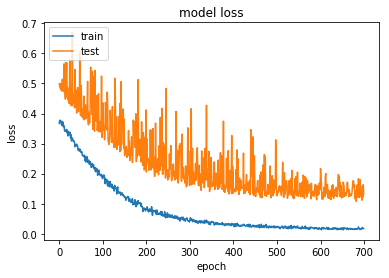

In [414]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [415]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [416]:

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


loaded_model.load_weights("model/aug_noiseNshift_6class6_np.h5")
#loaded_model.load_weights("model/Emotion_Voice_Detection_Model.h5")

print("Loaded model from disk")
 

loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 96.25%


# X. Predicting emotions on the test data

In [417]:
len(data3_df)

80

In [418]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 19.33it/s]


In [419]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

80/80 [==============================] - ETA:  - ETA:  - 0s 6ms/step


In [420]:
preds

array([[0.04808298, 0.95191705],
       [0.25361252, 0.7463875 ],
       [0.18690288, 0.8130972 ],
       [0.00353949, 0.9964605 ],
       [0.12197223, 0.8780278 ],
       [0.02077687, 0.97922313],
       [0.00121204, 0.99878794],
       [0.00235093, 0.997649  ],
       [0.06894511, 0.9310549 ],
       [0.5213175 , 0.4786825 ],
       [0.92548305, 0.074517  ],
       [0.5401261 , 0.4598739 ],
       [0.24148786, 0.75851214],
       [0.21578574, 0.78421426],
       [0.95440304, 0.04559695],
       [0.45102176, 0.5489782 ],
       [0.03391954, 0.9660805 ],
       [0.22764783, 0.77235216],
       [0.0012037 , 0.9987962 ],
       [0.00173842, 0.99826163],
       [0.0235428 , 0.9764572 ],
       [0.0126525 , 0.9873475 ],
       [0.00128344, 0.9987166 ],
       [0.02789302, 0.97210705],
       [0.14937086, 0.8506291 ],
       [0.36030278, 0.6396972 ],
       [0.9900636 , 0.00993644],
       [0.99609214, 0.00390785],
       [0.36993238, 0.6300676 ],
       [0.9538682 , 0.04613183],
       [0.

In [421]:
preds1=preds.argmax(axis=1)

In [422]:
preds1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [423]:
abc = preds1.astype(int).flatten()

In [424]:
predictions = (lb.inverse_transform((abc)))

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [425]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_negative


In [426]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [427]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [428]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [429]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_positive
21,male_negative,male_positive
22,male_negative,male_positive
23,male_negative,male_positive
24,male_negative,male_positive
25,male_negative,male_positive
26,male_negative,male_negative
27,male_negative,male_negative
28,male_negative,male_positive
29,male_negative,male_negative


In [430]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,48
male_positive,32


In [431]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_negative,43
male_positive,37


In [432]:
finaldf.to_csv('Predictions.csv', index=False)

In [433]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [434]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

61.25000000000001

In [435]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

60.50326485109093

In [436]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[30, 18],
       [13, 19]], dtype=int64)

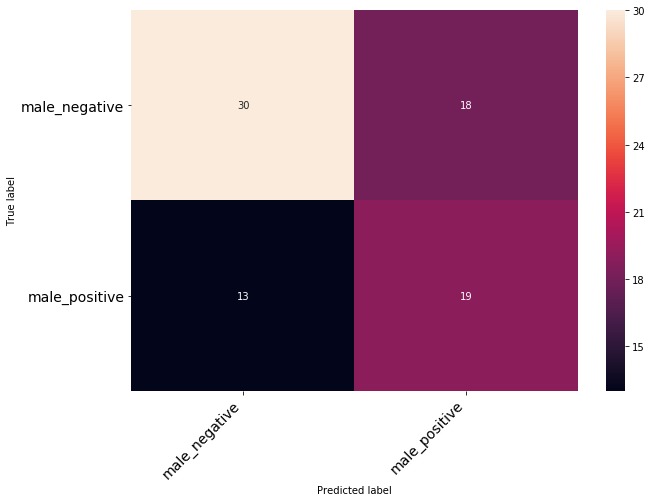

In [437]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

In [464]:
##LIVE DEMO
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


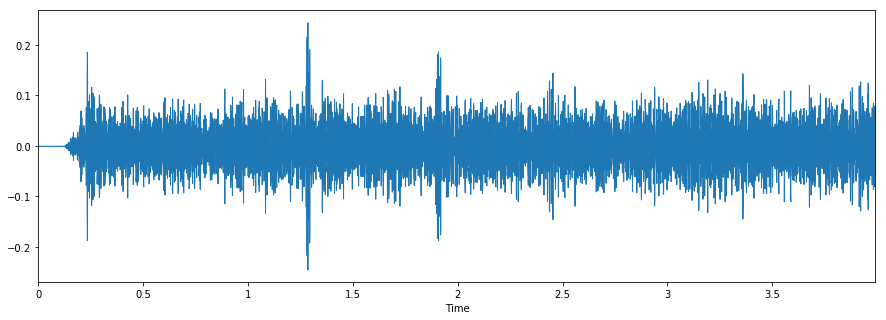

In [465]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [466]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=3.0,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [467]:
livedf2= pd.DataFrame(data=livedf2)

In [468]:
livedf2 = livedf2.stack().to_frame().T

In [469]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-13.795563,-12.721948,-12.465441,-13.850053,-15.661665,-15.784817,-15.413739,-14.331703,-10.964585,-10.644376,...,-8.468551,-8.055936,-10.870401,-12.642496,-11.727827,-10.668336,-8.765588,-8.941064,-9.117279,-6.578457


In [470]:
twodim= np.expand_dims(livedf2, axis=2)
#twodim

In [471]:
livepreds = loaded_model.predict(twodim,
                         batch_size=16, 
                         verbose=1)

1/1 [==============================] - 0s 11ms/step


In [472]:
livepreds

array([[0.22193639, 0.7780636 ]], dtype=float32)

In [473]:
livepreds1=livepreds.argmax(axis=1)

In [474]:
liveabc = livepreds1.astype(int).flatten()

In [476]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



array(['male_positive'], dtype=object)